In [1]:
# ==================== PART 1: IMPORT LIBRARIES ====================

# Core data manipulation
import pandas as pd
import numpy as np

# Date and time handling
import datetime as datetime

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from bokeh.io import output_notebook

# Machine Learning
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lars
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


# Advanced Modelling Libraries
import xgboost as xgb
import lightgbm as lgb
import catboost as cb


# Hyperparameter Tuning
import optuna

# Explainability
import shap

# AutoML
from pycaret.regression import setup, compare_models, blend_models, tune_model, evaluate_model, finalize_model, predict_model, pull, save_model

# SQL connection
import pyodbc

# Configure pandas display for clarity
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

# Configure seaborn
sns.set(style="whitegrid")




In [2]:
# ==================== PART 2: DOWNLOADING DATA ====================

start = datetime.date.today() - datetime.timedelta(days=365)  # Last 365 days
startdate = str(start) + ' 00:00:00'
start = pd.to_datetime(start, format='%Y-%m-%d %H:%M:%S')

end = datetime.date.today() + datetime.timedelta(days=1)  # Tomorrow
end = str(end)
enddate = str(end) + ' 22:30:00'
end = pd.to_datetime(enddate, format='%Y-%m-%d %H:%M:%S')

# --- 2 Define database connection functions ---

import pyodbc

# TradingCentralReporting DB
def connectToTCR():
    conn = pyodbc.connect('driver={SQL Server Native Client 11.0};'
                          'server=ENR-HVH-DWH-P53\\DWH_P53;'
                          'database=TradingCentralReporting;'
                          'Trusted_Connection=yes')
    return conn

# Settled Prices DB
def connectToSettledPrices():
    conn = pyodbc.connect('driver={SQL Server Native Client 11.0};'
                          'server=ENR-HVH-DWH-P53\\DWH_P53;'
                          'database=ISEM_Warehouse;'
                          'Trusted_Connection=yes')
    return conn

# Outages DB
def connectToOutage():
    conn = pyodbc.connect('driver={SQL Server Native Client 11.0};'
                          'server=ENR-HVH-DWH-P53\\DWH_P53;'
                          'database=ISEM_Warehouse;'
                          'Trusted_Connection=yes')
    return conn

# MLForecast DB for plant info
def connectToMLForecast():
    conn = pyodbc.connect('driver={SQL Server Native Client 11.0};'
                          'server=ENR-HVH-MLDB-01;'
                          'database=MLForecast;'
                          'Trusted_Connection=yes')
    return conn

# --- 3 Download MLForecastActualInputs table ---
TCRQuery = f"""
SELECT * FROM [TradingCentralReporting].[dbo].[MLForecastActualInputs]
WHERE StartDateTime BETWEEN '{startdate}' AND '{enddate}'
"""
conn1 = connectToTCR()
df_MLForecastActualInputs = pd.read_sql(TCRQuery, conn1)
conn1.close()

# --- 4 Download Settled Prices table using stored procedure ---
SettledPricesQuery = f"""
EXEC [tcr].[SettledPrices] @StartTradeDate = '2021-01-01', @EndTradeDate = '{enddate}'
"""
conn2 = connectToSettledPrices()
df_SettledPrices = pd.read_sql(SettledPricesQuery, conn2)
conn2.close()

# --- 5 Download Outages data ---
OutageQuery = f"""
EXEC [tcr].[OutageProfile_actuals] @StartTradeDate = '{startdate}', @EndTradeDate = '{enddate}', @GUCodes = NULL
"""
conn3 = connectToOutage()
df_Outages = pd.read_sql(OutageQuery, conn3)
conn3.close()

# --- 6 Download AllPlantInfo from MLForecast database ---
query_AllPlantInfo = "SELECT * FROM [MLForecast].[dbo].[AllISEMUnits]"
conn4 = connectToMLForecast()
df_AllPlantInfo = pd.read_sql(query_AllPlantInfo, conn4)
conn4.close()

# --- 7: Quick checks to confirm successful loads ---

print(f" MLForecastActualInputs loaded: {df_MLForecastActualInputs.shape}")
print(f" SettledPrices loaded: {df_SettledPrices.shape}")
print(f" Outages loaded: {df_Outages.shape}")
print(f" AllPlantInfo loaded: {df_AllPlantInfo.shape}")

# Optional: inspect first few rows for each dataset
display(df_MLForecastActualInputs.head(3))
display(df_SettledPrices.head(3))
display(df_Outages.head(3))
display(df_AllPlantInfo.head(3))






# Enrich Outages with AllPlantInfo
df_Outages_enriched = df_Outages.merge(
    df_AllPlantInfo,
    left_on='Plexos_SEM_Unit_ID',
    right_on='ResourceName',
    how='left'
)

# OPTIONAL: Check merge success
print(f" Enriched Outages shape: {df_Outages_enriched.shape}")
print(df_Outages_enriched[['Plexos_SEM_Unit_ID', 'ResourceName', 'UnitName', 'FuelType', 'RegisteredCapacity']].head())




 MLForecastActualInputs loaded: (17616, 66)
 SettledPrices loaded: (3780051, 11)
 Outages loaded: (6377547, 13)
 AllPlantInfo loaded: (843, 12)


StartDateTime  EirgridActualDemand  Meteo_ISEMWIND_DAM  Meteo_ISEMWIND_IDA1  Meteo_ISEMWIND_IDA2  Meteo_ISEMWIND_IDA3  EirgridActualWind  Meteo_ISEMDEMAND_DAM  Meteo_ISEMDEMAND_IDA1  \
0 2025-03-23 06:30:00               3833.0              3061.0               3127.0                  NaN                  NaN             3429.0                3921.0                 3905.0   
1 2025-03-23 07:00:00               3979.0              3068.0               3138.0                  NaN                  NaN             3524.0                4014.0                 4006.0   
2 2025-03-23 07:30:00               4141.0              3048.0               3132.0                  NaN                  NaN             3532.0                4114.0                 4112.0   

   Meteo_ISEMDEMAND_IDA2  Meteo_ISEMDEMAND_IDA3  PriceDAM  PriceIDA1  PriceIDA2  PriceIDA3  PriceImbalance  PNForecast  ICSchedule_EW  ICSchedule_M  RenewableForecast  DemandForecast    NIV  \
0                    NaN                    NaN     90.45      79.47        NaN        NaN            8.28       666.7         -147.3        -256.3             4119.9          4008.0  -53.9   
1                    NaN                    NaN     99.14      95.00        NaN        NaN           22.02       874.1         -147.3        -256.3             3893.0          4075.0 -252.7   
2                    NaN                    NaN     99.14      80.47        NaN        NaN           16.84      1232.8         -228.6        -293.9             3959.7          4251.0  -58.3   

   CorrectedNIVForecast  LoadForecastROI  LoadForecastNI  AggregatedForecast  PumpStorage  LTS_IC_NI  LTS_IC_ROI  TotalPN LTS_IC_NI_DAM  LTS_IC_NI_IDA1  LTS_IC_NI_IDA2  LTS_IC_NI_IDA3  \
0                -375.1         3322.628         808.416            4131.044       -143.0   -256.252    -147.303   666.73          None             0.0             NaN             NaN   
1                -288.6         3288.139         798.192            4086.331          0.0   -256.252    -147.303   874.14          None             0.0             NaN             NaN   
2                -419.0         3324.536         805.553            4130.089          5.0   -293.940    -228.600  1232.84          None             0.0             NaN             NaN   

  LTS_IC_ROI_DAM  LTS_IC_ROI_IDA1  LTS_IC_ROI_IDA2  LTS_IC_ROI_IDA3  PN_DAM  PN_IDA1  PN_IDA2  PN_IDA3  ActualMeterData  GBDAM_Price  GBHHDAM_Price  GBIDA1_Price  EirGridDemandFc_DAM  \
0           None              0.0              NaN              NaN     NaN   670.08      NaN      NaN         3299.406          NaN          82.00          68.0               3992.0   
1           None              0.0              NaN              NaN     NaN   871.24      NaN      NaN         3458.532         86.0          92.50          81.6               4046.0   
2           None              0.0              NaN              NaN     NaN  1229.59      NaN      NaN         3575.386          NaN          90.78          69.0               4206.0   

   EirGridDemandFc_IDA1  EirGridDemandFc_IDA2  EirGridDemandFc_IDA3  EirGridWindFc_DAM  EirGridWindFc_IDA1  EirGridWindFc_IDA2  EirGridWindFc_IDA3  EmSys_C_ISEMWIND_DAM  EmSys_C_ISEMWIND_IDA1  \
0                3992.0                   NaN                   NaN           3700.746            3972.857                 NaN                 NaN                3109.0                 3125.0   
1                4046.0                   NaN                   NaN           3669.882            3970.781                 NaN                 NaN                3118.0                 3129.0   
2                4206.0                   NaN                   NaN           3723.038            3983.940                 NaN                 NaN                3124.0                 3132.0   

   EmSys_C_ISEMWIND_IDA2  EmSys_C_ISEMWIND_IDA3  EmSys_U_ISEMWIND_DAM  EmSys_U_ISEMWIND_IDA1  EmSys_U_ISEMWIND_IDA2  EmSys_U_ISEMWIND_IDA3  PostDAMFlow  PostIDA1Flow  PostIDA2Flow  PostID

StartDateKey  StartTimeKey StartTime   StartDate       StartDateTime  TradeDate  TradeDateKey Commodity MarketName  PriceGBP  PriceEUR
0      20231224             1  00:00:00  2023-12-24 2023-12-24 00:00:00 2023-12-24      20231224     Power    ISEM BM       0.0       0.0
1      20231224           301  00:05:00  2023-12-24 2023-12-24 00:05:00 2023-12-24      20231224     Power    ISEM BM       0.0       0.0
2      20231224           601  00:10:00  2023-12-24 2023-12-24 00:10:00 2023-12-24      20231224     Power    ISEM BM       0.0       0.0

StartDateTime Plexos_SEM_Unit_ID NordPoolFuelName PlexosCategory  NordpoolCode          eventStart           eventStop eventStatus  InstalledCapacityMW  AvailableCapacityMW  \
0 2024-08-14 03:30:00          GU_400183       Fossil Gas     MULTI_FUEL  A0000207A.IE 2024-07-23 12:19:00 2024-11-09 18:00:00           1                   90                  0.0   
1 2024-08-14 03:30:00          GU_400200             None          HYDRO          None                 NaT                 NaT        None                   21                 21.0   
2 2024-08-14 03:30:00          GU_400201             None          HYDRO          None                 NaT                 NaT        None                   22                 22.0   

   UnavailableCapacityMW         publicationDate   firstNotificationDate  
0                     90 2024-11-08 22:41:56.513 2024-07-23 12:40:47.547  
1                      0                     NaT                     NaT  
2                      0                     NaT                     NaT

PartyID                          PartyName ParticipantName ResourceName            ResourceType FuelType Intermediary  Registered EffectiveDate                     UnitName  RegisteredCapacity  \
0  PY_000135  Orsted Renewable Supply 2 Limited       PT_400157    AU_400144  ASSETLESS_TRADING_UNIT     None         None  Registered    2023-01-18                         None               0.000   
1  PY_000093      iPower Flexible Energy Limted       PT_402574   DSU_403650        DEMAND_SIDE_UNIT     None           No  Registered    2024-03-13                   IPower R01               6.277   
2  PY_000030                                ESB       PT_400030    GU_400270               GENERATOR     COAL           No  Registered    2007-11-01  Moneypoint 1 Generator Unit             285.000   

  Jurisdiction  
0          ROI  
1          ROI  
2          ROI

 Enriched Outages shape: (6412685, 25)
  Plexos_SEM_Unit_ID ResourceName                        UnitName    FuelType  RegisteredCapacity
0          GU_400183    GU_400183     AGHADA CT14 Generator Unit   MULTI_FUEL                90.0
1          GU_400200    GU_400200  Ardnacrusha 1 Generator Unit         HYDRO                21.0
2          GU_400201    GU_400201  Ardnacrusha 2 Generator Unit         HYDRO                22.0
3          GU_400202    GU_400202   Ardnacrusha 3 Generator Unit        HYDRO                19.0
4          GU_400203    GU_400203    Ardnacrusha 4 Generator Unit       HYDRO                24.0


In [3]:
# ==================== PART 3a: CREATING SYNTHETIC VARIABLES (FORECAST DATA) ====================

# --- Ensure datetime consistency ---
df_MLForecastActualInputs['StartDateTime'] = pd.to_datetime(df_MLForecastActualInputs['StartDateTime'])
df_SettledPrices['StartDateTime'] = pd.to_datetime(df_SettledPrices['StartDateTime'])

# Clean market names where needed
df_SettledPrices.loc[df_SettledPrices['MarketName'] == 'Spectrometer', 'MarketName'] = df_SettledPrices['Commodity']

# Filter to relevant markets
markets = ['GB DAM Epex', 'GB DAM N2EX', 'GB DAM HH Epex', 'GB IDA1 N2EX', 'GB IDA1 Epex', 'GB IDA2 Epex', 'GB IDA2 N2EX']
df_SettledPrices = df_SettledPrices[df_SettledPrices['MarketName'].isin(markets)]

# Pivot prices and resample to 30-min intervals
pivot_prices = df_SettledPrices.pivot_table(
    values='PriceEUR',
    index='StartDateTime',
    columns='MarketName',
    aggfunc='mean'
).resample('30Min').mean().reset_index()

# Sort and reset MLForecastActualInputs
df_MLForecastActualInputs.sort_values(by='StartDateTime', inplace=True)
df_MLForecastActualInputs.reset_index(drop=True, inplace=True)
df_MLForecastActualInputs.set_index('StartDateTime', inplace=True)

# Merge forecast data with settled prices
df = pd.merge(
    df_MLForecastActualInputs.reset_index(),
    pivot_prices,
    on='StartDateTime',
    how='left'
)

# Rename columns for clarity
df.rename(columns={
    'GB DAM Epex':'GB_DAM_Epex', 'GB DAM N2EX':'GB_DAM_N2EX',
    'GB DAM HH Epex':'GB_DAM_HH_Epex', 'GB IDA1 N2EX':'GB_IDA1_N2EX',
    'GB IDA1 Epex':'GB_IDA1_Epex', 'GB IDA2 Epex':'GB_IDA2_Epex',
    'GB IDA2 N2EX':'GB_IDA2_N2EX'
}, inplace=True)

# Feature engineering
df['Month'] = df['StartDateTime'].dt.month
df['Day'] = df['StartDateTime'].dt.day
df['Hour'] = df['StartDateTime'].dt.hour

# Create spreads: BM - DAM
df['Spreads'] = df['PriceImbalance'] - df['PriceDAM']
print("Forecast data synthetic variables created.")




Forecast data synthetic variables created.


In [4]:
# ==================== PART 3b: CREATING SYNTHETIC VARIABLES (OUTAGES + PLANT INFO + PRICE) ====================

# Ensure StartDateTime is a column for merging
if df_MLForecastActualInputs.index.name == 'StartDateTime':
    df_MLForecastActualInputs = df_MLForecastActualInputs.reset_index()

# Convert datetime where needed
df_MLForecastActualInputs['StartDateTime'] = pd.to_datetime(df_MLForecastActualInputs['StartDateTime'])
df_Outages_enriched['StartDateTime'] = pd.to_datetime(df_Outages_enriched['StartDateTime'])
df_SettledPrices['StartDateTime'] = pd.to_datetime(df_SettledPrices['StartDateTime'])

# 1. Aggregate outages by 30-minute interval
outage_by_time = (
    df_Outages_enriched
    .groupby('StartDateTime')['UnavailableCapacityMW']
    .sum()
    .reset_index()
    .rename(columns={'UnavailableCapacityMW': 'TotalOutageMW'})
)

# 2. Filter Settled Prices for key GB + Irish markets
markets_of_interest = ['ISEM DAM', 'GB DAM Epex', 'GB DAM N2EX', 'GB IDA1 Epex']
df_SettledPrices = df_SettledPrices[df_SettledPrices['MarketName'].isin(markets_of_interest)]

price_pivot = df_SettledPrices.pivot_table(
    index='StartDateTime',
    columns='MarketName',
    values='PriceEUR',
    aggfunc='mean'
).reset_index()

# 3. Merge Settled Prices with outage data
combined_prices_df = pd.merge(
    price_pivot,
    outage_by_time,
    on='StartDateTime',
    how='left'
)

# 4. Floor timestamps for consistent merge
combined_prices_df['StartDateTime'] = combined_prices_df['StartDateTime'].dt.floor('30min')
df_MLForecastActualInputs['StartDateTime'] = df_MLForecastActualInputs['StartDateTime'].dt.floor('30min')

# 5. Merge in all necessary ML forecast columns
merge_cols = [
    'StartDateTime',
    'PriceDAM', 'PriceIDA1', 'PriceIDA2', 'PriceIDA3', 'PriceImbalance',
    'Meteo_ISEMWIND_DAM', 'Meteo_ISEMDEMAND_DAM', 'DemandForecast'
]

combined_prices_df = pd.merge(
    combined_prices_df,
    df_MLForecastActualInputs[merge_cols],
    on='StartDateTime',
    how='left'
)

# 6. Net demand calculation
combined_prices_df['NetDemand'] = (
    combined_prices_df['Meteo_ISEMDEMAND_DAM'] - combined_prices_df['Meteo_ISEMWIND_DAM']
)

# 7. Spread between GB and Irish DAM markets
combined_prices_df['Spread_GB_Irish'] = combined_prices_df['GB DAM Epex'] - combined_prices_df['PriceDAM']

# 8. Create flags for scenarios
high_demand_threshold = combined_prices_df['NetDemand'].quantile(0.75)
low_wind_threshold = combined_prices_df['Meteo_ISEMWIND_DAM'].quantile(0.25)
high_outage_threshold = combined_prices_df['TotalOutageMW'].quantile(0.9)

combined_prices_df['HighDemand'] = combined_prices_df['NetDemand'] > high_demand_threshold
combined_prices_df['LowWind'] = combined_prices_df['Meteo_ISEMWIND_DAM'] < low_wind_threshold
combined_prices_df['HighOutage'] = combined_prices_df['TotalOutageMW'] > high_outage_threshold

# 9. Lags and rolling features
combined_prices_df['PriceDAM_lag48'] = combined_prices_df['PriceDAM'].shift(48)
combined_prices_df['NetDemand_rolling7'] = combined_prices_df['NetDemand'].rolling(window=7, min_periods=1).mean()
combined_prices_df['Meteo_ISEMWIND_DAM_rolling7'] = combined_prices_df['Meteo_ISEMWIND_DAM'].rolling(window=7, min_periods=1).mean()


# 9.5 Create pivoted outage matrix from df_Outages
pivot_Outages = df_Outages.pivot_table(
    values='UnavailableCapacityMW',
    index='StartDateTime',
    columns='Plexos_SEM_Unit_ID',
    aggfunc='sum'
).reset_index()

# 10. Merge pivoted outage matrix (plant-level data)
pivot_Outages['StartDateTime'] = pd.to_datetime(pivot_Outages['StartDateTime'])

combined_prices_df = pd.merge(
    combined_prices_df,
    pivot_Outages,
    on='StartDateTime',
    how='left'
)

# 11. Fill missing outage values with 0
plant_cols = [col for col in pivot_Outages.columns if col != 'StartDateTime']
combined_prices_df[plant_cols] = combined_prices_df[plant_cols].fillna(0)











In [41]:
# ==================== Extended SCENARIO FLAGS for later outage analysis in section 11 ====================

# 1. Recalculate base thresholds for consistency
net_demand_70 = combined_prices_df['NetDemand'].quantile(0.7)
net_demand_30 = combined_prices_df['NetDemand'].quantile(0.3)
wind_30 = combined_prices_df['Meteo_ISEMWIND_DAM'].quantile(0.3)
outage_70 = combined_prices_df['TotalOutageMW'].quantile(0.7)
outage_30 = combined_prices_df['TotalOutageMW'].quantile(0.3)

# 2. High Demand, Low Wind, High Outage (already used before)
combined_prices_df['HighDemand'] = (combined_prices_df['NetDemand'] > net_demand_70).astype(int)
combined_prices_df['LowWind'] = (combined_prices_df['Meteo_ISEMWIND_DAM'] < wind_30).astype(int)
combined_prices_df['HighOutage'] = (combined_prices_df['TotalOutageMW'] > outage_70).astype(int)

# 3. Ramp Rate
combined_prices_df['RampRate'] = combined_prices_df['NetDemand'].diff()
ramp_70 = combined_prices_df['RampRate'].quantile(0.7)
combined_prices_df['HighRamp'] = (combined_prices_df['RampRate'] > ramp_70).astype(int)

# 4. Price Volatility (24-step rolling)
combined_prices_df['PriceVolatility'] = combined_prices_df['PriceDAM'].rolling(24).std()
vol_70 = combined_prices_df['PriceVolatility'].quantile(0.7)
combined_prices_df['HighVolatility'] = (combined_prices_df['PriceVolatility'] > vol_70).astype(int)

# 5. Wind Forecast Error
combined_prices_df['WindForecastError'] = (
    combined_prices_df['EirGridWindFc_IDA1'] - combined_prices_df['EmSys_C_ISEMWIND_IDA1']
)
forecast_error_70 = combined_prices_df['WindForecastError'].abs().quantile(0.7)
combined_prices_df['HighForecastError'] = (
    combined_prices_df['WindForecastError'].abs() > forecast_error_70
).astype(int)

# 6. Congestion Risk (High Outage + High Demand)
combined_prices_df['CongestionRisk'] = (
    (combined_prices_df['TotalOutageMW'] > outage_70) &
    (combined_prices_df['NetDemand'] > net_demand_70)
).astype(int)

# 7. Low Risk Period
combined_prices_df['LowRiskPeriod'] = (
    (combined_prices_df['TotalOutageMW'] < outage_30) &
    (combined_prices_df['NetDemand'] < net_demand_30)
).astype(int)

print("✅ All custom scenario variables added.")


✅ All custom scenario variables added.


In [42]:
print(combined_prices_df.columns.tolist())

['StartDateTime', 'GB DAM Epex', 'GB DAM N2EX', 'GB IDA1 Epex', 'TotalOutageMW', 'PriceDAM', 'PriceIDA1', 'PriceIDA2', 'PriceIDA3', 'PriceImbalance', 'Meteo_ISEMWIND_DAM', 'Meteo_ISEMDEMAND_DAM', 'DemandForecast', 'NetDemand', 'Spread_GB_Irish', 'HighDemand', 'LowWind', 'HighOutage', 'PriceDAM_lag48', 'NetDemand_rolling7', 'Meteo_ISEMWIND_DAM_rolling7', 'DSU_401270', 'DSU_401330', 'DSU_401400', 'DSU_401490', 'DSU_401530', 'DSU_401590', 'DSU_401610', 'DSU_401620', 'DSU_401660', 'DSU_401800', 'DSU_401850', 'DSU_401870', 'DSU_401880', 'DSU_401910', 'DSU_402040', 'DSU_402090', 'DSU_402100', 'DSU_402120', 'DSU_402180', 'DSU_403020', 'DSU_403030', 'DSU_403040', 'DSU_403050', 'DSU_403080', 'DSU_403120', 'DSU_403450', 'DSU_403470', 'DSU_403500', 'DSU_403520', 'DSU_403560', 'DSU_403590', 'DSU_403620', 'DSU_403630', 'DSU_403640', 'DSU_403650', 'DSU_403660', 'DSU_403690', 'DSU_403720', 'DSU_403730', 'DSU_403760', 'DSU_403790', 'DSU_501200', 'DSU_501330', 'DSU_501380', 'DSU_501450', 'DSU_501460', 

In [6]:
# =========================================== Part 3C - Data Dictionary Creation =========================================

print("\nGenerating Updated Data Dictionary for Energia Project")

# Construct dictionary structure
columns_dict = {}

# DataFrames to scan
dataframes_sources = {
'df_MLForecastActualInputs': df_MLForecastActualInputs,
'df_SettledPrices': df_SettledPrices,
'df_Outages_enriched': df_Outages_enriched,
'combined_prices_df': combined_prices_df
}

# Refresh metadata
refresh_frequency = "Daily"
first_refresh = "06:00"
last_refresh = "23:00"

# Known clean descriptions
descriptions = {
    'ActualMeterData': 'Actual metered generation or demand data collected in MW.',
    'AggregatedForecast': 'Forecast of total system demand including all sources in MW.',
    'AvailableCapacityMW': 'Available generation capacity for dispatch in MW per unit.',
    'Commodity': 'Traded commodity type (Electricity).',
    'CorrectedNIVForecast': 'Corrected Net Imbalance Volume forecast, in MW.',
    'EffectiveDate': 'Effective date for outage or trading records.',
    'EirGridDemandFc_DAM': 'EirGrid forecasted demand for DAM market in MW.',
    'EirGridDemandFc_IDA1': 'EirGrid forecasted demand for IDA1 market in MW.',
    'EirGridDemandFc_IDA2': 'EirGrid forecasted demand for IDA2 market in MW.',
    'EirGridDemandFc_IDA3': 'EirGrid forecasted demand for IDA3 market in MW.',
    'EirGridWindFc_DAM': 'EirGrid forecasted wind generation for DAM market in MW.',
    'EirGridWindFc_IDA1': 'EirGrid forecasted wind generation for IDA1 market in MW.',
    'EirGridWindFc_IDA2': 'EirGrid forecasted wind generation for IDA2 market in MW.',
    'EirGridWindFc_IDA3': 'EirGrid forecasted wind generation for IDA3 market in MW.',
    'EmSys_C_ISEMWIND_DAM': 'Ensemble system central forecast of ISEM wind for DAM in MW.',
    'EmSys_C_ISEMWIND_IDA1': 'Ensemble system central forecast of ISEM wind for IDA1 in MW.',
    'EmSys_C_ISEMWIND_IDA2': 'Ensemble system central forecast of ISEM wind for IDA2 in MW.',
    'EmSys_C_ISEMWIND_IDA3': 'Ensemble system central forecast of ISEM wind for IDA3 in MW.',
    'EmSys_U_ISEMWIND_DAM': 'Ensemble system uncertainty forecast of ISEM wind for DAM in MW.',
    'EmSys_U_ISEMWIND_IDA1': 'Ensemble system uncertainty forecast of ISEM wind for IDA1 in MW.',
    'EmSys_U_ISEMWIND_IDA2': 'Ensemble system uncertainty forecast of ISEM wind for IDA2 in MW.',
    'EmSys_U_ISEMWIND_IDA3': 'Ensemble system uncertainty forecast of ISEM wind for IDA3 in MW.',
    'FuelType': 'Fuel type of the generation unit (e.g., Gas, Wind, Coal).',
    'GBDAM_Price': 'GB Day-Ahead Market price sourced internally in EUR/MWh.',
    'GBHHDAM_Price': 'GB Half-Hourly Day-Ahead Market price in EUR/MWh.',
    'GBIDA1_Price': 'GB IDA1 Market price sourced internally in EUR/MWh.',
    'HighDemand': 'Binary flag indicating periods of high demand.',
    'HighOutage': 'Binary flag indicating periods of high generation outages.',
    'ICSchedule_EW': 'Interconnector scheduled flow East-West in MW.',
    'ICSchedule_M': 'Interconnector scheduled flow Moyle in MW.',
    'InstalledCapacityMW': 'Installed generation capacity in MW.',
    'Intermediary': 'Intermediary information for unit or trade.',
    'LTS_IC_NI': 'Long-term interconnector schedule for NI in MW.',
    'LTS_IC_NI_DAM': 'Long-term interconnector schedule for NI for DAM in MW.',
    'LTS_IC_NI_IDA1': 'Long-term interconnector schedule for NI for IDA1 in MW.',
    'LTS_IC_NI_IDA2': 'Long-term interconnector schedule for NI for IDA2 in MW.',
    'LTS_IC_NI_IDA3': 'Long-term interconnector schedule for NI for IDA3 in MW.',
    'LTS_IC_ROI': 'Long-term interconnector schedule for ROI in MW.',
    'LTS_IC_ROI_DAM': 'Long-term interconnector schedule for ROI for DAM in MW.',
    'LTS_IC_ROI_IDA1': 'Long-term interconnector schedule for ROI for IDA1 in MW.',
    'LTS_IC_ROI_IDA2': 'Long-term interconnector schedule for ROI for IDA2 in MW.',
    'LTS_IC_ROI_IDA3': 'Long-term interconnector schedule for ROI for IDA3 in MW.',
    'LoadForecastNI': 'Load forecast for Northern Ireland in MW.',
    'LoadForecastROI': 'Load forecast for Republic of Ireland in MW.',
    'LowWind': 'Binary flag indicating periods of low wind generation forecast.',
    'MarketName': 'Market name for settled prices (DAM, IDA1, BM, etc.).',
    'Meteo_ISEMDEMAND_DAM': 'Meteorological forecast demand for DAM in MW.',
    'Meteo_ISEMDEMAND_IDA1': 'Meteorological forecast demand for IDA1 in MW.',
    'Meteo_ISEMDEMAND_IDA2': 'Meteorological forecast demand for IDA2 in MW.',
    'Meteo_ISEMDEMAND_IDA3': 'Meteorological forecast demand for IDA3 in MW.',
    'Meteo_ISEMWIND_IDA1': 'Forecast wind generation for IDA1 in MW.',
    'Meteo_ISEMWIND_IDA2': 'Forecast wind generation for IDA2 in MW.',
    'Meteo_ISEMWIND_IDA3': 'Forecast wind generation for IDA3 in MW.',
    'NIV': 'Net Imbalance Volume in MW.',
    'NordPoolFuelName': 'Fuel name as reported by NordPool.',
    'NordpoolCode': 'Nordpool code identifier.',
    'PNForecast': 'Physical Notification forecast in MW.',
    'PN_DAM': 'Physical Notification for DAM in MW.',
    'PN_IDA1': 'Physical Notification for IDA1 in MW.',
    'PN_IDA2': 'Physical Notification for IDA2 in MW.',
    'PN_IDA3': 'Physical Notification for IDA3 in MW.',
    'ParticipantName': 'Name of the market participant.',
    'PartyID': 'Party identifier code.',
    'PartyName': 'Name of the market party.',
    'PlexosCategory': 'Category of the unit as per PLEXOS model.',
    'Plexos_SEM_Unit_ID': 'Unit ID in PLEXOS SEM model.',
    'PostDAMFlow': 'Post DAM flow adjustment in MW.',
    'PostIDA1Flow': 'Post IDA1 flow adjustment in MW.',
    'PostIDA2Flow': 'Post IDA2 flow adjustment in MW.',
    'PostIDA3Flow': 'Post IDA3 flow adjustment in MW.',
    'PriceEUR': 'Price in EUR.',
    'PriceGBP': 'Price in GBP.',
    'PumpStorage': 'Pumped storage unit activity.',
    'Registered': 'Flag if the unit is registered in market.',
    'RenewableForecast': 'Forecast of renewable generation in MW.',
    'ResourceName': 'Name of the resource/unit.',
    'ResourceType': 'Type of the resource/unit (e.g., Wind, Gas).',
    'StartDate': 'Start date of trade or market period.',
    'StartDateKey': 'Key for Start Date.',
    'StartTime': 'Start time of trade or market period.',
    'StartTimeKey': 'Key for Start Time.',
    'TradeDate': 'Date of trade.',
    'TradeDateKey': 'Key for Trade Date.',
    'UnavailableCapacityMW': 'Unavailable capacity due to outage in MW.',
    'eventStart': 'Start time of an outage event.',
    'eventStatus': 'Status of the outage event.',
    'eventStop': 'Stop time of an outage event.',
    'firstNotificationDate': 'Date when the outage was first notified.',
    'publicationDate': 'Date when the outage was published.',
}


# Build dynamically
for source_name, df in dataframes_sources.items():
    for col in df.columns:
        columns_dict[col] = {
            'Variable Name': col,
            'Description': descriptions.get(col, 'Description to be completed based on context'),
            'Source Table': source_name,
            'Refresh Frequency': refresh_frequency,
            'First Refresh Time': first_refresh,
            'Last Refresh Time': last_refresh
        }
        
# Convert to DataFrame
data_dictionary_df = pd.DataFrame(columns_dict.values())
data_dictionary_df.sort_values(by='Variable Name', inplace=True)

# Export to Excel
output_file = 'Energia_Data_Dictionary.xlsx'
data_dictionary_df.to_excel(output_file, index=False)

print(f"Updated Data Dictionary generated and saved as '{output_file}'. ")





Generating Updated Data Dictionary for Energia Project
Updated Data Dictionary generated and saved as 'Energia_Data_Dictionary.xlsx'. 


Dataframe shape: (1105, 454)


StartDateTime  GB DAM Epex  GB DAM N2EX  GB IDA1 Epex  TotalOutageMW  PriceDAM  PriceIDA1  PriceIDA2  PriceIDA3  PriceImbalance  ...  SignalPnL_IDA3  PredictedDirection_BM  \
64222 2024-08-30 22:00:00   104.307852   105.449388      104.6408         2258.0    122.12     126.34      121.6      109.0           95.79  ...            2.00                    0.0   
64365 2024-09-02 21:30:00   106.174739   104.807274      110.5863         2254.0    145.00     151.00      156.0      156.6           44.35  ...           -2.60                    0.0   
64366 2024-09-02 22:00:00    99.706035   103.534937      109.3972         2254.0    119.87     123.88      156.0      154.0           85.96  ...          -42.52                    0.0   

       PredictedDirection_BM_Lag1  SignalPnL_BM  WindForecastError  HighForecastError  CongestionRisk  LowRiskPeriod  Signal  Correct  
64222                         0.0          5.83           -244.714                  0               1              0    -1.0    False  
64365                         1.0         41.61           -121.724                  0               1              0     1.0     True  
64366                         0.0         26.90           -138.695                  0               1              0    -1.0    False  

[3 rows x 454 columns]

Missing Data Summary:
                   MissingCount  Total  MissingPercent
TrueChange_IDA3             798   1105       72.217195
SignalPnL_IDA3              798   1105       72.217195
PriceIDA3                   779   1105       70.497738
PriceIDA3_Forward           768   1105       69.502262
GBDAM_Price                 547   1105       49.502262
TrueChange_IDA2             369   1105       33.393665
SignalPnL_IDA2              369   1105       33.393665
PriceIDA2                   350   1105       31.674208
PriceIDA2_Forward           326   1105       29.502262
NIV                           9   1105        0.814480
PriceVolatility               3   1105        0.271493


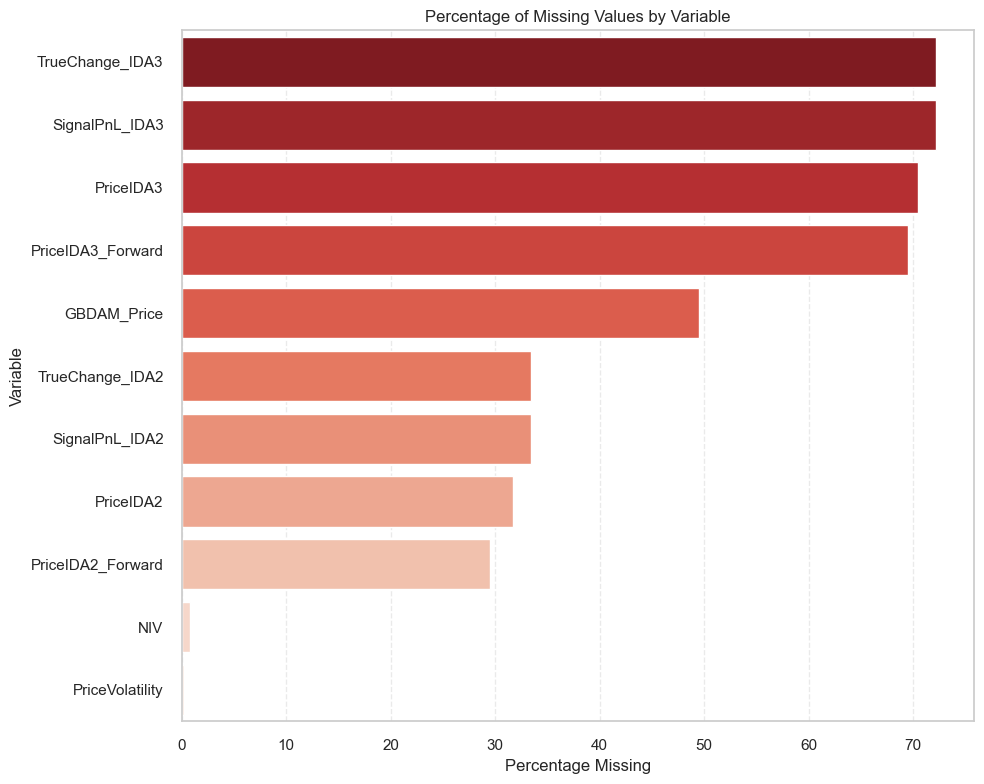

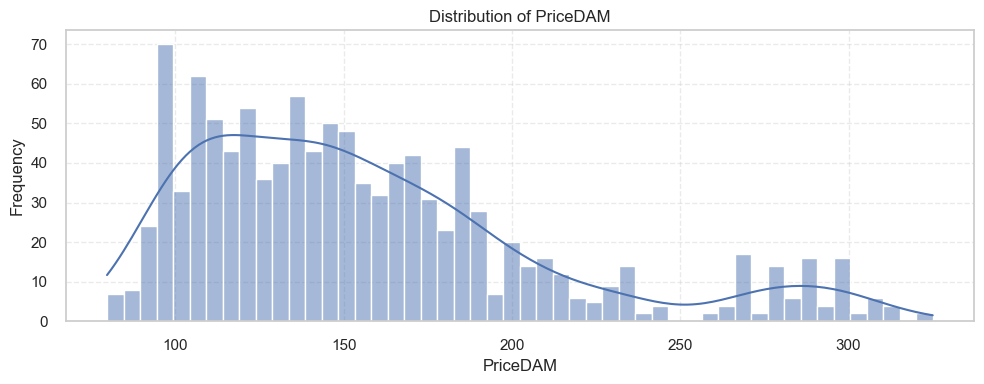

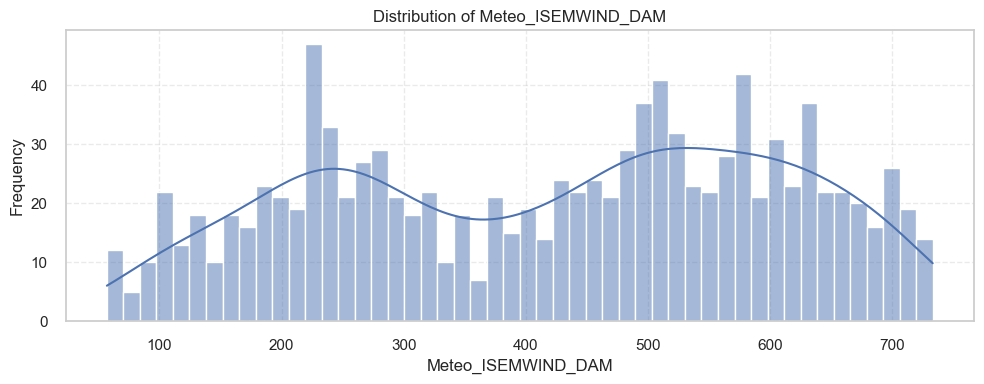

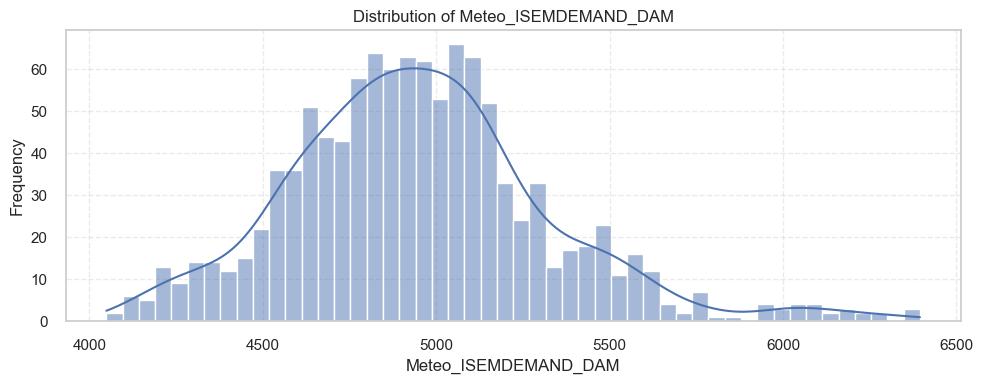

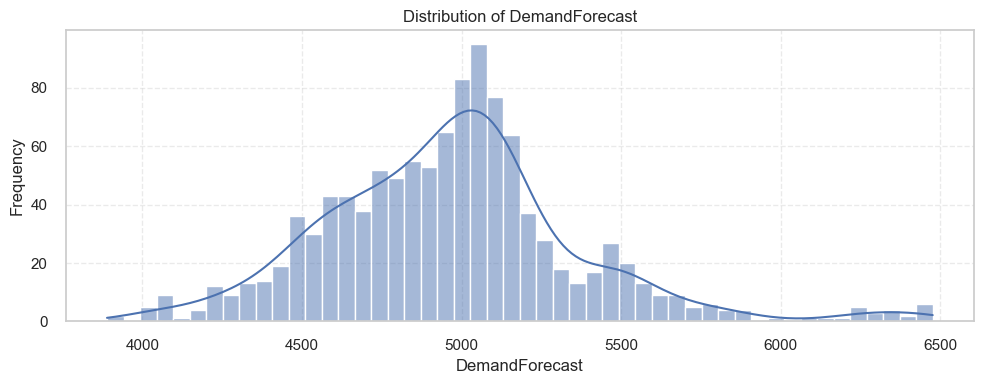

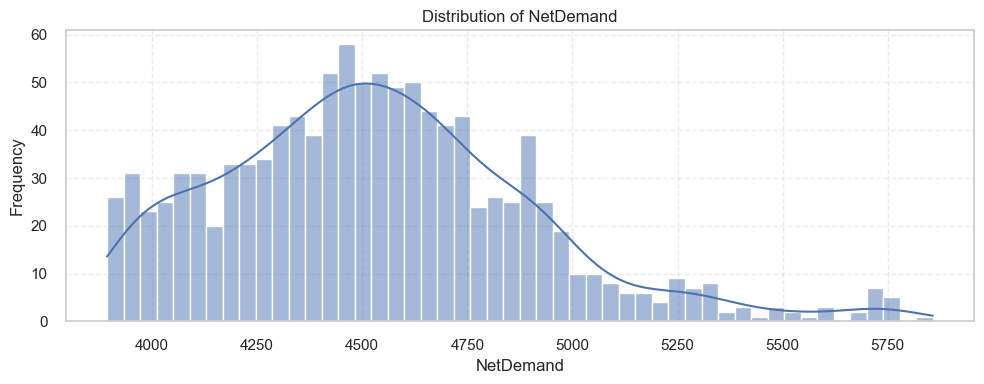

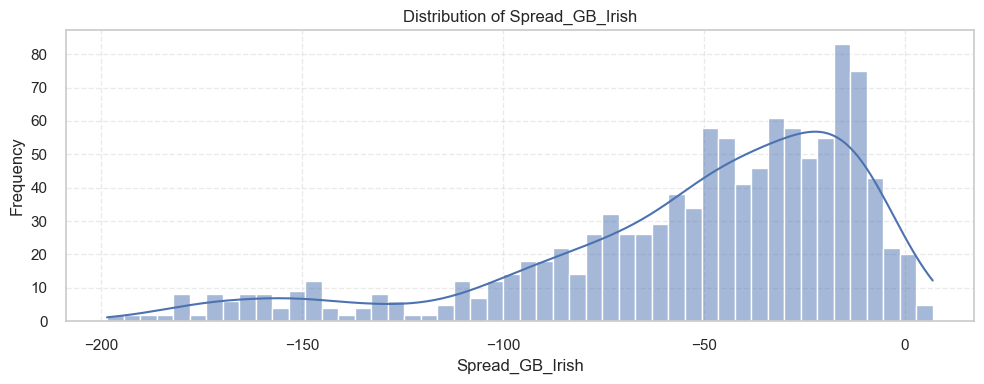

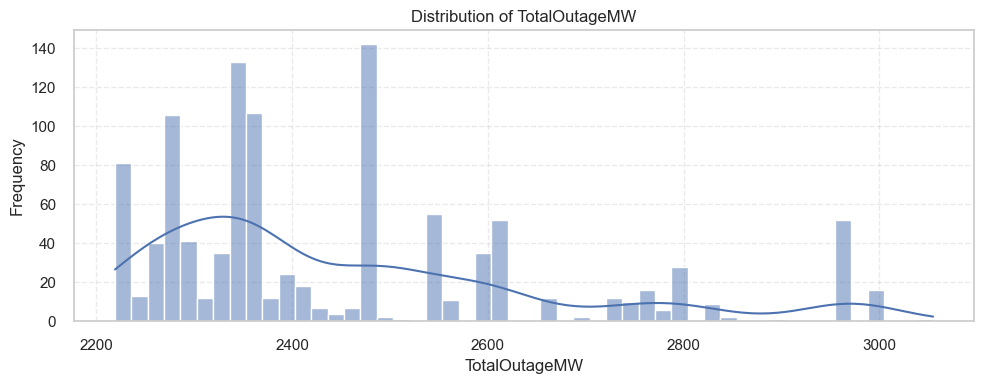

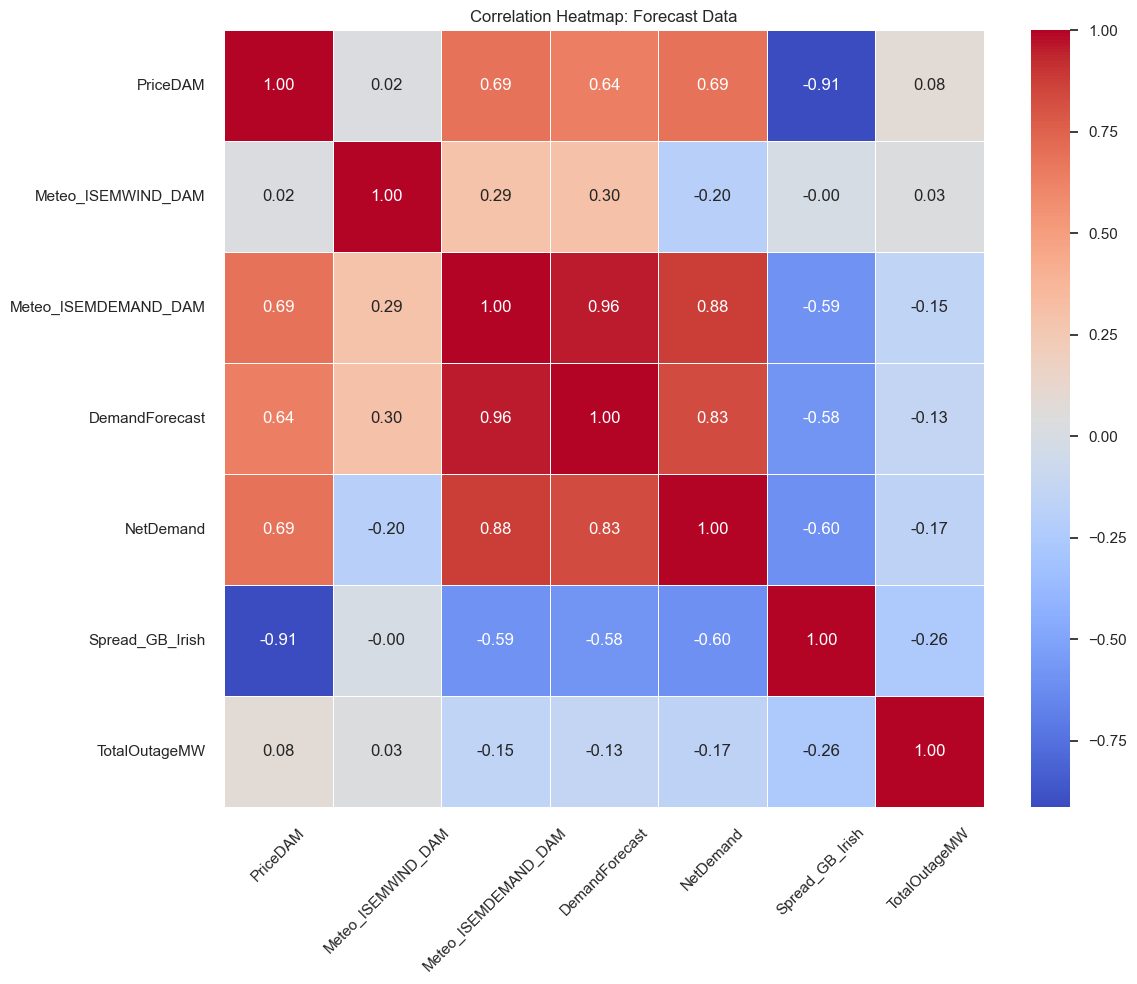

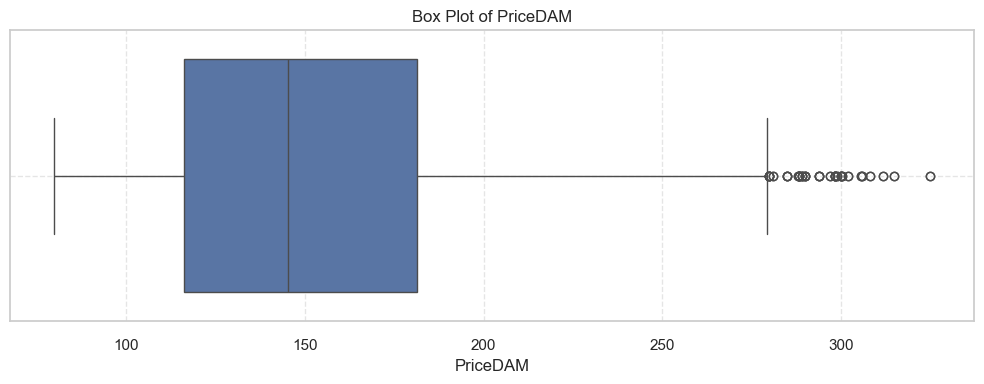

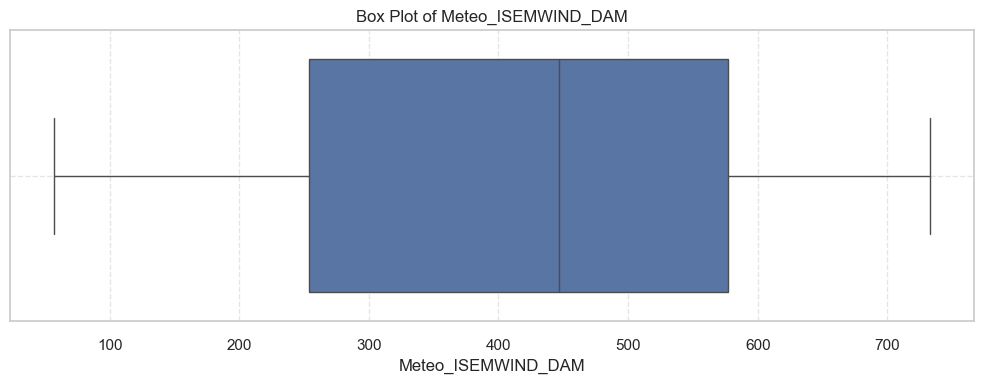

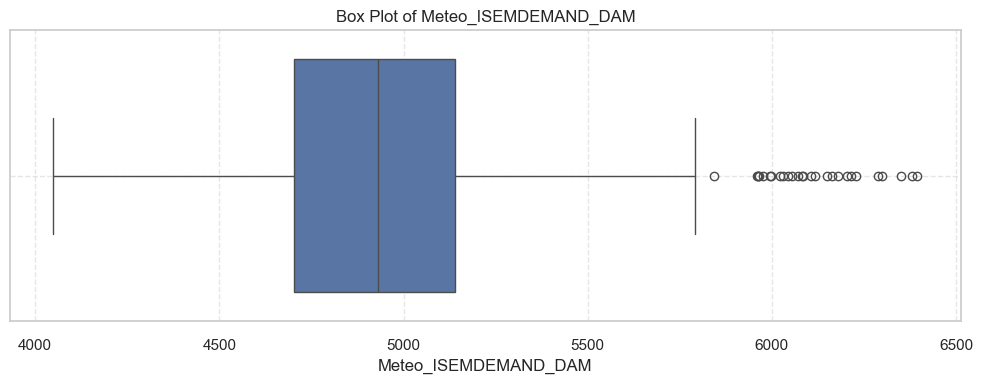

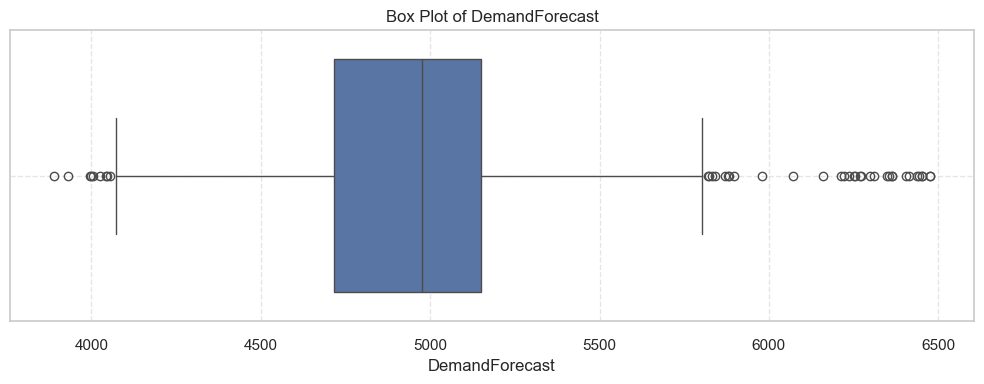

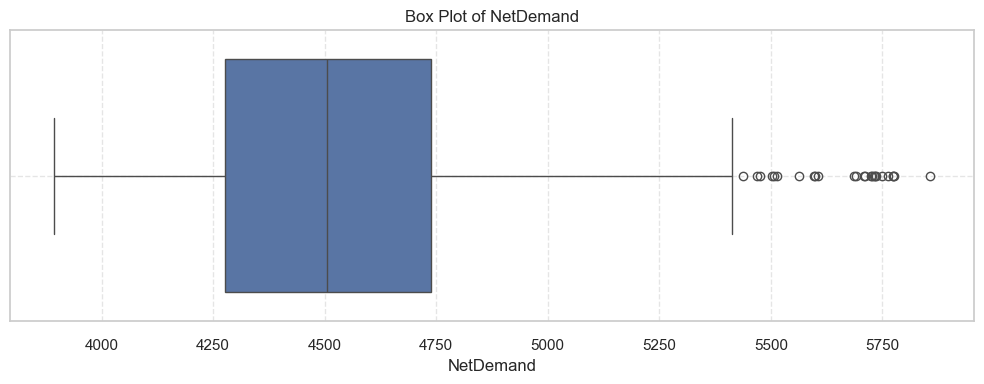

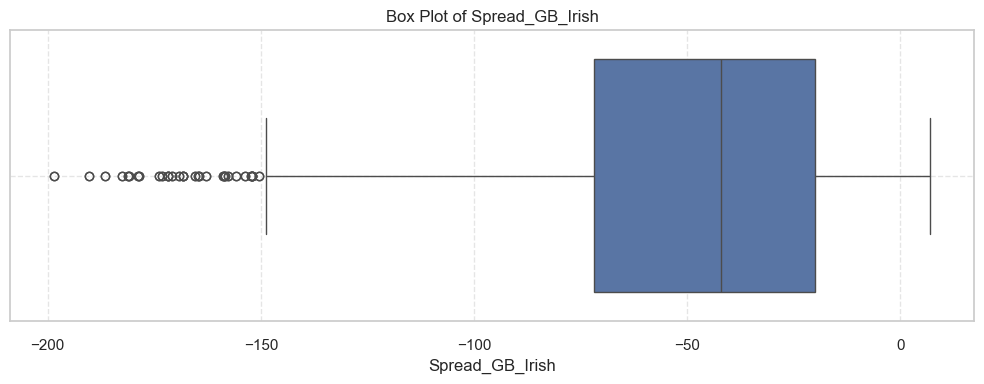

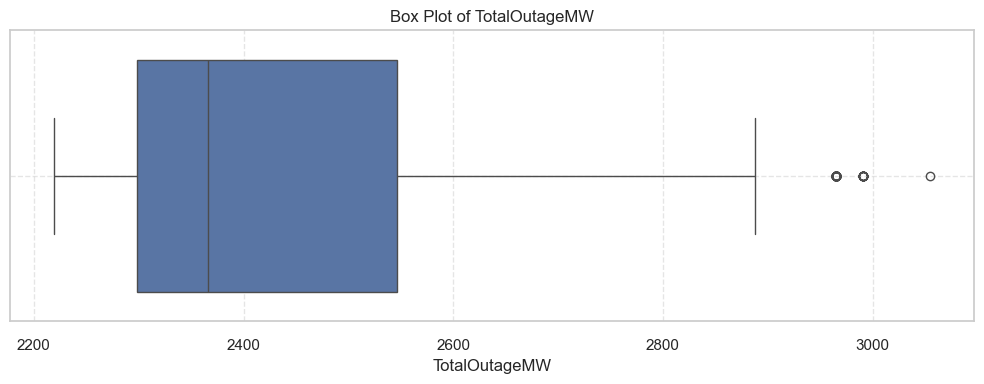

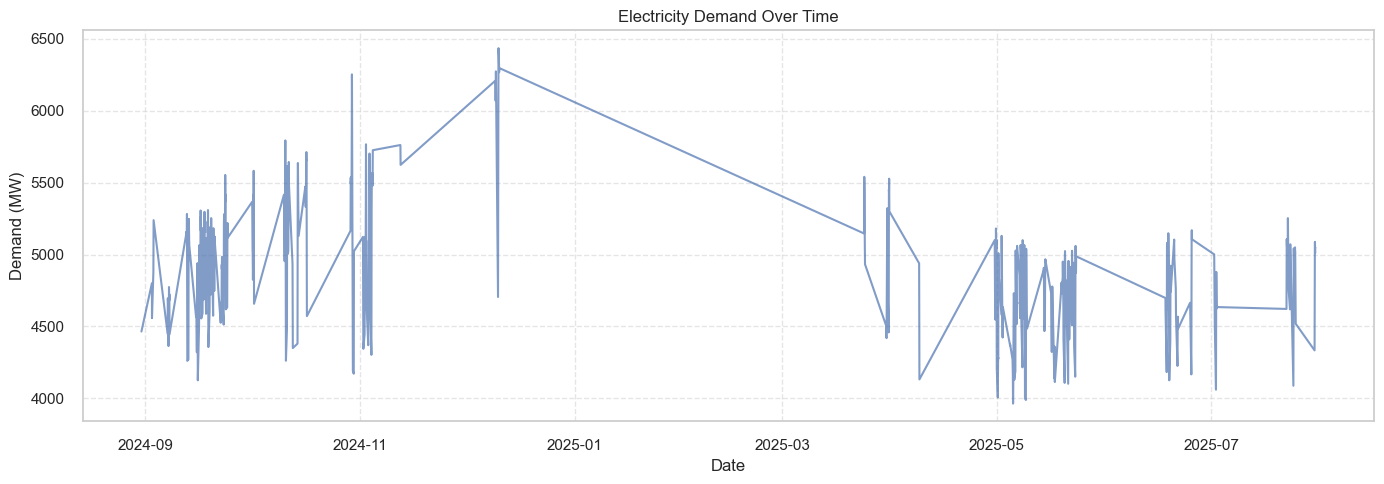

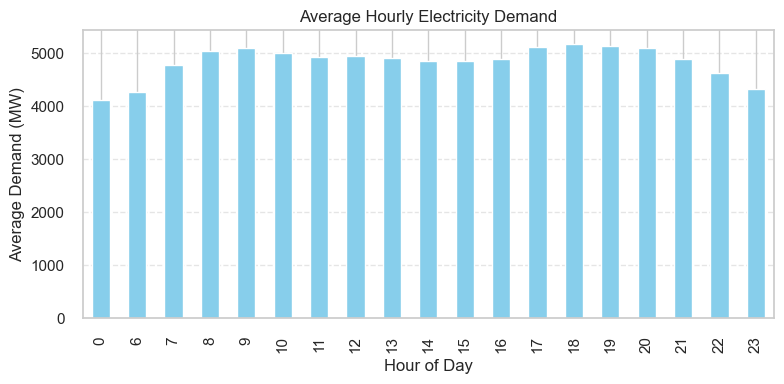

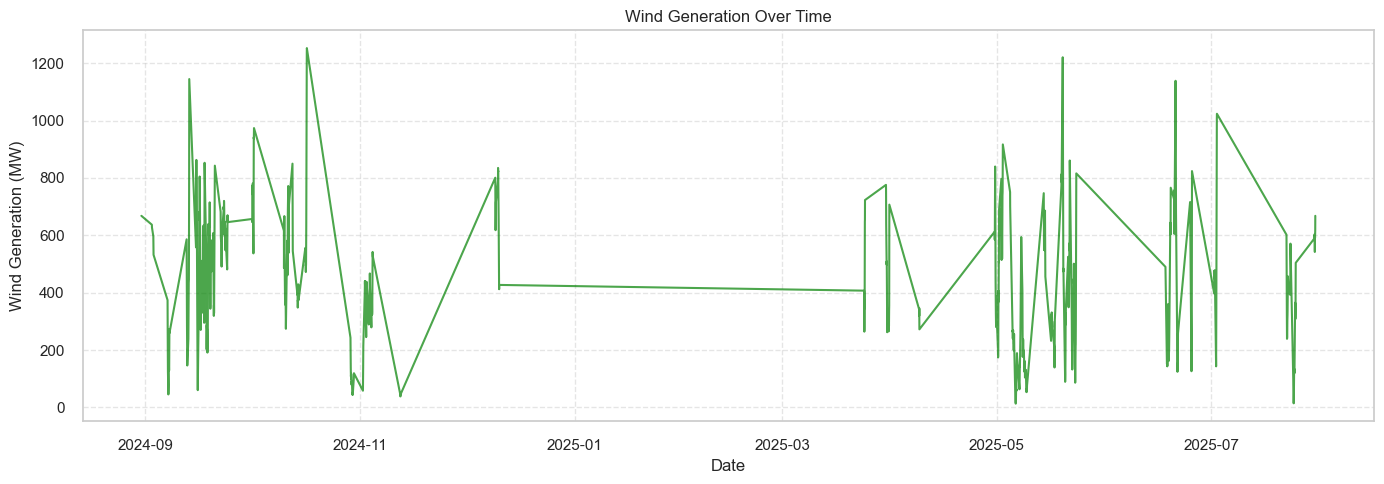

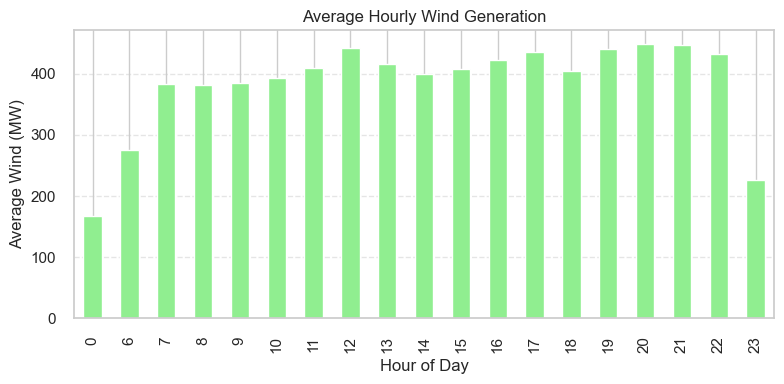

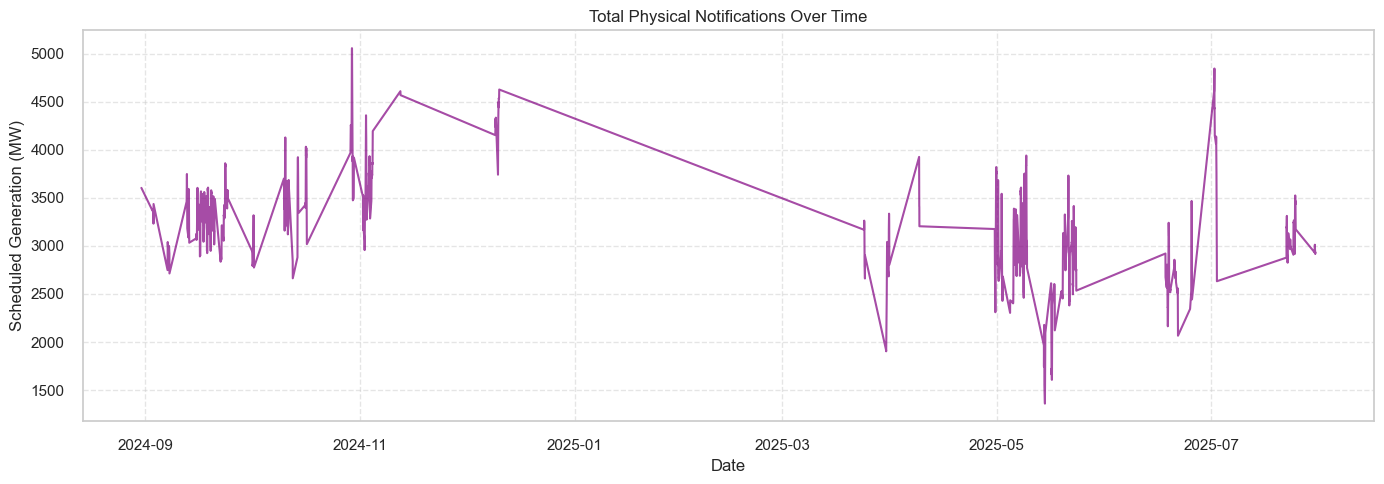

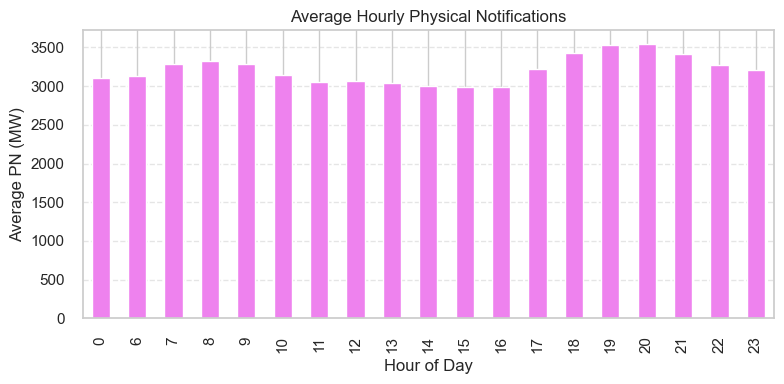

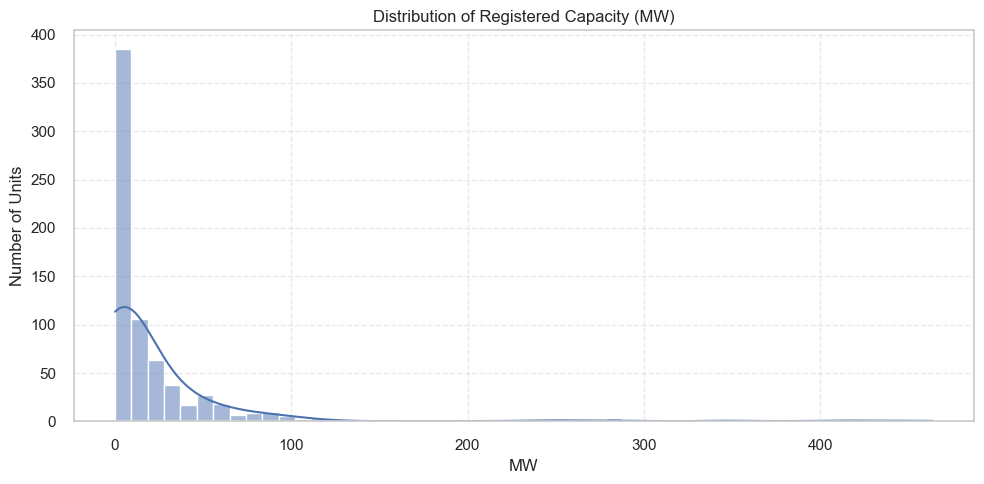

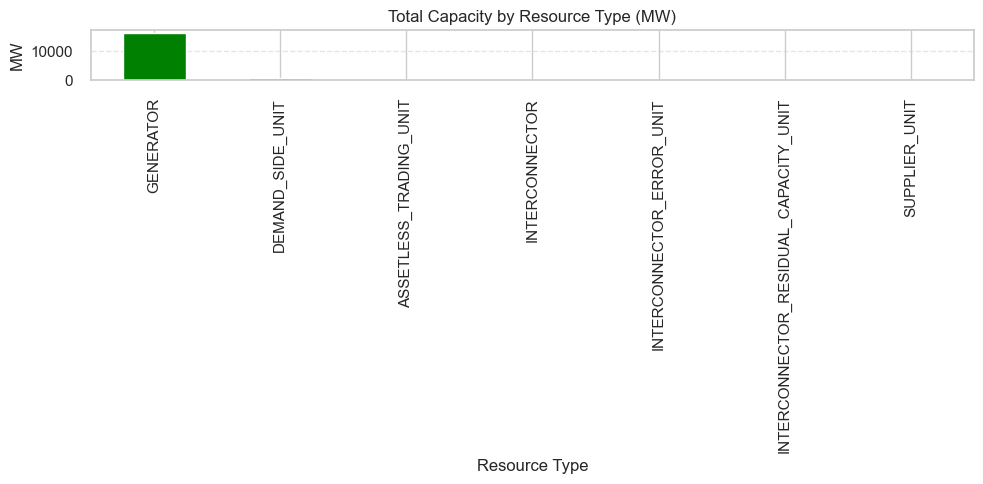

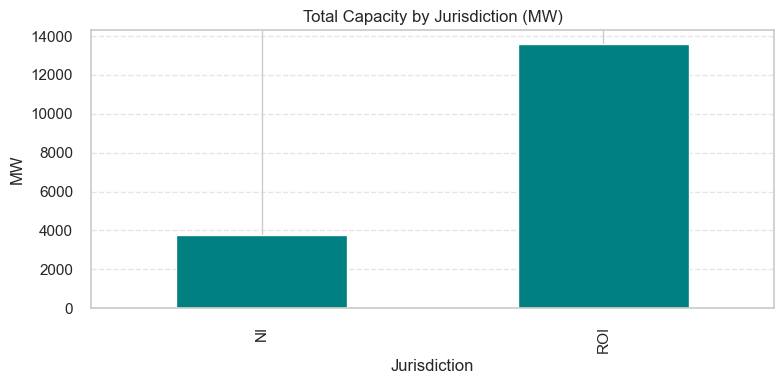

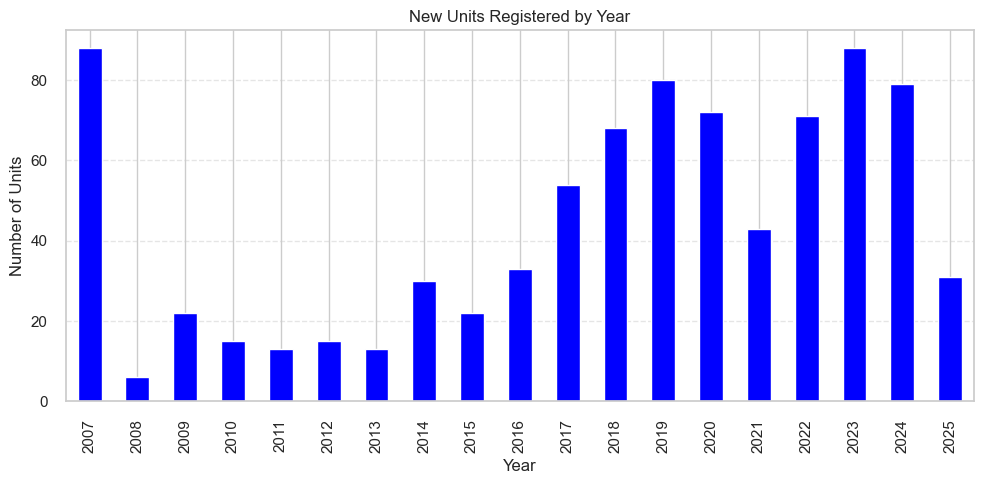

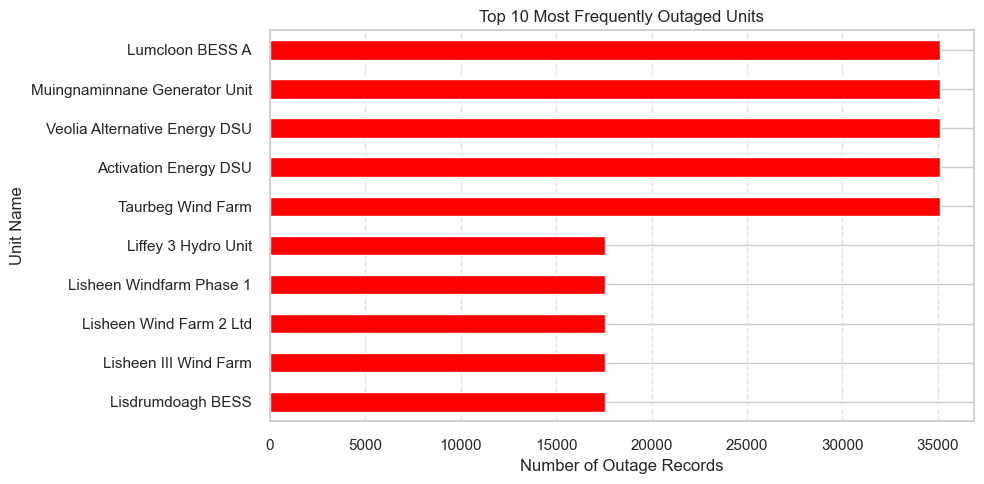

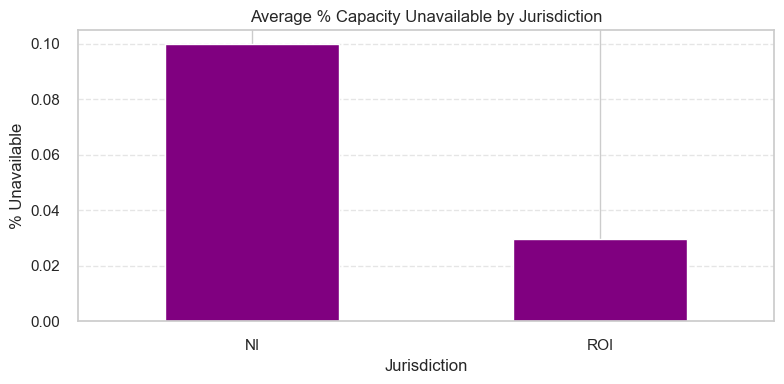

EDA completed: Demand, Wind, Price, Spreads, Capacity, Outages fully explored.


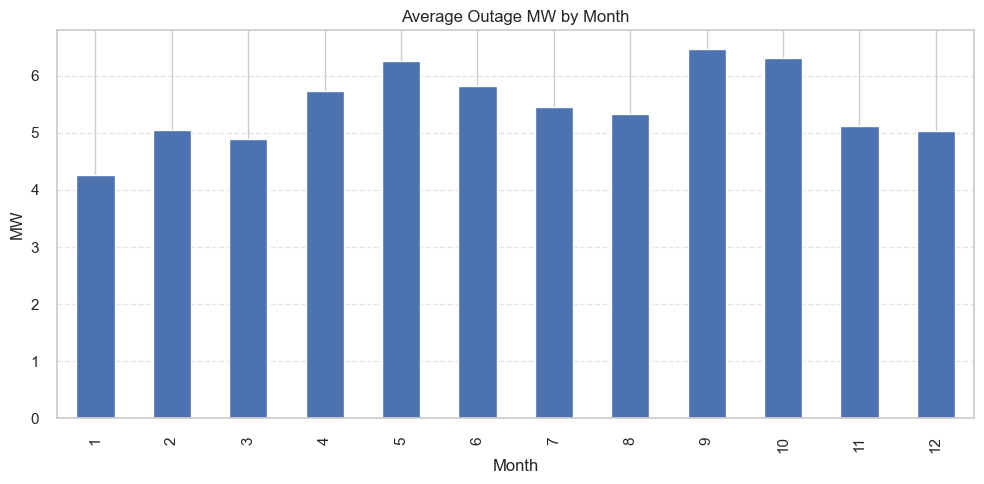

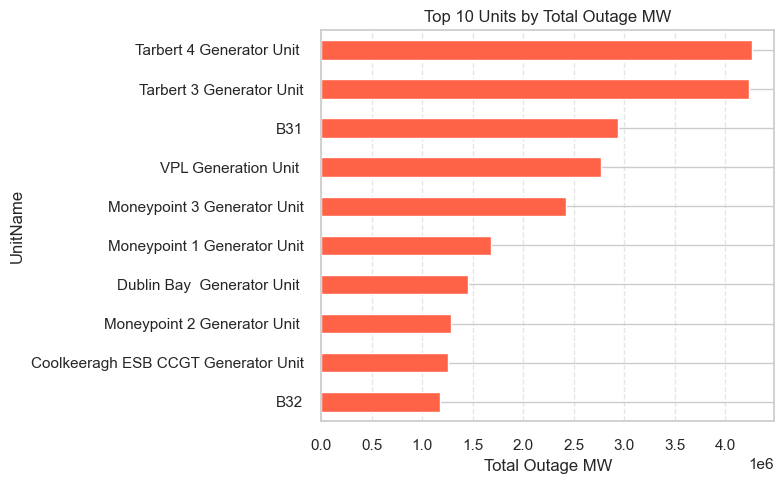

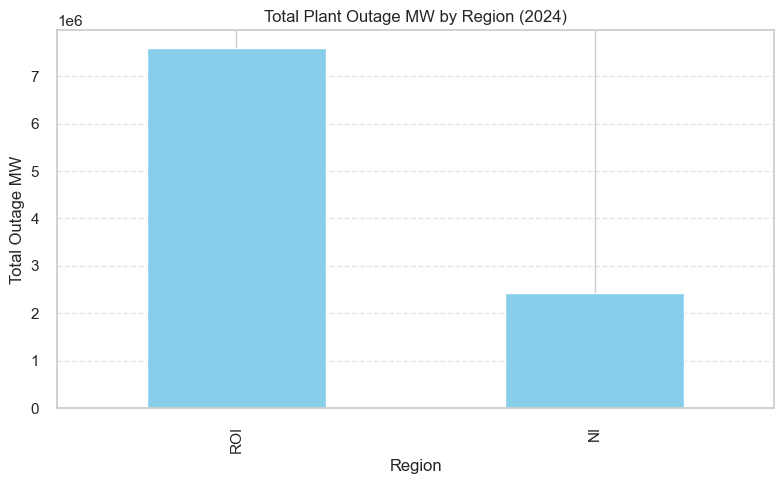

Jurisdiction
ROI    7584993
NI     2435952
Name: UnavailableCapacityMW, dtype: int64

Correlation with PriceDAM:
PriceDAM              1.000000
GB DAM Epex           0.773173
NetDemand             0.701039
DemandForecast        0.597086
TotalOutageMW        -0.135636
Meteo_ISEMWIND_DAM   -0.350160
Name: PriceDAM, dtype: float64

Spread_GB_Irish Statistics:
count    17618.000000
mean       -21.929352
std         36.124404
min       -271.019340
25%        -29.638600
50%        -10.330520
75%         -1.929000
max        277.716900
Name: Spread_GB_Irish, dtype: float64


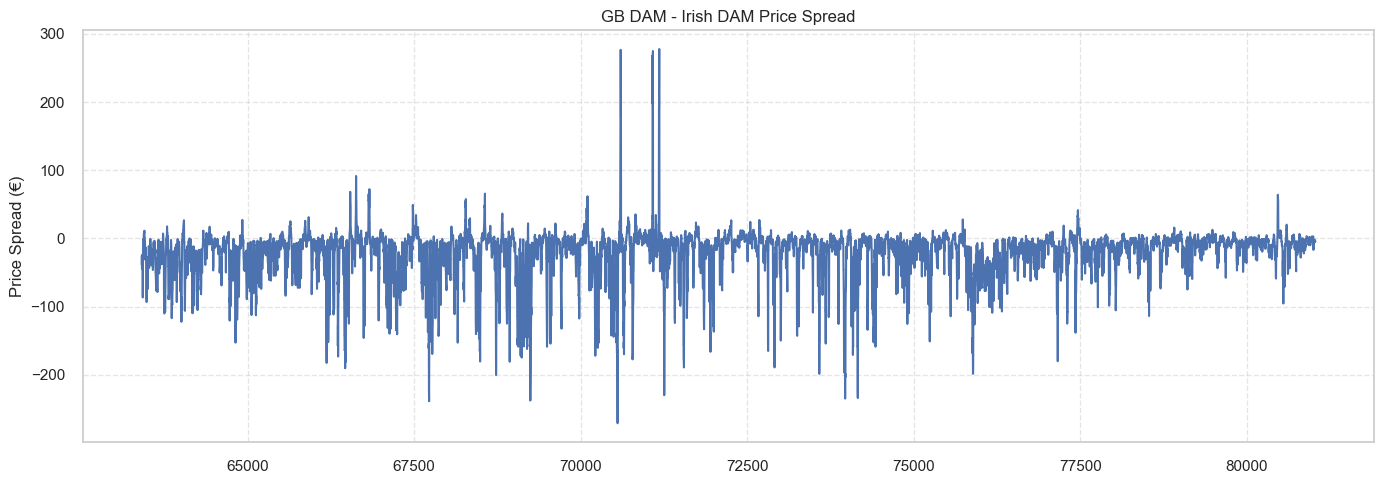


Correlation with Spread_GB_Irish:
Spread_GB_Irish       1.000000
Meteo_ISEMWIND_DAM    0.423629
TotalOutageMW        -0.038454
NetDemand            -0.554402
Name: Spread_GB_Irish, dtype: float64


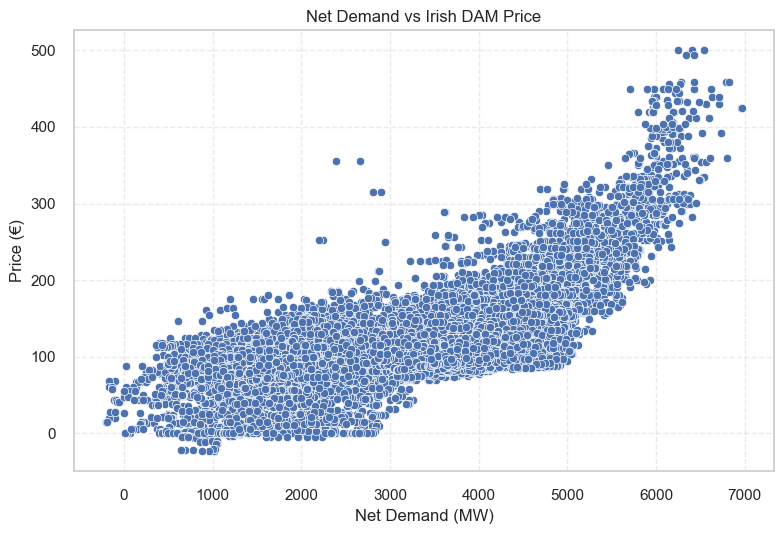

In [58]:
# ===========================================PART 4: EDA =========================================


# Set seaborn aesthetics
sns.set(style="whitegrid")

# --- 1 Basic shape and structure checks ---
print("Dataframe shape:", df.shape)
display(df.head(3))

# --- 2 Missing Data Analysis ---
missing_data = df.isnull().sum().to_frame(name='MissingCount')
missing_data['Total'] = len(df)
missing_data['MissingPercent'] = 100 * missing_data['MissingCount'] / missing_data['Total']
missing_data = missing_data[missing_data['MissingCount'] > 0].sort_values(by='MissingPercent', ascending=False)

print("Missing Data Summary:")
print(missing_data)

plt.figure(figsize=(10,8))
sns.barplot(x=missing_data['MissingPercent'], y=missing_data.index, palette='Reds_r')
plt.title("Percentage of Missing Values by Variable")
plt.xlabel("Percentage Missing")
plt.ylabel("Variable")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# --- 3 Distribution Plots for Forecast Data ---
columns_to_plot = [
    col for col in [
        'PriceDAM', 'Meteo_ISEMWIND_DAM', 'Meteo_ISEMDEMAND_DAM', 'DemandForecast', 'NetDemand', 'Spread_GB_Irish', 'TotalOutageMW'
    ] if col in df.columns
]

for col in columns_to_plot:
    plt.figure(figsize=(10,4))
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# --- 4 Correlation Heatmap for Forecast Data ---
plt.figure(figsize=(12,10))
sns.heatmap(df[columns_to_plot].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Forecast Data")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 5 Outlier Detection: Boxplots ---
for col in columns_to_plot:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# --- 6 Demand Analysis ---
if 'EirgridActualDemand' not in df.columns:
    df = df.merge(
    df_MLForecastActualInputs[['StartDateTime', 'EirgridActualDemand']],
        on='StartDateTime',
        how='left'
    )

plt.figure(figsize=(14,5))
plt.plot(df['StartDateTime'], df['EirgridActualDemand'], alpha=0.7)
plt.title("Electricity Demand Over Time")
plt.xlabel("Date")
plt.ylabel("Demand (MW)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

hourly_demand = df.groupby(df['StartDateTime'].dt.hour)['EirgridActualDemand'].mean()
hourly_demand.plot(kind='bar', figsize=(8,4), title='Average Hourly Electricity Demand', color='skyblue')
plt.ylabel("Average Demand (MW)")
plt.xlabel("Hour of Day")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 7 Wind Analysis ---

# Ensure EirgridActualWind is available in df for EDA
if 'EirgridActualWind' not in df.columns:
    df = df.merge(
        df_MLForecastActualInputs[['StartDateTime', 'EirgridActualWind']],
        on='StartDateTime',
        how='left'
    )


plt.figure(figsize=(14,5))
plt.plot(df['StartDateTime'], df['EirgridActualWind'], alpha=0.7, color='green')
plt.title("Wind Generation Over Time")
plt.xlabel("Date")
plt.ylabel("Wind Generation (MW)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

hourly_wind = df.groupby(df['StartDateTime'].dt.hour)['EirgridActualWind'].mean()
hourly_wind.plot(kind='bar', figsize=(8,4), title='Average Hourly Wind Generation', color='lightgreen')
plt.ylabel("Average Wind (MW)")
plt.xlabel("Hour of Day")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 8 Physical Notifications Analysis ---

# Ensure EirgridActualWind is available in df for EDA
if 'TotalPN' not in df.columns:
    df = df.merge(
        df_MLForecastActualInputs[['StartDateTime', 'TotalPN']],
        on='StartDateTime',
        how='left'
    )

plt.figure(figsize=(14,5))
plt.plot(df['StartDateTime'], df['TotalPN'], alpha=0.7, color='purple')
plt.title("Total Physical Notifications Over Time")
plt.xlabel("Date")
plt.ylabel("Scheduled Generation (MW)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

hourly_pn = df.groupby(df['StartDateTime'].dt.hour)['TotalPN'].mean()
hourly_pn.plot(kind='bar', figsize=(8,4), title='Average Hourly Physical Notifications', color='violet')
plt.ylabel("Average PN (MW)")
plt.xlabel("Hour of Day")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 9 Plant Info EDA: Capacity Distribution ---
plt.figure(figsize=(10,5))
sns.histplot(df_AllPlantInfo['RegisteredCapacity'].dropna(), bins=50, kde=True)
plt.title("Distribution of Registered Capacity (MW)")
plt.xlabel("MW")
plt.ylabel("Number of Units")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# --- 10 Capacity by Resource Type ---
resource_capacity = df_AllPlantInfo.groupby('ResourceType')['RegisteredCapacity'].sum().sort_values(ascending=False)
resource_capacity.plot(kind='bar', figsize=(10,5), color='green', title='Total Capacity by Resource Type (MW)')
plt.ylabel("MW")
plt.xlabel("Resource Type")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 11 Capacity by Jurisdiction ---
capacity_by_jurisdiction = df_AllPlantInfo.groupby('Jurisdiction')['RegisteredCapacity'].sum()
capacity_by_jurisdiction.plot(kind='bar', figsize=(8,4), color='teal', title='Total Capacity by Jurisdiction (MW)')
plt.ylabel("MW")
plt.xlabel("Jurisdiction")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 12 Units Registered Over Time ---
df_AllPlantInfo['EffectiveYear'] = df_AllPlantInfo['EffectiveDate'].dt.year
units_over_time = df_AllPlantInfo.groupby('EffectiveYear').size()
units_over_time.plot(kind='bar', figsize=(10,5), color='blue', title='New Units Registered by Year')
plt.ylabel("Number of Units")
plt.xlabel("Year")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 13 Outage Frequency by Unit ---
top_frequent_units = (
    df_Outages_enriched.groupby('UnitName')
    .size()
    .sort_values(ascending=False)
    .head(10)
)
top_frequent_units.plot(kind='barh', figsize=(10,5), color='red', title='Top 10 Most Frequently Outaged Units')
plt.xlabel('Number of Outage Records')
plt.ylabel('Unit Name')
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 14 % Capacity Unavailable by Jurisdiction ---
total_capacity = df_AllPlantInfo.groupby('Jurisdiction')['RegisteredCapacity'].sum()
avg_unavailable = df_Outages_enriched.groupby('Jurisdiction')['UnavailableCapacityMW'].mean()
percent_unavailable = (avg_unavailable / total_capacity) * 100

percent_unavailable.dropna().plot(kind='bar', figsize=(8,4), color='purple', title='Average % Capacity Unavailable by Jurisdiction')
plt.ylabel('% Unavailable')
plt.xlabel('Jurisdiction')
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("EDA completed: Demand, Wind, Price, Spreads, Capacity, Outages fully explored.")



# --- Monthly Average Outages by Month ---
df_Outages_enriched['Month'] = df_Outages_enriched['StartDateTime'].dt.month
monthly_outages = df_Outages_enriched.groupby('Month')['UnavailableCapacityMW'].mean()
monthly_outages.plot(kind='bar', figsize=(10, 5), title='Average Outage MW by Month')
plt.ylabel('MW')
plt.xlabel('Month')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# --- Top 10 Units by Total Outage MW ---
top_units = df_Outages_enriched.groupby('UnitName')['UnavailableCapacityMW'].sum().sort_values(ascending=False).head(10)
top_units.plot(kind='barh', figsize=(8, 5), color='tomato', title='Top 10 Units by Total Outage MW')
plt.xlabel('Total Outage MW')
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# --- Total Outage MW by Region (Jurisdiction) for 2024 ---
start_date = '2024-01-01'
end_date = '2025-01-01'
df_outages_filtered = df_Outages_enriched[
(df_Outages_enriched['StartDateTime'] >= start_date) &
(df_Outages_enriched['StartDateTime'] < end_date)
]
region_outages = (
df_outages_filtered
.groupby('Jurisdiction')['UnavailableCapacityMW']
.sum()
.sort_values(ascending=False)
)
region_outages.plot(
kind='bar',
figsize=(8, 5),
color='skyblue',
title='Total Plant Outage MW by Region (2024)'
)
plt.ylabel('Total Outage MW')
plt.xlabel('Region')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
print(region_outages)
# --- Correlation Analysis with PriceDAM ---
correlation_matrix = combined_prices_df[[
'PriceDAM', 'GB DAM Epex', 'NetDemand',
'TotalOutageMW', 'DemandForecast', 'Meteo_ISEMWIND_DAM'
]].corr()
print("\nCorrelation with PriceDAM:")
print(correlation_matrix['PriceDAM'].sort_values(ascending=False))
# --- Spread GB DAM vs Irish DAM Price ---
print("\nSpread_GB_Irish Statistics:")
print(combined_prices_df['Spread_GB_Irish'].describe())
combined_prices_df['Spread_GB_Irish'].plot(figsize=(14, 5), title='GB DAM - Irish DAM Price Spread')
plt.ylabel('Price Spread (€)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
spread_corr = combined_prices_df[[
'Spread_GB_Irish', 'TotalOutageMW', 'NetDemand', 'Meteo_ISEMWIND_DAM'
]].corr()
print("\nCorrelation with Spread_GB_Irish:")
print(spread_corr['Spread_GB_Irish'].sort_values(ascending=False))
# --- Net Demand vs Irish DAM Price Scatterplot ---
sns.scatterplot(data=combined_prices_df, x='NetDemand', y='PriceDAM')
plt.title('Net Demand vs Irish DAM Price')
plt.xlabel('Net Demand (MW)')
plt.ylabel('Price (€)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



In [44]:
#--------------------------------------------------------------------------------------------------------------------PART 5: MODELLING--------------------------------------------------------------------------------------------------------------

 XGBoost Baseline - DAM: MAE=20.51, RMSE=27.65, R²=0.25


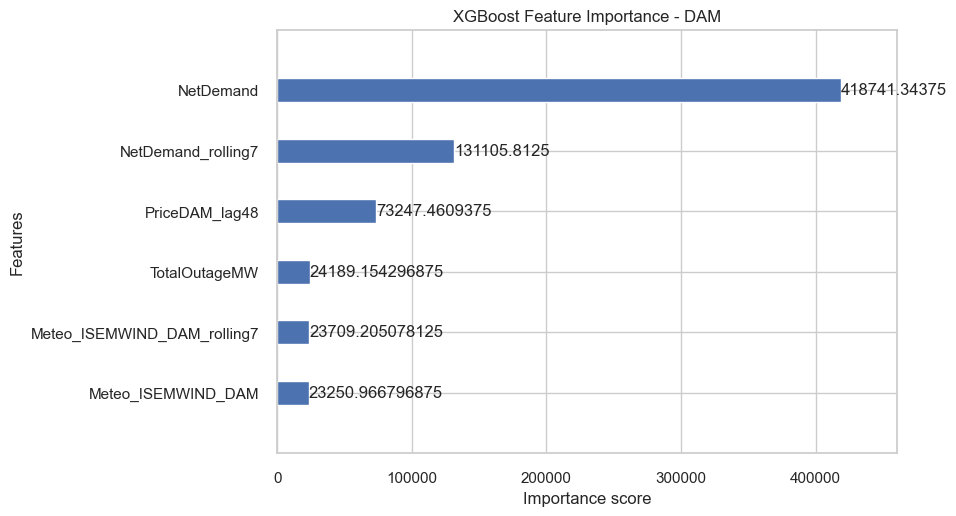

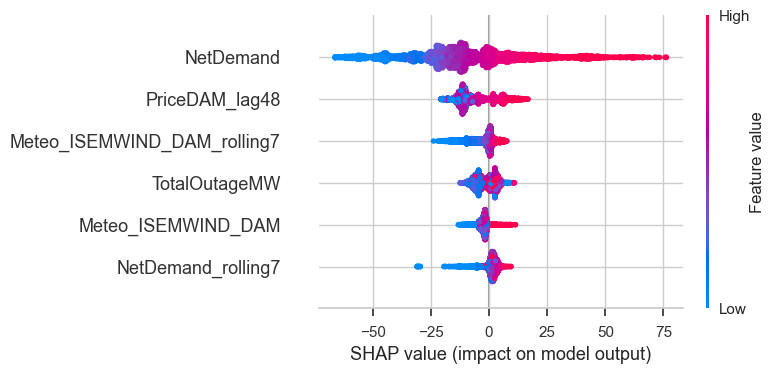

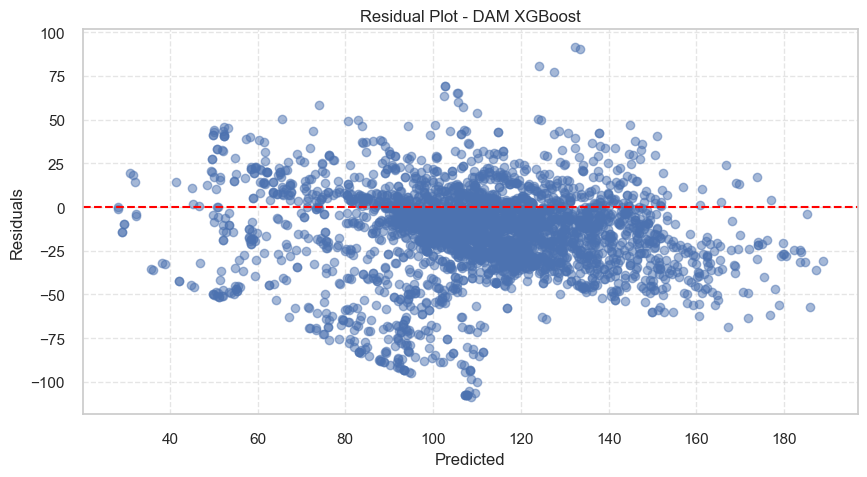

LightGBM - DAM: MAE=20.34, RMSE=27.55, R²=0.26


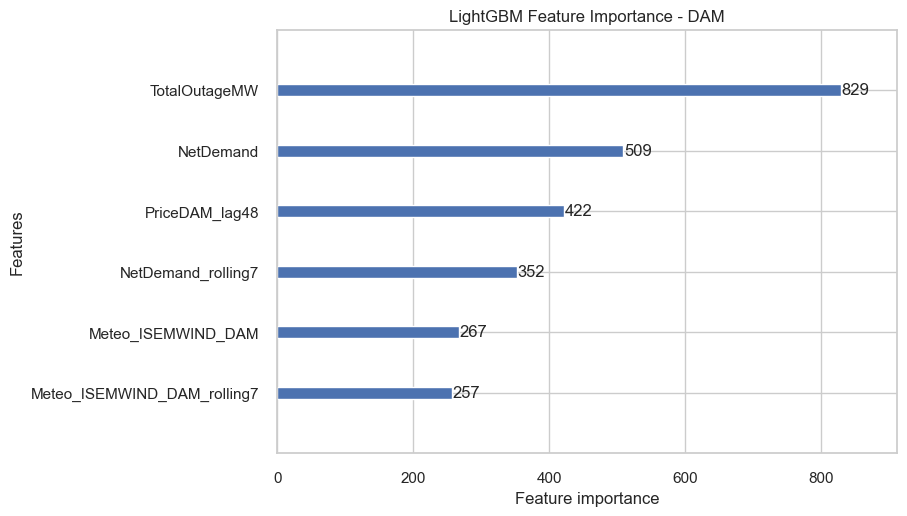

 CatBoost - DAM: MAE=20.46, RMSE=27.65, R²=0.25


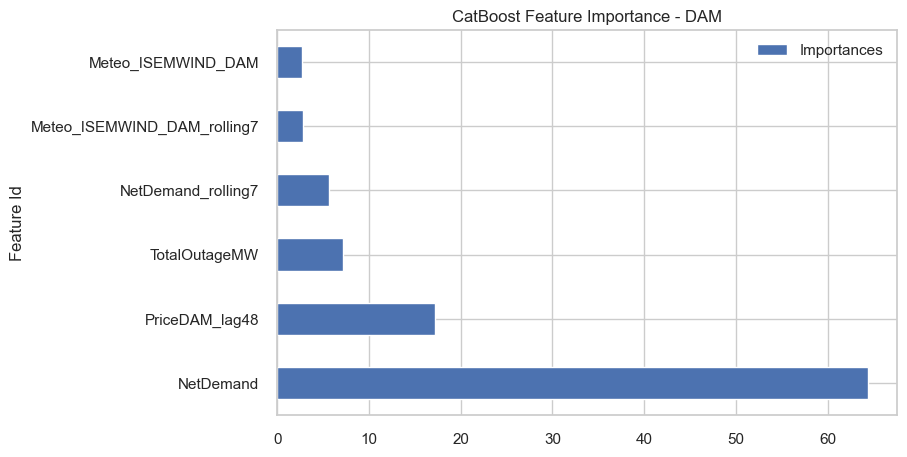

Fitting 3 folds for each of 10 candidates, totalling 30 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


 PyCaret Leaderboard:
              Model     MAE       MSE     RMSE      R2   RMSLE    MAPE
0  Voting Regressor  7.9044  116.9576  10.8147  0.8857  0.4422  0.4224

DAM Predictions Head:
       NetDemand  Meteo_ISEMWIND_DAM  TotalOutageMW  NetDemand_rolling7  Meteo_ISEMWIND_DAM_rolling7  PriceDAM_lag48  PriceDAM  prediction_label
77477     1309.0              2255.0         2008.0         1219.571411                  2743.857178      123.360001     13.04         31.567549
77478     1326.0              2144.0         2008.0         1235.857178                  2592.857178      116.000000      7.12         28.181190
77479     1343.0              2087.0         2008.0         1249.571411                  2456.428467      116.000000      7.12         28.719231
77480     1353.0              2084.0         2008.0         1262.571411                  2345.000000      141.029999      5.43         32.047742
77481     1294.0              2134.0         2008.0         1291.285767                

In [10]:
# ==================== PART 5: MODELLING - DAM PRICE ====================

features = [
    'NetDemand',
    'Meteo_ISEMWIND_DAM',
    'TotalOutageMW',
    'NetDemand_rolling7',
    'Meteo_ISEMWIND_DAM_rolling7',
    'PriceDAM_lag48'
]
target = 'PriceDAM'

df_mod = combined_prices_df[features + [target]].dropna()
X = df_mod[features]
y = df_mod[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- 1 XGBoost Baseline ---
xgb_model = xgb.XGBRegressor(
    n_estimators=200, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror', random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f" XGBoost Baseline - DAM: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.2f}")

xgb.plot_importance(xgb_model, importance_type='gain', height=0.4)
plt.title('XGBoost Feature Importance - DAM')
plt.show()

# SHAP analysis
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

# Residual diagnostics
residuals = y_test - y_pred
plt.figure(figsize=(10,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot - DAM XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- 2 LightGBM ---
lgb_model = lgb.LGBMRegressor(
    n_estimators=200, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    verbosity=-1
)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)
print(f"LightGBM - DAM: MAE={mae_lgb:.2f}, RMSE={rmse_lgb:.2f}, R²={r2_lgb:.2f}")

lgb.plot_importance(lgb_model, max_num_features=10)
plt.title('LightGBM Feature Importance - DAM')
plt.show()

# --- 3 CatBoost ---
cat_model = cb.CatBoostRegressor(
    iterations=200, learning_rate=0.05, depth=4,
    verbose=0, random_state=42
)
cat_model.fit(X_train, y_train)
y_pred_cb = cat_model.predict(X_test)

mae_cb = mean_absolute_error(y_test, y_pred_cb)
rmse_cb = np.sqrt(mean_squared_error(y_test, y_pred_cb))
r2_cb = r2_score(y_test, y_pred_cb)
print(f" CatBoost - DAM: MAE={mae_cb:.2f}, RMSE={rmse_cb:.2f}, R²={r2_cb:.2f}")

cb_importance = cat_model.get_feature_importance(prettified=True)
cb_importance.plot.barh(x='Feature Id', y='Importances', figsize=(8,5), title='CatBoost Feature Importance - DAM')
plt.show()

# --- 4 PyCaret AutoML ---
from pycaret.regression import *

df_pycaret = df_mod.copy()

exp = setup(
    data=df_pycaret, target=target, session_id=42,
    train_size=0.8, fold_strategy='timeseries', fold=3,
    numeric_features=features, data_split_shuffle=False, fold_shuffle=False,
    verbose=False, use_gpu=True
)

best_models = compare_models(n_select=3, sort='RMSE')
blended = blend_models(estimator_list=best_models)
tuned_best = tune_model(blended, optimize='RMSE')
evaluate_model(tuned_best)
final_model = finalize_model(tuned_best)
predictions = predict_model(final_model)
leaderboard = pull()

print("\n PyCaret Leaderboard:")
print(leaderboard)

# --- Evaluation of PyCaret Voting Regressor ---
print("\nDAM Predictions Head:")
print(predictions.head())

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_true = predictions['PriceDAM']
y_pred = predictions['prediction_label']

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print(f"\n PyCaret Voting Regressor - DAM Evaluation:\nMAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.2f}")



print("\n DAM Modelling complete.\n")


[I 2025-08-14 12:34:51,394] A new study created in memory with name: no-name-95634019-6164-467d-b46b-31660ec56a6f
[I 2025-08-14 12:34:51,507] Trial 0 finished with value: 30.596574953593713 and parameters: {'lambda': 0.03148911647956861, 'alpha': 6.351221010640703, 'colsample_bytree': 0.8659969709057025, 'subsample': 0.7993292420985183, 'learning_rate': 0.01700037298921102, 'max_depth': 4, 'n_estimators': 117}. Best is trial 0 with value: 30.596574953593713.



 Running Optuna XGBoost Tuning - DAM


[I 2025-08-14 12:34:51,991] Trial 1 finished with value: 29.543094361618618 and parameters: {'lambda': 2.9154431891537547, 'alpha': 0.2537815508265665, 'colsample_bytree': 0.8540362888980227, 'subsample': 0.5102922471479012, 'learning_rate': 0.2708160864249968, 'max_depth': 9, 'n_estimators': 163}. Best is trial 1 with value: 29.543094361618618.
[I 2025-08-14 12:34:52,296] Trial 2 finished with value: 27.748384159750483 and parameters: {'lambda': 0.005337032762603957, 'alpha': 0.00541524411940254, 'colsample_bytree': 0.6521211214797689, 'subsample': 0.762378215816119, 'learning_rate': 0.04345454109729477, 'max_depth': 5, 'n_estimators': 284}. Best is trial 2 with value: 27.748384159750483.
[I 2025-08-14 12:34:52,528] Trial 3 finished with value: 28.719830567683555 and parameters: {'lambda': 0.003613894271216527, 'alpha': 0.01474275315991467, 'colsample_bytree': 0.6831809216468459, 'subsample': 0.728034992108518, 'learning_rate': 0.14447746112718687, 'max_depth': 4, 'n_estimators': 254}

Optuna Best Params (DAM): {'lambda': 9.228025470857208, 'alpha': 1.8156180453136113, 'colsample_bytree': 0.5019508154106136, 'subsample': 0.6297161531334539, 'learning_rate': 0.03356323960128495, 'max_depth': 4, 'n_estimators': 361}
Optuna Best RMSE (DAM): 27.201085694519584
Optuna Tuned XGBoost - DAM: MAE=20.15, RMSE=27.20, R²=0.28


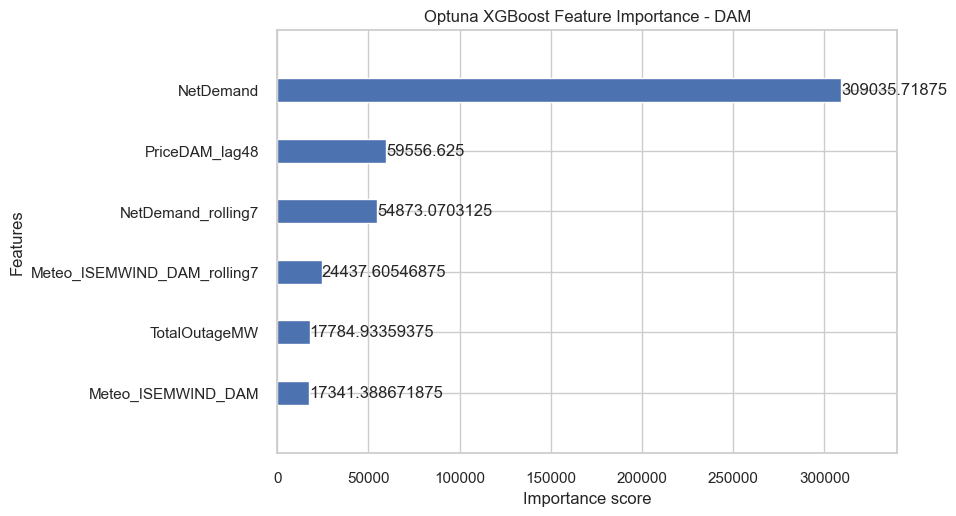

 96%|=================== | 3369/3504 [00:14<00:00]       

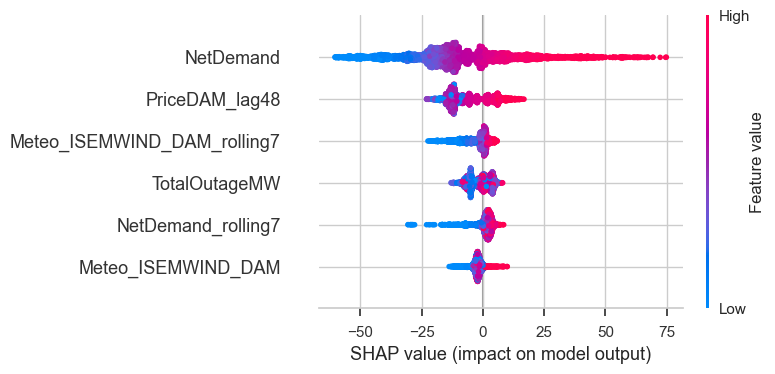

[I 2025-08-14 12:35:17,868] A new study created in memory with name: no-name-923cf4a3-5d26-4ea1-bd6e-6fa3c48d7d53
[I 2025-08-14 12:35:18,197] Trial 0 finished with value: 27.165118629525182 and parameters: {'lambda_l1': 5.167482256977172e-07, 'lambda_l2': 8.914948151779841, 'num_leaves': 126, 'feature_fraction': 0.749454012712771, 'bagging_fraction': 0.7496019255102168, 'bagging_freq': 6, 'min_child_samples': 74, 'learning_rate': 0.020417761736873628, 'max_depth': 7, 'n_estimators': 204}. Best is trial 0 with value: 27.165118629525182.
[I 2025-08-14 12:35:18,482] Trial 1 finished with value: 33.835657501826624 and parameters: {'lambda_l1': 2.8371398864510527e-08, 'lambda_l2': 3.938346321667597e-07, 'num_leaves': 52, 'feature_fraction': 0.9503220048064474, 'bagging_fraction': 0.8732390958269105, 'bagging_freq': 3, 'min_child_samples': 35, 'learning_rate': 0.006713220180574073, 'max_depth': 8, 'n_estimators': 129}. Best is trial 0 with value: 27.165118629525182.
[I 2025-08-14 12:35:18,83

Optuna Best Params (LightGBM DAM): {'lambda_l1': 2.6074386150705796e-08, 'lambda_l2': 1.5224968396643432e-05, 'num_leaves': 146, 'feature_fraction': 0.5395062579729054, 'bagging_fraction': 0.6047712009598967, 'bagging_freq': 4, 'min_child_samples': 14, 'learning_rate': 0.01699238068378854, 'max_depth': 7, 'n_estimators': 379}
Optuna Best RMSE (LightGBM DAM): 26.645766497602995
Optuna Tuned LightGBM - DAM: MAE=20.04, RMSE=26.65, R²=0.31


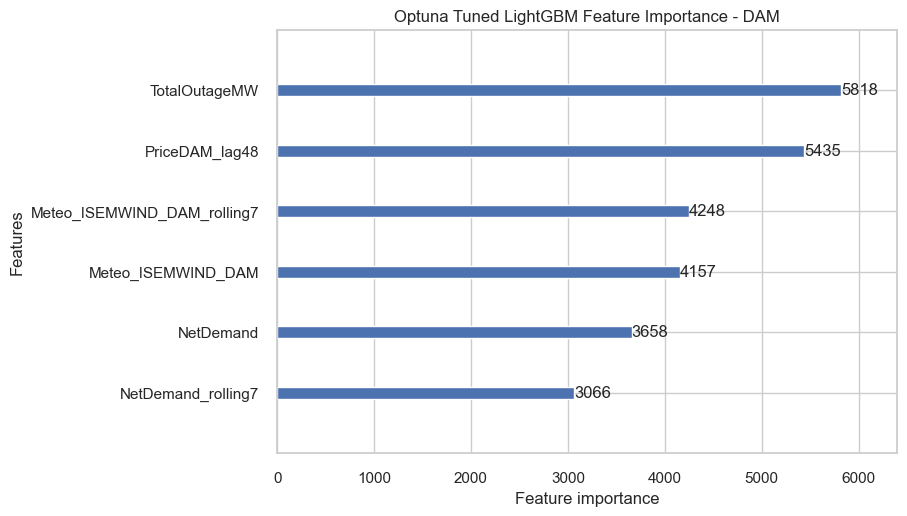

[I 2025-08-14 12:35:47,506] A new study created in memory with name: no-name-47e26217-4bc2-4be2-845d-616fd89749d1
[I 2025-08-14 12:35:49,274] Trial 0 finished with value: 27.76104063081615 and parameters: {'depth': 8, 'learning_rate': 0.015334569818616927, 'l2_leaf_reg': 0.15426415153991804, 'iterations': 278}. Best is trial 0 with value: 27.76104063081615.
[I 2025-08-14 12:35:49,891] Trial 1 finished with value: 28.149044001063004 and parameters: {'depth': 4, 'learning_rate': 0.0325676532838038, 'l2_leaf_reg': 0.00018987391196343122, 'iterations': 227}. Best is trial 0 with value: 27.76104063081615.
[I 2025-08-14 12:35:52,822] Trial 2 finished with value: 27.102973984242855 and parameters: {'depth': 8, 'learning_rate': 0.02376078820481457, 'l2_leaf_reg': 0.01797725526960042, 'iterations': 475}. Best is trial 2 with value: 27.102973984242855.
[I 2025-08-14 12:35:54,138] Trial 3 finished with value: 28.284155236481375 and parameters: {'depth': 7, 'learning_rate': 0.01314057091192303, 'l

Optuna Best Params (CatBoost DAM): {'depth': 9, 'learning_rate': 0.02345408292502437, 'l2_leaf_reg': 3.8376039671487767, 'iterations': 477}
Optuna Best RMSE (CatBoost DAM): 26.692850014178486
Optuna Tuned CatBoost - DAM: MAE=19.89, RMSE=26.69, R²=0.30


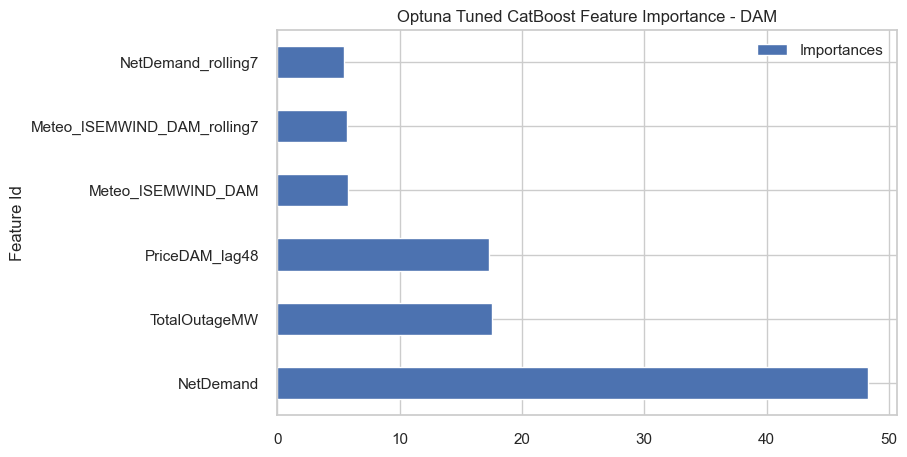

In [11]:
# 1 Optuna Tuning for XGBOOST

print("\n Running Optuna XGBoost Tuning - DAM")

def objective_dam(trial):
    params = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'random_state': 42,
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study_dam = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_dam.optimize(objective_dam, n_trials=30)

print("Optuna Best Params (DAM):", study_dam.best_params)
print("Optuna Best RMSE (DAM):", study_dam.best_value)

# Train best model
best_params_dam = study_dam.best_params
best_params_dam.update({'objective':'reg:squarederror', 'random_state':42})

model_dam_optuna = xgb.XGBRegressor(**best_params_dam)
model_dam_optuna.fit(X_train, y_train)

# Evaluate
y_pred_optuna = model_dam_optuna.predict(X_test)
mae_optuna = mean_absolute_error(y_test, y_pred_optuna)
rmse_optuna = np.sqrt(mean_squared_error(y_test, y_pred_optuna))
r2_optuna = r2_score(y_test, y_pred_optuna)

print(f"Optuna Tuned XGBoost - DAM: MAE={mae_optuna:.2f}, RMSE={rmse_optuna:.2f}, R²={r2_optuna:.2f}")

# Plot feature importance
xgb.plot_importance(model_dam_optuna, importance_type='gain', height=0.4)
plt.title('Optuna XGBoost Feature Importance - DAM')
plt.show()

# SHAP
explainer_optuna = shap.Explainer(model_dam_optuna, X_train)
shap_values_optuna = explainer_optuna(X_test)
shap.summary_plot(shap_values_optuna, X_test)


# 2 Optuna Tuning for LightGBM

# 1 Define the Optuna objective function
def objective_lgb(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500)
    }
    model = lgb.LGBMRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    return rmse

# 2 Run the Optuna study
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=50)

# 3 Retrieve best parameters and fit the final model
best_params_lgb = study_lgb.best_params
print("Optuna Best Params (LightGBM DAM):", best_params_lgb)
print("Optuna Best RMSE (LightGBM DAM):", study_lgb.best_value)

# 4 Fit final model and evaluate
lgb_tuned = lgb.LGBMRegressor(**best_params_lgb, random_state=42)
lgb_tuned.fit(X_train, y_train)
y_pred_lgb_tuned = lgb_tuned.predict(X_test)

mae_lgb_tuned = mean_absolute_error(y_test, y_pred_lgb_tuned)
rmse_lgb_tuned = mean_squared_error(y_test, y_pred_lgb_tuned, squared=False)
r2_lgb_tuned = r2_score(y_test, y_pred_lgb_tuned)

print(f"Optuna Tuned LightGBM - DAM: MAE={mae_lgb_tuned:.2f}, RMSE={rmse_lgb_tuned:.2f}, R²={r2_lgb_tuned:.2f}")

# 5 Plot feature importance
lgb.plot_importance(lgb_tuned, max_num_features=10)
plt.title('Optuna Tuned LightGBM Feature Importance - DAM')
plt.show()



# 3 Optuna Tuning for CatBoost

def objective_cb(trial):
    params = {
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 100),
        'iterations': trial.suggest_int('iterations', 100, 500)
    }
    model = cb.CatBoostRegressor(**params, verbose=0, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    return rmse

study_cb = optuna.create_study(direction='minimize')
study_cb.optimize(objective_cb, n_trials=50)

print("Optuna Best Params (CatBoost DAM):", study_cb.best_params)
print("Optuna Best RMSE (CatBoost DAM):", study_cb.best_value)

# Fit the best model
best_params_cb = study_cb.best_params
cb_tuned = cb.CatBoostRegressor(**best_params_cb, verbose=0, random_state=42)
cb_tuned.fit(X_train, y_train)
y_pred_cb_tuned = cb_tuned.predict(X_test)

mae_cb_tuned = mean_absolute_error(y_test, y_pred_cb_tuned)
rmse_cb_tuned = mean_squared_error(y_test, y_pred_cb_tuned, squared=False)
r2_cb_tuned = r2_score(y_test, y_pred_cb_tuned)
print(f"Optuna Tuned CatBoost - DAM: MAE={mae_cb_tuned:.2f}, RMSE={rmse_cb_tuned:.2f}, R²={r2_cb_tuned:.2f}")

cb_importance_tuned = cb_tuned.get_feature_importance(prettified=True)
cb_importance_tuned.plot.barh(x='Feature Id', y='Importances', figsize=(8,5), title='Optuna Tuned CatBoost Feature Importance - DAM')
plt.show()


 XGBoost - BM: MAE=66.39, RMSE=87.56, R²=0.06


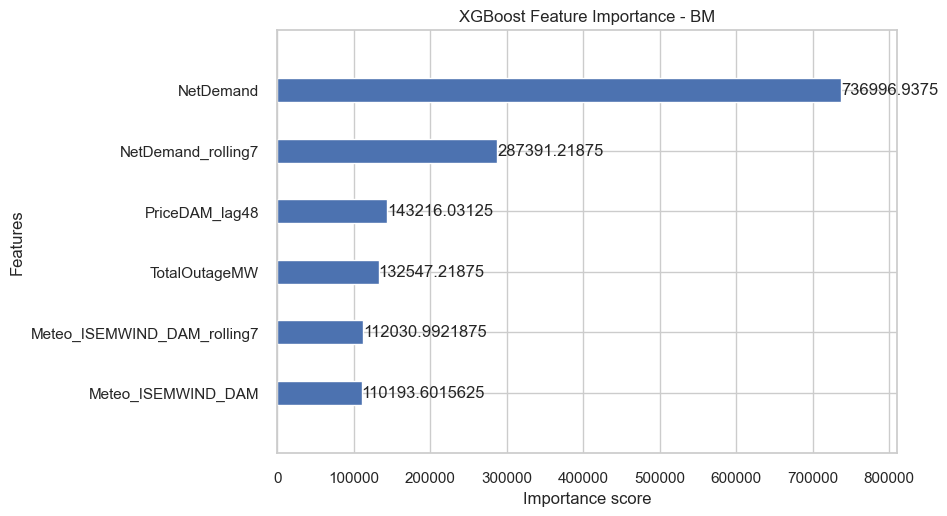

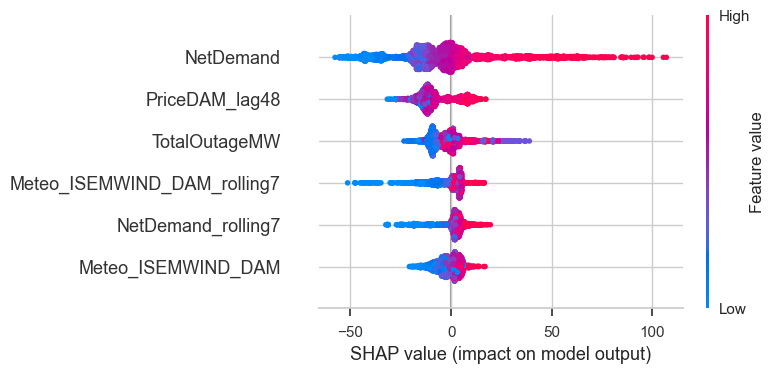

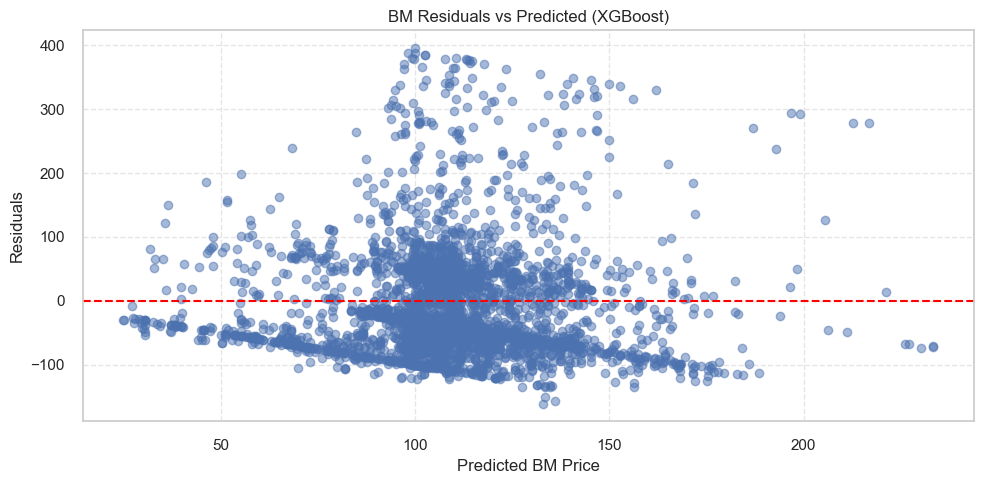

 LightGBM - BM: MAE=66.39, RMSE=87.61, R²=0.06


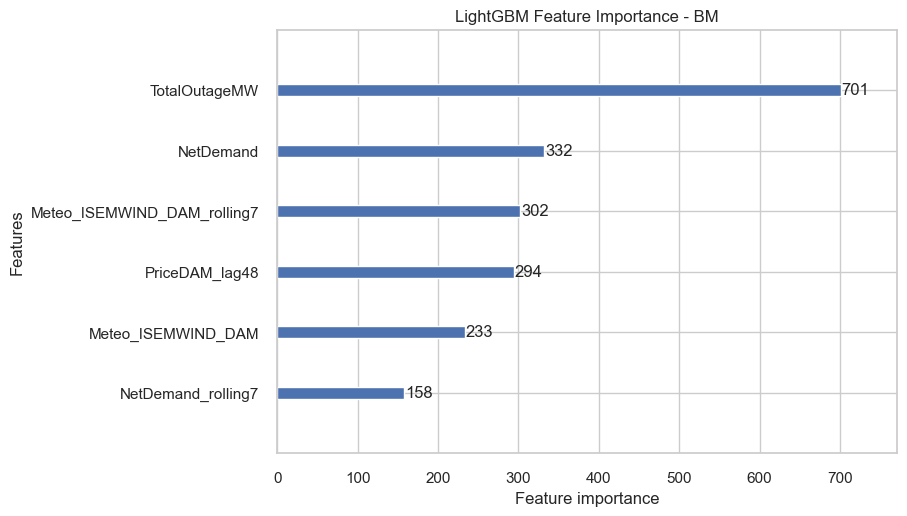

 CatBoost - BM: MAE=66.97, RMSE=87.96, R²=0.05


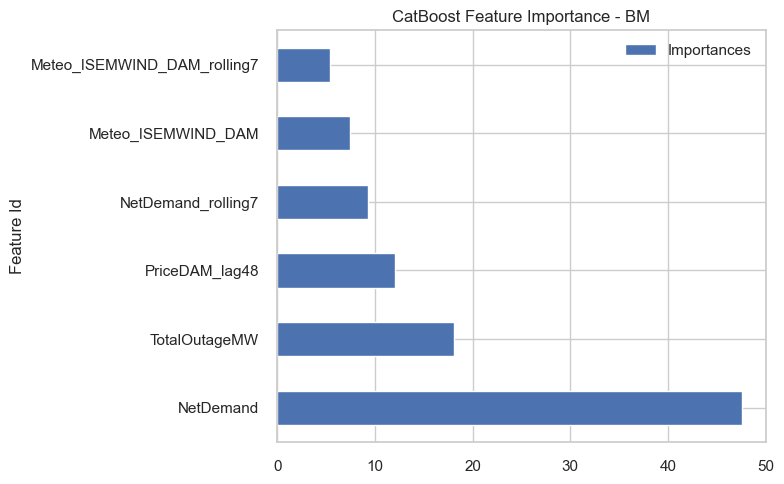


 PyCaret AutoML - BM Modelling


Fitting 3 folds for each of 10 candidates, totalling 30 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


 PyCaret Leaderboard - BM:
              Model      MAE        MSE     RMSE      R2   RMSLE    MAPE
0  Voting Regressor  67.0873  7737.5472  87.9633  0.0522  1.4349  9.8695

 BM Predictions Head:
       NetDemand  Meteo_ISEMWIND_DAM  TotalOutageMW  NetDemand_rolling7  Meteo_ISEMWIND_DAM_rolling7  PriceDAM_lag48  PriceImbalance  prediction_label
77455     1114.0              3039.0         2008.0         1745.857178                  2493.714355           -5.08            0.00         20.305490
77456      960.0              3128.0         2008.0         1536.142822                  2684.428467           -5.17           -4.68         16.894805
77457      881.0              3198.0         2008.0         1345.428589                  2848.714355           -5.17          -13.94         15.933820
77458      858.0              3273.0         2008.0         1186.571411                  2985.285645           -5.17            0.00         16.739411
77459      856.0              3351.0         200

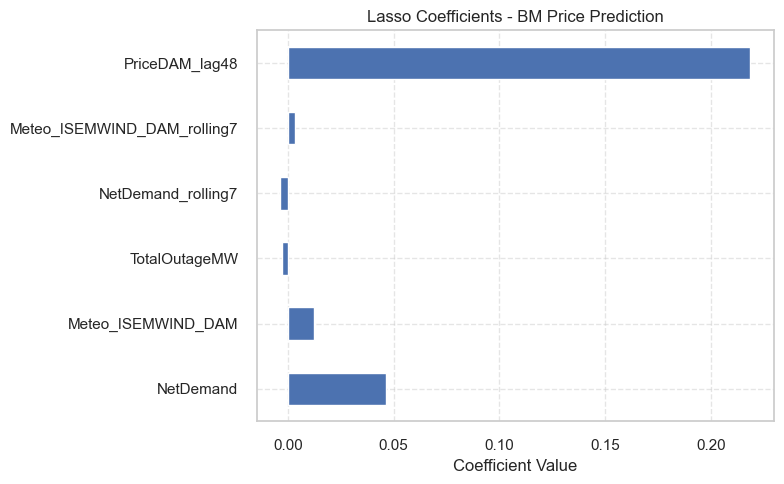

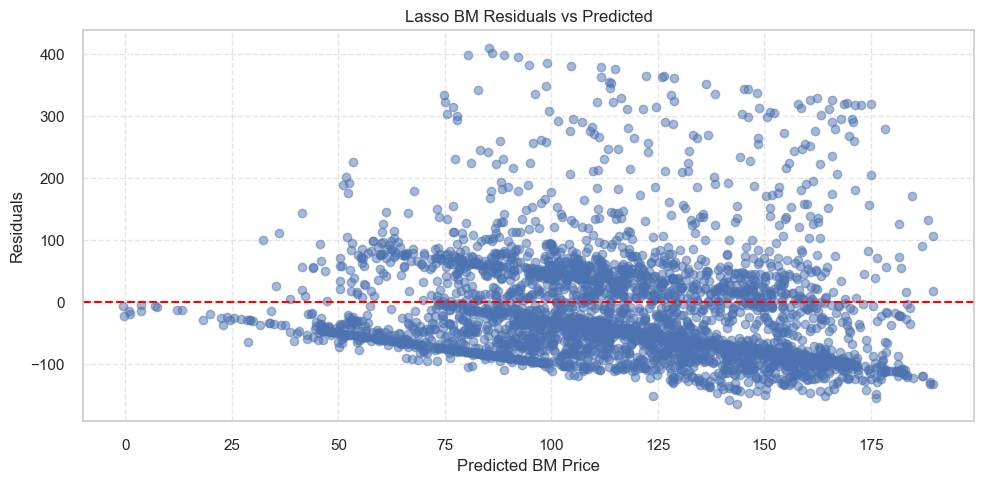


 BM Modelling complete.



In [12]:
# ==================== PART 5: MODELLING - BM PRICE ====================

# --- Ensure PriceImbalance is available ---
if 'PriceImbalance' not in combined_prices_df.columns:
    combined_prices_df = pd.merge(
        combined_prices_df,
        df_MLForecastActualInputs[['StartDateTime', 'PriceImbalance']],
        on='StartDateTime',
        how='left'
    )
    print(" Merged 'PriceImbalance' into combined_prices_df for BM modelling.")

# --- 1 Feature and target setup ---
features = [
    'NetDemand',
    'Meteo_ISEMWIND_DAM',
    'TotalOutageMW',
    'NetDemand_rolling7',
    'Meteo_ISEMWIND_DAM_rolling7',
    'PriceDAM_lag48'
]
target = 'PriceImbalance'

df_mod = combined_prices_df[features + [target]].dropna()
X = df_mod[features]
y = df_mod[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- 2 XGBoost Baseline ---
xgb_model_bm = xgb.XGBRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)
xgb_model_bm.fit(X_train, y_train)
y_pred_bm = xgb_model_bm.predict(X_test)

mae_bm = mean_absolute_error(y_test, y_pred_bm)
rmse_bm = np.sqrt(mean_squared_error(y_test, y_pred_bm))
r2_bm = r2_score(y_test, y_pred_bm)
print(f" XGBoost - BM: MAE={mae_bm:.2f}, RMSE={rmse_bm:.2f}, R²={r2_bm:.2f}")

xgb.plot_importance(xgb_model_bm, importance_type='gain', height=0.4)
plt.title('XGBoost Feature Importance - BM')
plt.show()

# SHAP Analysis
explainer_bm = shap.Explainer(xgb_model_bm, X_train)
shap_values_bm = explainer_bm(X_test)
shap.summary_plot(shap_values_bm, X_test)

# Residual Diagnostics
residuals_bm = y_test - y_pred_bm
plt.figure(figsize=(10,5))
plt.scatter(y_pred_bm, residuals_bm, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.title("BM Residuals vs Predicted (XGBoost)")
plt.xlabel("Predicted BM Price")
plt.ylabel("Residuals")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 3 LightGBM ---
lgb_model_bm = lgb.LGBMRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=-1
)
lgb_model_bm.fit(X_train, y_train)
y_pred_lgb_bm = lgb_model_bm.predict(X_test)

mae_lgb_bm = mean_absolute_error(y_test, y_pred_lgb_bm)
rmse_lgb_bm = np.sqrt(mean_squared_error(y_test, y_pred_lgb_bm))
r2_lgb_bm = r2_score(y_test, y_pred_lgb_bm)
print(f" LightGBM - BM: MAE={mae_lgb_bm:.2f}, RMSE={rmse_lgb_bm:.2f}, R²={r2_lgb_bm:.2f}")

lgb.plot_importance(lgb_model_bm, max_num_features=10)
plt.title('LightGBM Feature Importance - BM')
plt.show()

# --- 4 CatBoost ---
cat_model_bm = cb.CatBoostRegressor(
    iterations=150,
    learning_rate=0.05,
    depth=4,
    verbose=0,
    random_state=42
)
cat_model_bm.fit(X_train, y_train)
y_pred_cb_bm = cat_model_bm.predict(X_test)

mae_cb_bm = mean_absolute_error(y_test, y_pred_cb_bm)
rmse_cb_bm = np.sqrt(mean_squared_error(y_test, y_pred_cb_bm))
r2_cb_bm = r2_score(y_test, y_pred_cb_bm)
print(f" CatBoost - BM: MAE={mae_cb_bm:.2f}, RMSE={rmse_cb_bm:.2f}, R²={r2_cb_bm:.2f}")

cb_importance_bm = cat_model_bm.get_feature_importance(prettified=True)
cb_importance_bm.plot.barh(x='Feature Id', y='Importances', figsize=(8,5), title='CatBoost Feature Importance - BM')
plt.tight_layout()
plt.show()

# ==================== PyCaret AutoML - BM ====================
print("\n PyCaret AutoML - BM Modelling")

df_pycaret_bm = combined_prices_df[features + ['PriceImbalance']].dropna()

exp_bm = setup(
    data=df_pycaret_bm,
    target='PriceImbalance',
    session_id=42,
    train_size=0.8,
    fold_strategy='timeseries',
    fold=3,
    numeric_features=features,
    data_split_shuffle=False,
    fold_shuffle=False,
    verbose=False,
    use_gpu=True
)

best_models_bm = compare_models(n_select=3, sort='RMSE')
blended_bm = blend_models(estimator_list=best_models_bm)
tuned_bm = tune_model(blended_bm, optimize='RMSE')
evaluate_model(tuned_bm)
final_bm = finalize_model(tuned_bm)
predictions_bm = predict_model(final_bm)
leaderboard_bm = pull()

print("\n PyCaret Leaderboard - BM:")
print(leaderboard_bm)

#  Evaluation block for PyCaret Voting Regressor - BM
print("\n BM Predictions Head:")
print(predictions_bm.head())

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_true_bm = predictions_bm['PriceImbalance']
y_pred_bm = predictions_bm['prediction_label']

mae_bm = mean_absolute_error(y_true_bm, y_pred_bm)
rmse_bm = mean_squared_error(y_true_bm, y_pred_bm, squared=False)
r2_bm = r2_score(y_true_bm, y_pred_bm)

print(f"\n PyCaret Voting Regressor - BM Evaluation:\nMAE={mae_bm:.2f}, RMSE={rmse_bm:.2f}, R²={r2_bm:.2f}")

# ==================== Lasso Regression for BM Price Prediction ====================

print("\n LassoCV Regression - BM Price Prediction")


# Initialize and fit LassoCV
lasso_bm = LassoCV(cv=5, random_state=42)
lasso_bm.fit(X_train, y_train)

# Predict
y_pred_lasso_bm = lasso_bm.predict(X_test)

# Metrics
mae_lasso_bm = mean_absolute_error(y_test, y_pred_lasso_bm)
rmse_lasso_bm = np.sqrt(mean_squared_error(y_test, y_pred_lasso_bm))
r2_lasso_bm = r2_score(y_test, y_pred_lasso_bm)

print(f"Lasso BM Results: MAE={mae_lasso_bm:.2f}, RMSE={rmse_lasso_bm:.2f}, R²={r2_lasso_bm:.2f}")

# Feature Coefficients Visualization
lasso_coef_bm = pd.Series(lasso_bm.coef_, index=X_train.columns)
plt.figure(figsize=(8, 5))
lasso_coef_bm.plot(kind='barh', title='Lasso Coefficients - BM Price Prediction')
plt.xlabel("Coefficient Value")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Residuals Plot
residuals_lasso_bm = y_test - y_pred_lasso_bm
plt.figure(figsize=(10,5))
plt.scatter(y_pred_lasso_bm, residuals_lasso_bm, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.title("Lasso BM Residuals vs Predicted")
plt.xlabel("Predicted BM Price")
plt.ylabel("Residuals")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



print("\n BM Modelling complete.\n")


[I 2025-08-14 12:40:01,359] A new study created in memory with name: no-name-810d1dba-72cb-47ae-9fa5-11744b65f35f



SECTION 5b: Optuna Hyperparameter Tuning - BM


[I 2025-08-14 12:40:01,768] Trial 0 finished with value: 89.87803504926868 and parameters: {'lambda': 1.0214930699018498, 'alpha': 0.9646304396888274, 'colsample_bytree': 0.869771719568933, 'subsample': 0.7848963119944661, 'learning_rate': 0.037987575819292345, 'max_depth': 8, 'n_estimators': 241}. Best is trial 0 with value: 89.87803504926868.
[I 2025-08-14 12:40:01,849] Trial 1 finished with value: 88.06652530283556 and parameters: {'lambda': 0.04852333269811261, 'alpha': 0.024668198535132108, 'colsample_bytree': 0.6702000232619163, 'subsample': 0.6504338692725293, 'learning_rate': 0.02580275161984326, 'max_depth': 4, 'n_estimators': 101}. Best is trial 1 with value: 88.06652530283556.
[I 2025-08-14 12:40:02,295] Trial 2 finished with value: 92.16332955273236 and parameters: {'lambda': 0.009245858537932953, 'alpha': 0.45886031138520844, 'colsample_bytree': 0.5660098046292432, 'subsample': 0.6176221060296074, 'learning_rate': 0.10527610706196869, 'max_depth': 10, 'n_estimators': 128}.

Optuna Best Params (BM XGB): {'lambda': 0.003059267288377348, 'alpha': 0.0022196682011559744, 'colsample_bytree': 0.6465186102107472, 'subsample': 0.966517366295864, 'learning_rate': 0.051337237253791246, 'max_depth': 3, 'n_estimators': 185}
Optuna Best RMSE (BM XGB): 87.3584445322257
Optuna Tuned XGBoost - BM: MAE=66.57, RMSE=87.50, R²=0.06


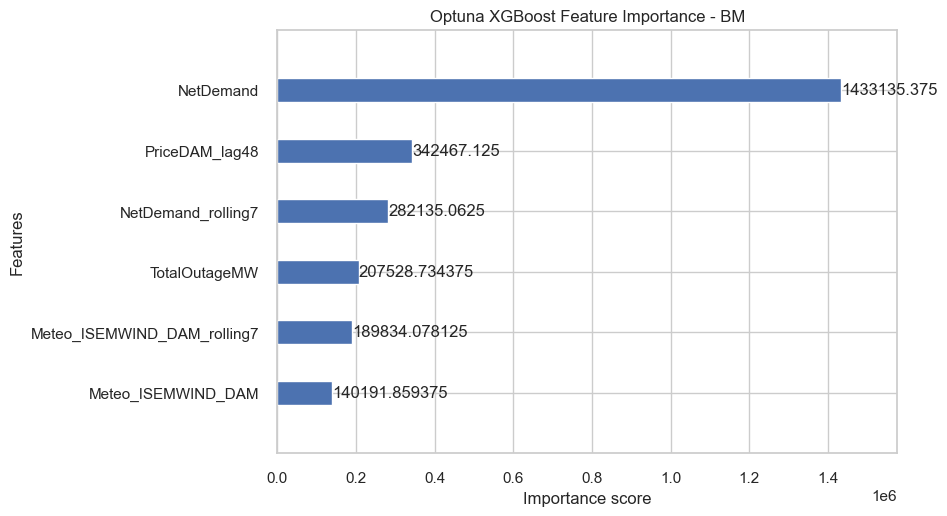

In [13]:
print("\nSECTION 5b: Optuna Hyperparameter Tuning - BM")

# Set target and features
target = 'PriceImbalance'
features = [
'NetDemand', 'Meteo_ISEMWIND_DAM', 'TotalOutageMW',
'NetDemand_rolling7', 'Meteo_ISEMWIND_DAM_rolling7',
'PriceDAM_lag48'
]

df_mod = combined_prices_df[features + [target]].dropna()
X = df_mod[features]
y = df_mod[target]
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, shuffle=False, random_state=42
)

# Optuna objective for XGBoost
def objective_xgb_bm(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    return rmse

study_xgb_bm = optuna.create_study(direction='minimize')
study_xgb_bm.optimize(objective_xgb_bm, n_trials=50)

print("Optuna Best Params (BM XGB):", study_xgb_bm.best_params)
print("Optuna Best RMSE (BM XGB):", study_xgb_bm.best_value)

# Train tuned XGB model for BM with best params
best_xgb_bm = xgb.XGBRegressor(**study_xgb_bm.best_params)
best_xgb_bm.fit(X_train, y_train)
preds_xgb_bm = best_xgb_bm.predict(X_test)

# Evaluate
mae_bm = mean_absolute_error(y_test, preds_xgb_bm)
rmse_bm = mean_squared_error(y_test, preds_xgb_bm, squared=False)
r2_bm = r2_score(y_test, preds_xgb_bm)

print(f"Optuna Tuned XGBoost - BM: MAE={mae_bm:.2f}, RMSE={rmse_bm:.2f}, R²={r2_bm:.2f}")

# Plot feature importance if desired
xgb.plot_importance(best_xgb_bm, importance_type='gain', height=0.4)
plt.title('Optuna XGBoost Feature Importance - BM')
plt.show()


 XGBoost - IDA1: MAE=22.79, RMSE=31.00, R²=0.24


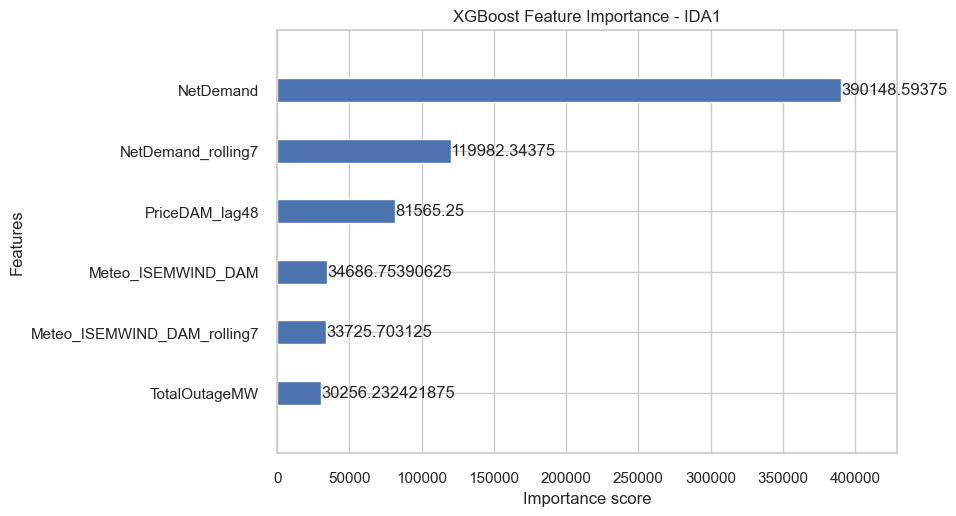

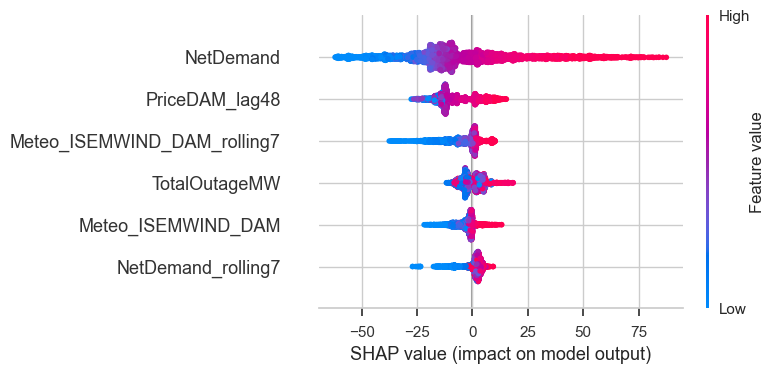

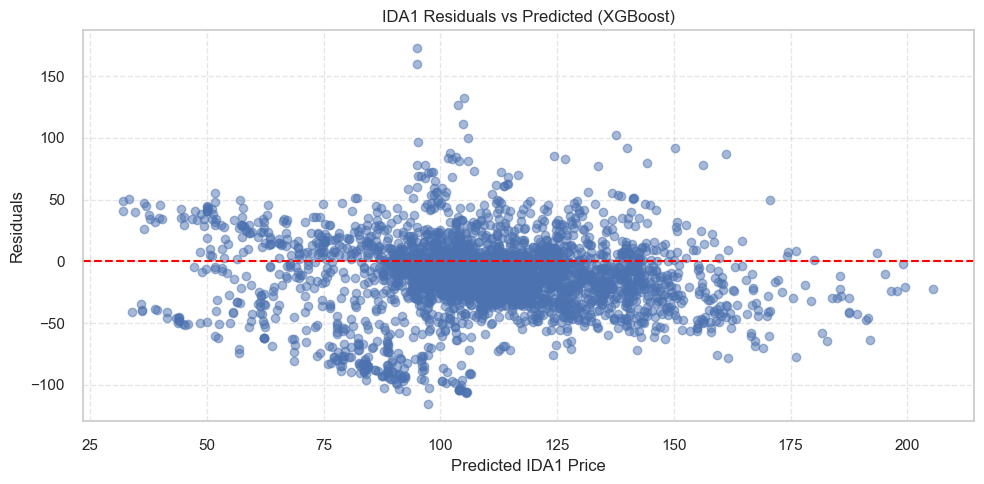

 LightGBM - IDA1: MAE=22.86, RMSE=31.05, R²=0.24


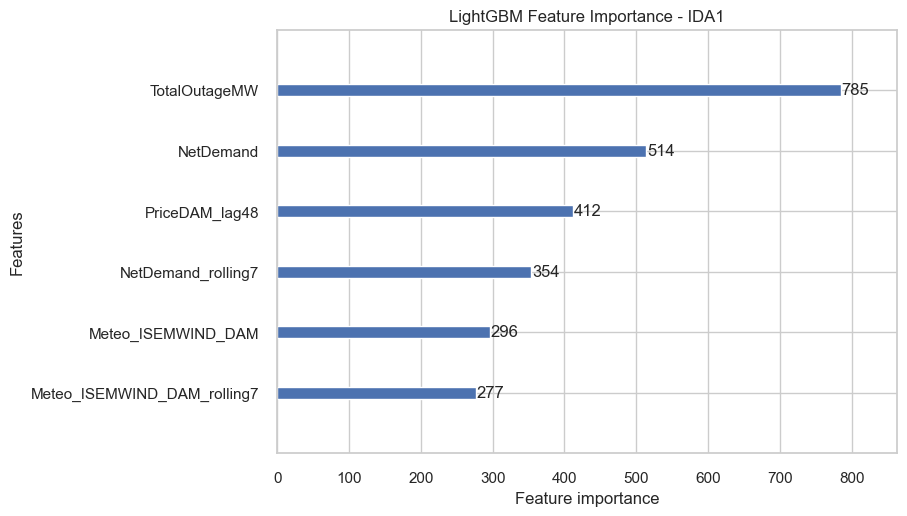

 CatBoost - IDA1: MAE=23.15, RMSE=31.49, R²=0.22


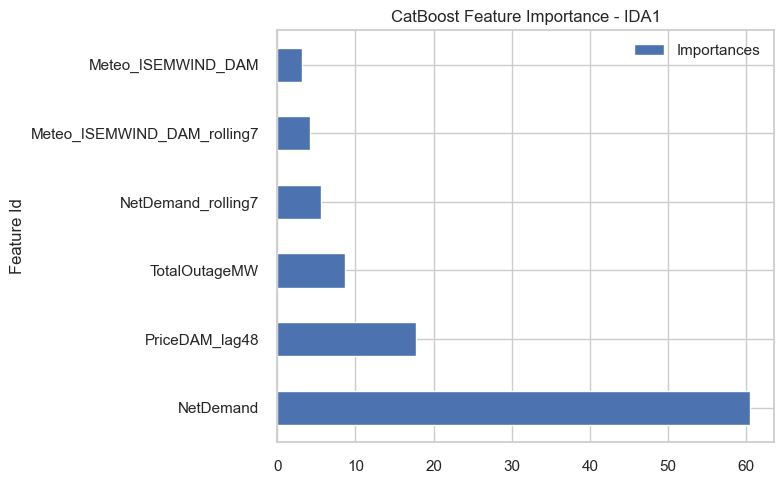


 PyCaret AutoML - IDA1 Modelling


Fitting 3 folds for each of 10 candidates, totalling 30 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


 PyCaret Leaderboard - IDA1:
              Model      MAE       MSE     RMSE      R2   RMSLE    MAPE
0  Voting Regressor  12.2974  282.9987  16.8226  0.7776  0.5342  5.9237

 IDA1 Predictions Head:
       NetDemand  Meteo_ISEMWIND_DAM  TotalOutageMW  NetDemand_rolling7  Meteo_ISEMWIND_DAM_rolling7  PriceDAM_lag48  PriceIDA1  prediction_label
77474     1093.0              2818.0         2008.0         1155.571411                  3182.000000      114.699997      25.00         54.098124
77475     1167.0              2607.0         2008.0         1174.428589                  3047.142822      114.699997       6.60         48.287597
77476     1247.0              2420.0         2008.0         1197.428589                  2899.000000      123.360001       2.82         44.840849
77477     1309.0              2255.0         2008.0         1219.571411                  2743.857178      123.360001      -2.00         30.144269
77478     1326.0              2144.0         2008.0         1235.857178

In [14]:

# ==================== PART 5: MODELLING - IDA1 PRICE ====================

# --- Ensure PriceIDA1 is present ---
if 'PriceIDA1' not in combined_prices_df.columns:
    combined_prices_df = pd.merge(
        combined_prices_df,
        df_MLForecastActualInputs[['StartDateTime', 'PriceIDA1']],
        on='StartDateTime',
        how='left'
    )
    print(" Merged 'PriceIDA1' into combined_prices_df for IDA1 modelling.")

# --- 1 Feature and target setup ---
features = [
    'NetDemand',
    'Meteo_ISEMWIND_DAM',
    'TotalOutageMW',
    'NetDemand_rolling7',
    'Meteo_ISEMWIND_DAM_rolling7',
    'PriceDAM_lag48'
]
target = 'PriceIDA1'

df_mod = combined_prices_df[features + [target]].dropna()
X = df_mod[features]
y = df_mod[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- 2 XGBoost Baseline ---
xgb_model_ida1 = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)
xgb_model_ida1.fit(X_train, y_train)
y_pred_ida1 = xgb_model_ida1.predict(X_test)

mae_ida1 = mean_absolute_error(y_test, y_pred_ida1)
rmse_ida1 = np.sqrt(mean_squared_error(y_test, y_pred_ida1))
r2_ida1 = r2_score(y_test, y_pred_ida1)
print(f" XGBoost - IDA1: MAE={mae_ida1:.2f}, RMSE={rmse_ida1:.2f}, R²={r2_ida1:.2f}")

xgb.plot_importance(xgb_model_ida1, importance_type='gain', height=0.4)
plt.title('XGBoost Feature Importance - IDA1')
plt.show()

# SHAP Analysis
explainer_ida1 = shap.Explainer(xgb_model_ida1, X_train)
shap_values_ida1 = explainer_ida1(X_test)
shap.summary_plot(shap_values_ida1, X_test)

# Residual Diagnostics
residuals_ida1 = y_test - y_pred_ida1
plt.figure(figsize=(10,5))
plt.scatter(y_pred_ida1, residuals_ida1, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.title("IDA1 Residuals vs Predicted (XGBoost)")
plt.xlabel("Predicted IDA1 Price")
plt.ylabel("Residuals")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 3 LightGBM ---
lgb_model_ida1 = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgb_model_ida1.fit(X_train, y_train)
y_pred_lgb_ida1 = lgb_model_ida1.predict(X_test)

mae_lgb_ida1 = mean_absolute_error(y_test, y_pred_lgb_ida1)
rmse_lgb_ida1 = np.sqrt(mean_squared_error(y_test, y_pred_lgb_ida1))
r2_lgb_ida1 = r2_score(y_test, y_pred_lgb_ida1)
print(f" LightGBM - IDA1: MAE={mae_lgb_ida1:.2f}, RMSE={rmse_lgb_ida1:.2f}, R²={r2_lgb_ida1:.2f}")

lgb.plot_importance(lgb_model_ida1, max_num_features=10)
plt.title('LightGBM Feature Importance - IDA1')
plt.show()

# --- 4 CatBoost ---
cat_model_ida1 = cb.CatBoostRegressor(
    iterations=200,
    learning_rate=0.05,
    depth=4,
    verbose=0,
    random_state=42
)
cat_model_ida1.fit(X_train, y_train)
y_pred_cb_ida1 = cat_model_ida1.predict(X_test)

mae_cb_ida1 = mean_absolute_error(y_test, y_pred_cb_ida1)
rmse_cb_ida1 = np.sqrt(mean_squared_error(y_test, y_pred_cb_ida1))
r2_cb_ida1 = r2_score(y_test, y_pred_cb_ida1)
print(f" CatBoost - IDA1: MAE={mae_cb_ida1:.2f}, RMSE={rmse_cb_ida1:.2f}, R²={r2_cb_ida1:.2f}")

cb_importance_ida1 = cat_model_ida1.get_feature_importance(prettified=True)
cb_importance_ida1.plot.barh(x='Feature Id', y='Importances', figsize=(8,5), title='CatBoost Feature Importance - IDA1')
plt.tight_layout()
plt.show()

# ==================== PyCaret AutoML - IDA1 ====================
print("\n PyCaret AutoML - IDA1 Modelling")

df_pycaret_ida1 = combined_prices_df[features + ['PriceIDA1']].dropna()

exp_ida1 = setup(
    data=df_pycaret_ida1,
    target='PriceIDA1',
    session_id=42,
    train_size=0.8,
    fold_strategy='timeseries',
    fold=3,
    numeric_features=features,
    data_split_shuffle=False,
    fold_shuffle=False,
    verbose=False,
    use_gpu=True
)

best_models_ida1 = compare_models(n_select=3, sort='RMSE')
blended_ida1 = blend_models(estimator_list=best_models_ida1)
tuned_ida1 = tune_model(blended_ida1, optimize='RMSE')
evaluate_model(tuned_ida1)
final_ida1 = finalize_model(tuned_ida1)
predictions_ida1 = predict_model(final_ida1)
leaderboard_ida1 = pull()

print("\n PyCaret Leaderboard - IDA1:")
print(leaderboard_ida1)

#  Evaluation block for PyCaret Voting Regressor - IDA1
print("\n IDA1 Predictions Head:")
print(predictions_ida1.head())

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_true_ida1 = predictions_ida1['PriceIDA1']
y_pred_ida1 = predictions_ida1['prediction_label']

mae_ida1 = mean_absolute_error(y_true_ida1, y_pred_ida1)
rmse_ida1 = mean_squared_error(y_true_ida1, y_pred_ida1, squared=False)
r2_ida1 = r2_score(y_true_ida1, y_pred_ida1)

print(f"\n PyCaret Voting Regressor - IDA1 Evaluation:\nMAE={mae_ida1:.2f}, RMSE={rmse_ida1:.2f}, R²={r2_ida1:.2f}")

print("\n IDA1 Modelling complete.\n")


[I 2025-08-14 12:42:56,035] A new study created in memory with name: no-name-802476c6-ce1a-4856-aadb-701438905cc9



SECTION 5b: Optuna Hyperparameter Tuning - IDA1


[I 2025-08-14 12:42:56,729] Trial 0 finished with value: 43.23191905847536 and parameters: {'lambda': 0.033504345236719295, 'alpha': 4.488132079282328, 'colsample_bytree': 0.5988218191716237, 'subsample': 0.8978531380690999, 'learning_rate': 0.0013546161364140304, 'max_depth': 10, 'n_estimators': 175}. Best is trial 0 with value: 43.23191905847536.
[I 2025-08-14 12:42:57,127] Trial 1 finished with value: 37.15411457509895 and parameters: {'lambda': 0.014714531499521481, 'alpha': 0.5053452931577741, 'colsample_bytree': 0.7723500824464473, 'subsample': 0.619508550427319, 'learning_rate': 0.009291874251311075, 'max_depth': 10, 'n_estimators': 83}. Best is trial 1 with value: 37.15411457509895.
[I 2025-08-14 12:42:58,432] Trial 2 finished with value: 41.07130834829794 and parameters: {'lambda': 0.7418337406787338, 'alpha': 0.01684351793540828, 'colsample_bytree': 0.6794743531130649, 'subsample': 0.6511440744704959, 'learning_rate': 0.0012245914901301393, 'max_depth': 10, 'n_estimators': 30

Optuna Best Params (PriceIDA1 XGB): {'lambda': 8.853915817016565, 'alpha': 0.06137182951198653, 'colsample_bytree': 0.723973846387276, 'subsample': 0.6304552421256006, 'learning_rate': 0.02110969913289026, 'max_depth': 6, 'n_estimators': 251}
Optuna Best RMSE (PriceIDA1 XGB): 30.684720192332442
Optuna Tuned XGBoost - PriceIDA1: MAE=22.65, RMSE=30.84, R²=0.25


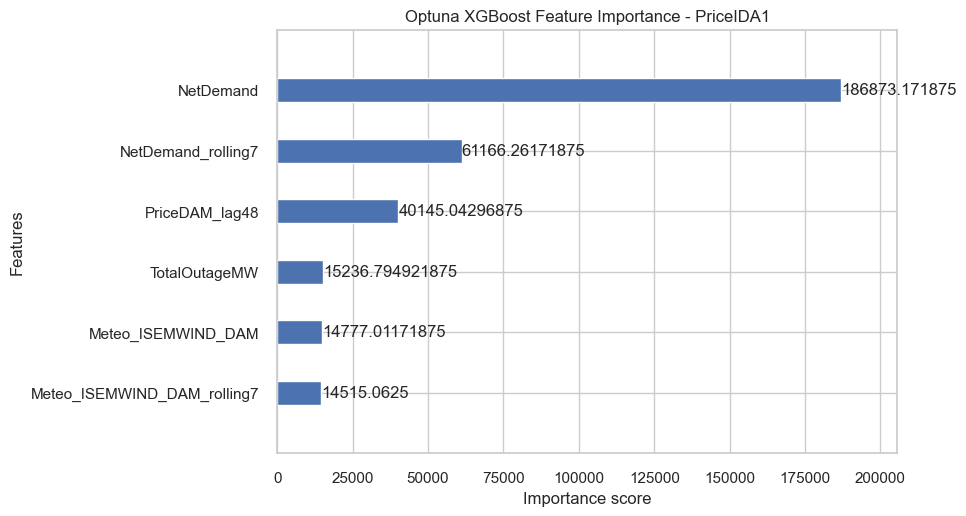

In [15]:
print("\nSECTION 5b: Optuna Hyperparameter Tuning - IDA1")

# Set target and features
target = 'PriceIDA1'
features = [
'NetDemand', 'Meteo_ISEMWIND_DAM', 'TotalOutageMW',
'NetDemand_rolling7', 'Meteo_ISEMWIND_DAM_rolling7',
'PriceDAM_lag48'
]

df_mod = combined_prices_df[features + [target]].dropna()
X = df_mod[features]
y = df_mod[target]
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, shuffle=False, random_state=42
)

# Optuna objective for XGBoost
def objective_xgb_IDA1(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    return rmse

study_xgb_bm = optuna.create_study(direction='minimize')
study_xgb_bm.optimize(objective_xgb_bm, n_trials=50)

print("Optuna Best Params (PriceIDA1 XGB):", study_xgb_bm.best_params)
print("Optuna Best RMSE (PriceIDA1 XGB):", study_xgb_bm.best_value)

# Train tuned XGB model for BM with best params
best_xgb_bm = xgb.XGBRegressor(**study_xgb_bm.best_params)
best_xgb_bm.fit(X_train, y_train)
preds_xgb_bm = best_xgb_bm.predict(X_test)

# Evaluate
mae_bm = mean_absolute_error(y_test, preds_xgb_bm)
rmse_bm = mean_squared_error(y_test, preds_xgb_bm, squared=False)
r2_bm = r2_score(y_test, preds_xgb_bm)

print(f"Optuna Tuned XGBoost - PriceIDA1: MAE={mae_bm:.2f}, RMSE={rmse_bm:.2f}, R²={r2_bm:.2f}")

# Plot feature importance if desired
xgb.plot_importance(best_xgb_bm, importance_type='gain', height=0.4)
plt.title('Optuna XGBoost Feature Importance - PriceIDA1')
plt.show()

In [16]:
#=================================================VARIABLE TESTING FOR ACCURACY==================================================

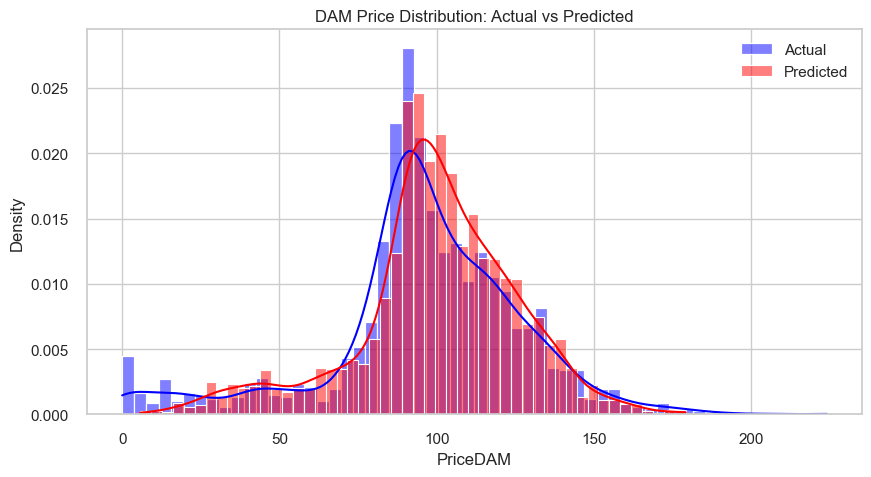

 DAM Prediction vs Actual Correlation: 0.958
 DAM Residuals - Mean: -14.22, Median: -11.72, Std: 23.71


In [17]:
# DAM
plt.figure(figsize=(10,5))
sns.histplot(predictions['PriceDAM'], color='blue', label='Actual', kde=True, stat='density')
sns.histplot(predictions['prediction_label'], color='red', label='Predicted', kde=True, stat='density')
plt.title("DAM Price Distribution: Actual vs Predicted")
plt.legend()
plt.show()

# DAM
corr_dam = np.corrcoef(predictions['PriceDAM'], predictions['prediction_label'])[0,1]
print(f" DAM Prediction vs Actual Correlation: {corr_dam:.3f}")

# DAM
residuals_dam = predictions['PriceDAM'] - predictions['prediction_label']
print(f" DAM Residuals - Mean: {residuals.mean():.2f}, Median: {residuals.median():.2f}, Std: {residuals.std():.2f}")


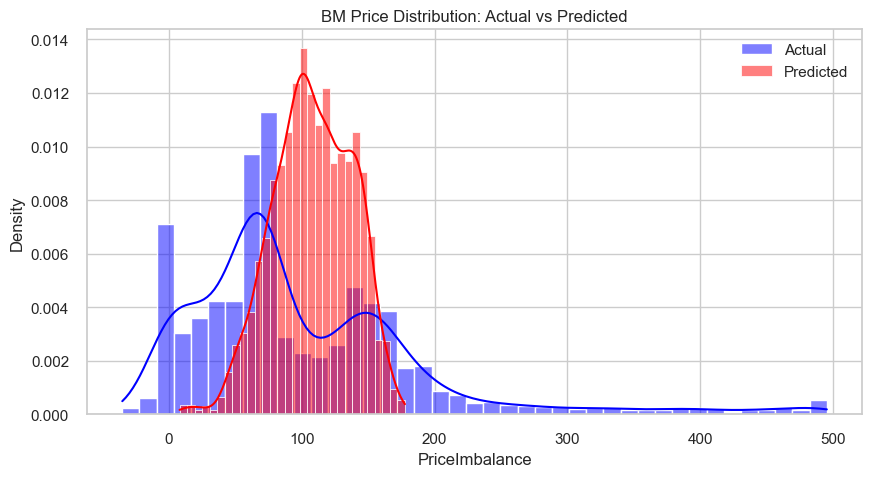

 BM Prediction vs Actual Correlation: 0.255
 BM Residuals - Mean: -7.94, Median: -33.36, Std: 87.62


In [18]:

# BM
plt.figure(figsize=(10,5))
sns.histplot(predictions_bm['PriceImbalance'], color='blue', label='Actual', kde=True, stat='density')
sns.histplot(predictions_bm['prediction_label'], color='red', label='Predicted', kde=True, stat='density')
plt.title("BM Price Distribution: Actual vs Predicted")
plt.legend()
plt.show()


# BM
corr_bm = np.corrcoef(predictions_bm['PriceImbalance'], predictions_bm['prediction_label'])[0,1]
print(f" BM Prediction vs Actual Correlation: {corr_bm:.3f}")


# BM
residuals_bm = predictions_bm['PriceImbalance'] - predictions_bm['prediction_label']
print(f" BM Residuals - Mean: {residuals_bm.mean():.2f}, Median: {residuals_bm.median():.2f}, Std: {residuals_bm.std():.2f}")


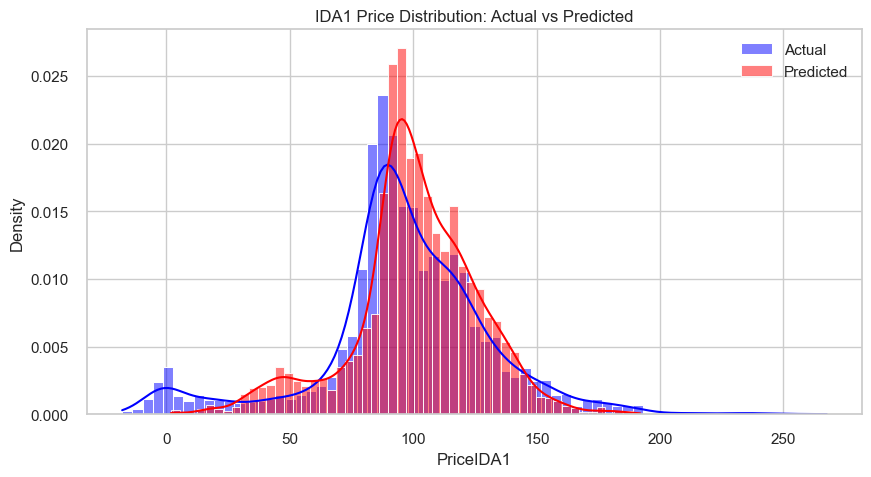

 IDA1 Prediction vs Actual Correlation: 0.907
 IDA1 Residuals - Mean: -4.15, Median: -4.24, Std: 16.30


In [19]:
# IDA1
plt.figure(figsize=(10,5))
sns.histplot(predictions_ida1['PriceIDA1'], color='blue', label='Actual', kde=True, stat='density')
sns.histplot(predictions_ida1['prediction_label'], color='red', label='Predicted', kde=True, stat='density')
plt.title("IDA1 Price Distribution: Actual vs Predicted")
plt.legend()
plt.show()


# IDA1
corr_ida1 = np.corrcoef(predictions_ida1['PriceIDA1'], predictions_ida1['prediction_label'])[0,1]
print(f" IDA1 Prediction vs Actual Correlation: {corr_ida1:.3f}")

# IDA1
residuals_ida1 = predictions_ida1['PriceIDA1'] - predictions_ida1['prediction_label']
print(f" IDA1 Residuals - Mean: {residuals_ida1.mean():.2f}, Median: {residuals_ida1.median():.2f}, Std: {residuals_ida1.std():.2f}")


In [20]:
# ==================== SECTION 6: Arbitrage Feature Engineering ====================


In [21]:
print("\n SECTION 6: Arbitrage Feature Engineering - Clean Build Started")

# 1 Check available columns
print("\n Available columns for arbitrage feature engineering:")
print(combined_prices_df.columns)

# 2 Calculate arbitrage spreads
combined_prices_df['Spread_IDA1toBM'] = combined_prices_df['PriceImbalance'] - combined_prices_df['PriceIDA1']
combined_prices_df['Spread_DAMtoBM'] = combined_prices_df['PriceImbalance'] - combined_prices_df['PriceDAM']
combined_prices_df['Spread_DAMtoIDA1'] = combined_prices_df['PriceIDA1'] - combined_prices_df['PriceDAM']

# 3 Create directional arbitrage signals (+1 if spread > 0, else -1)
combined_prices_df['Signal_IDA1toBM'] = np.sign(combined_prices_df['Spread_IDA1toBM']).fillna(0).astype(int)
combined_prices_df['Signal_DAMtoBM'] = np.sign(combined_prices_df['Spread_DAMtoBM']).fillna(0).astype(int)
combined_prices_df['Signal_DAMtoIDA1'] = np.sign(combined_prices_df['Spread_DAMtoIDA1']).fillna(0).astype(int)

# 4 Summary display
print("\n Arbitrage spreads and signals created successfully.\n")

# 5 Show a clean sample to verify
display_cols = [
    'PriceDAM', 'PriceIDA1', 'PriceImbalance',
    'Spread_IDA1toBM', 'Signal_IDA1toBM',
    'Spread_DAMtoBM', 'Signal_DAMtoBM',
    'Spread_DAMtoIDA1', 'Signal_DAMtoIDA1'
]
print(" Sample of Arbitrage Features:")
display(combined_prices_df[display_cols].dropna().head(10))

print("\n SECTION 6: Arbitrage Feature Engineering Complete.\n")



 SECTION 6: Arbitrage Feature Engineering - Clean Build Started

 Available columns for arbitrage feature engineering:
Index(['StartDateTime', 'GB DAM Epex', 'GB DAM N2EX', 'GB IDA1 Epex', 'TotalOutageMW', 'PriceDAM', 'PriceIDA1', 'PriceIDA2', 'PriceIDA3', 'PriceImbalance',
       ...
       'GU_504120', 'GU_504160', 'GU_504200', 'GU_504230', 'GU_504240', 'GU_504260', 'RampRate', 'HighRamp', 'PriceVolatility', 'HighVolatility'],
      dtype='object', length=388)

 Arbitrage spreads and signals created successfully.

 Sample of Arbitrage Features:


PriceDAM  PriceIDA1  PriceImbalance  Spread_IDA1toBM  Signal_IDA1toBM  Spread_DAMtoBM  Signal_DAMtoBM  Spread_DAMtoIDA1  Signal_DAMtoIDA1
63410    122.05     104.25            0.00          -104.25               -1         -122.05              -1            -17.80                -1
63411    122.05     100.81            2.05           -98.76               -1         -120.00              -1            -21.24                -1
63412    104.49     106.67            0.00          -106.67               -1         -104.49              -1              2.18                 1
63413    104.49     100.81            0.00          -100.81               -1         -104.49              -1             -3.68                -1
63414    120.01     120.73           65.73           -55.00               -1          -54.28              -1              0.72                 1
63415    120.01     112.53           42.47           -70.06               -1          -77.54              -1             -7.48                -1
63416    120.00     109.60           79.29           -30.31               -1          -40.71              -1            -10.40                -1
63417    120.00     108.00           75.09           -32.91               -1          -44.91              -1            -12.00                -1
63418    120.01     106.67           75.28           -31.39               -1          -44.73              -1            -13.34                -1
63419    120.01     108.00           80.13           -27.87               -1          -39.88              -1            -12.01                -1


 SECTION 6: Arbitrage Feature Engineering Complete.



In [22]:
#=============================Part 7:BACKTESTING================================


 SECTION 7: DAM Arbitrage Backtesting & Evaluation - Clean Build Started


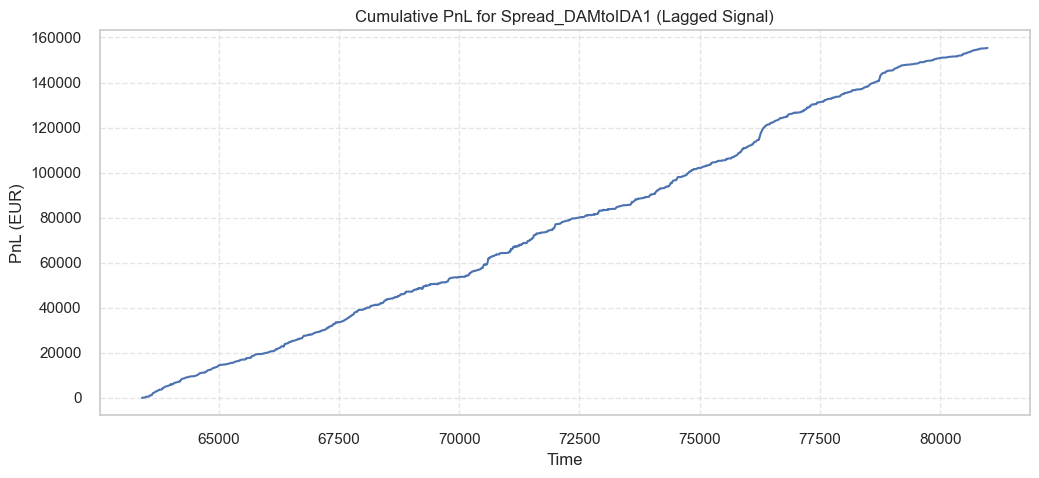

 Spread_DAMtoIDA1 | Total Trades: 17,344 | Hit Rate: 15.71%
 Hypothetical Total PnL: €155,359.56
 Mean PnL per trade: €8.84

 DAM Arbitrage Backtesting & Evaluation Complete.


In [23]:

#  DAM Arbitrage Backtesting 

print("\n SECTION 7: DAM Arbitrage Backtesting & Evaluation - Clean Build Started")

# Lag signal
combined_prices_df['Signal_DAMtoIDA1_lag'] = combined_prices_df['Signal_DAMtoIDA1'].shift(1)

# Calculate PnL with lagged signal
pnl_dam = combined_prices_df['Spread_DAMtoIDA1'] * combined_prices_df['Signal_DAMtoIDA1_lag']

# Backtest metrics
total_trades_dam = combined_prices_df['Signal_DAMtoIDA1_lag'].abs().sum()
hit_rate_dam = (np.sign(combined_prices_df['Spread_DAMtoIDA1']) == combined_prices_df['Signal_DAMtoIDA1_lag']).mean() * 100
total_pnl_dam = pnl_dam.sum()
mean_pnl_dam = pnl_dam.mean()

# Plot cumulative PnL
pnl_dam.cumsum().plot(title="Cumulative PnL for Spread_DAMtoIDA1 (Lagged Signal)", figsize=(12,5))
plt.xlabel("Time")
plt.ylabel("PnL (EUR)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(f" Spread_DAMtoIDA1 | Total Trades: {total_trades_dam:,.0f} | Hit Rate: {hit_rate_dam:.2f}%")
print(f" Hypothetical Total PnL: €{total_pnl_dam:,.2f}")
print(f" Mean PnL per trade: €{mean_pnl_dam:.2f}")

print("\n DAM Arbitrage Backtesting & Evaluation Complete.")




 SECTION 7: BM Arbitrage Backtesting & Evaluation - Clean Build Started


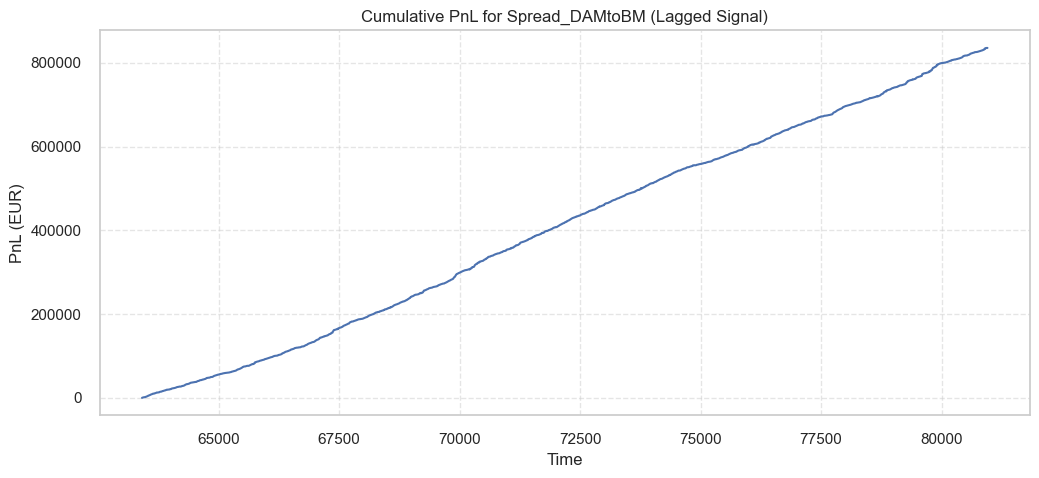

 Spread_DAMtoBM | Total Trades: 17,396 | Hit Rate: 18.17%
 Hypothetical Total PnL: €835,607.75
 Mean PnL per trade: €47.63

 BM Arbitrage Backtesting & Evaluation Complete.


In [24]:

# BM Arbitrage Backtesting 

print("\n SECTION 7: BM Arbitrage Backtesting & Evaluation - Clean Build Started")

# Lag signal
combined_prices_df['Signal_DAMtoBM_lag'] = combined_prices_df['Signal_DAMtoBM'].shift(1)

# Calculate PnL with lagged signal
pnl_bm = combined_prices_df['Spread_DAMtoBM'] * combined_prices_df['Signal_DAMtoBM_lag']

# Backtest metrics
total_trades_bm = combined_prices_df['Signal_DAMtoBM_lag'].abs().sum()
hit_rate_bm = (np.sign(combined_prices_df['Spread_DAMtoBM']) == combined_prices_df['Signal_DAMtoBM_lag']).mean() * 100
total_pnl_bm = pnl_bm.sum()
mean_pnl_bm = pnl_bm.mean()

# Plot cumulative PnL
pnl_bm.cumsum().plot(title="Cumulative PnL for Spread_DAMtoBM (Lagged Signal)", figsize=(12,5))
plt.xlabel("Time")
plt.ylabel("PnL (EUR)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(f" Spread_DAMtoBM | Total Trades: {total_trades_bm:,.0f} | Hit Rate: {hit_rate_bm:.2f}%")
print(f" Hypothetical Total PnL: €{total_pnl_bm:,.2f}")
print(f" Mean PnL per trade: €{mean_pnl_bm:.2f}")

print("\n BM Arbitrage Backtesting & Evaluation Complete.")



 SECTION 7: IDA1 Arbitrage Backtesting & Evaluation - Clean Build Started


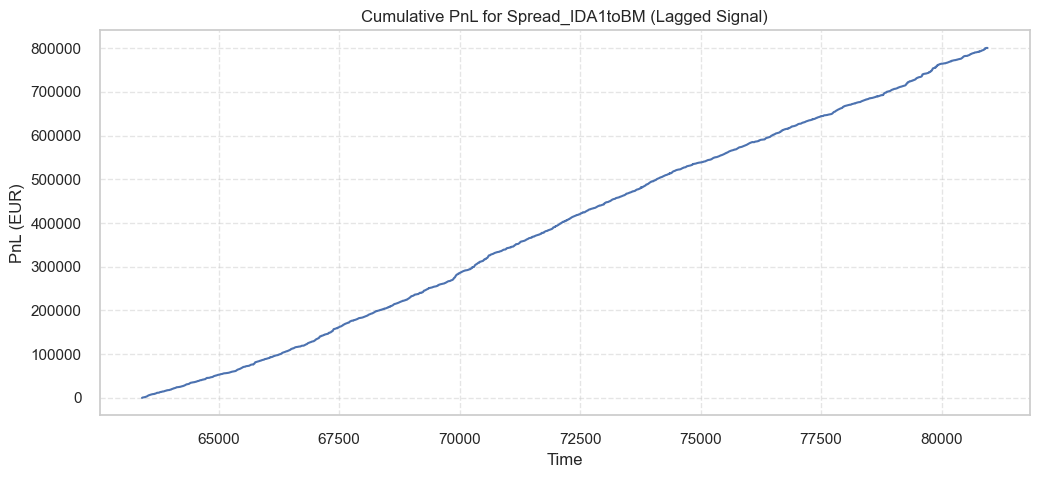

 Spread_IDA1toBM | Total Trades: 17,479 | Hit Rate: 18.11%
 Hypothetical Total PnL: €800,621.32
 Mean PnL per trade: €45.64

 IDA1 Arbitrage Backtesting & Evaluation Complete.


In [25]:
# IDA1 Arbitrage Backtesting 

print("\n SECTION 7: IDA1 Arbitrage Backtesting & Evaluation - Clean Build Started")

# Lag signal
combined_prices_df['Signal_IDA1toBM_lag'] = combined_prices_df['Signal_IDA1toBM'].shift(1)

# Calculate PnL with lagged signal
pnl_ida1 = combined_prices_df['Spread_IDA1toBM'] * combined_prices_df['Signal_IDA1toBM_lag']

# Backtest metrics
total_trades_ida1 = combined_prices_df['Signal_IDA1toBM_lag'].abs().sum()
hit_rate_ida1 = (np.sign(combined_prices_df['Spread_IDA1toBM']) == combined_prices_df['Signal_IDA1toBM_lag']).mean() * 100
total_pnl_ida1 = pnl_ida1.sum()
mean_pnl_ida1 = pnl_ida1.mean()

# Plot cumulative PnL
pnl_ida1.cumsum().plot(title="Cumulative PnL for Spread_IDA1toBM (Lagged Signal)", figsize=(12,5))
plt.xlabel("Time")
plt.ylabel("PnL (EUR)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(f" Spread_IDA1toBM | Total Trades: {total_trades_ida1:,.0f} | Hit Rate: {hit_rate_ida1:.2f}%")
print(f" Hypothetical Total PnL: €{total_pnl_ida1:,.2f}")
print(f" Mean PnL per trade: €{mean_pnl_ida1:.2f}")

print("\n IDA1 Arbitrage Backtesting & Evaluation Complete.")




Loading BokehJS ...

 Merging missing forecast features into combined_prices_df...
➡️ Merging in columns: ['NIV', 'CorrectedNIVForecast', 'PNForecast', 'ICSchedule_EW', 'ICSchedule_M', 'LoadForecastROI', 'LoadForecastNI', 'AggregatedForecast', 'PumpStorage', 'PN_IDA1', 'ActualMeterData', 'GBDAM_Price', 'GBHHDAM_Price', 'GBIDA1_Price', 'EirGridDemandFc_IDA1', 'EirGridWindFc_IDA1', 'EmSys_C_ISEMWIND_IDA1', 'EmSys_U_ISEMWIND_IDA1', 'PostIDA1Flow', 'Meteo_ISEMWIND_IDA1', 'Meteo_ISEMDEMAND_IDA1']
Lagged Correlation Matrix:
              TotalPN  Demand_Lag1  Wind_Lag1
TotalPN      1.000000     0.529208  -0.596626
Demand_Lag1  0.529208     1.000000   0.138296
Wind_Lag1   -0.596626     0.138296   1.000000


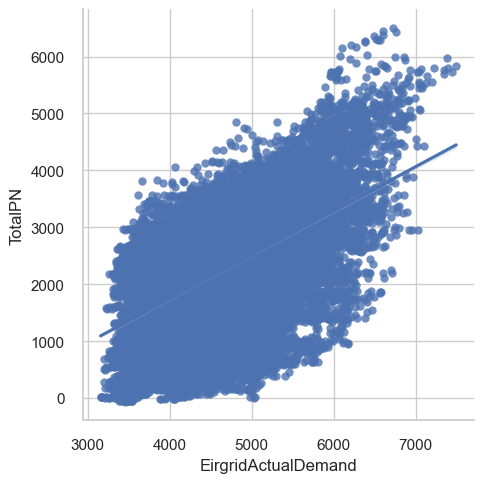

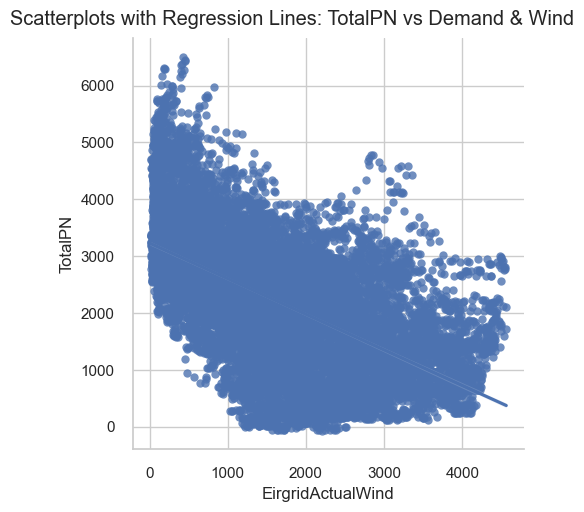

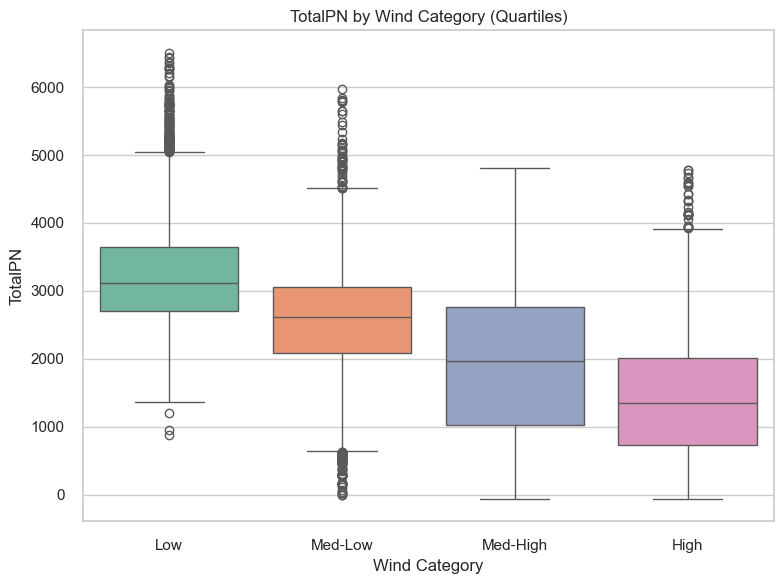

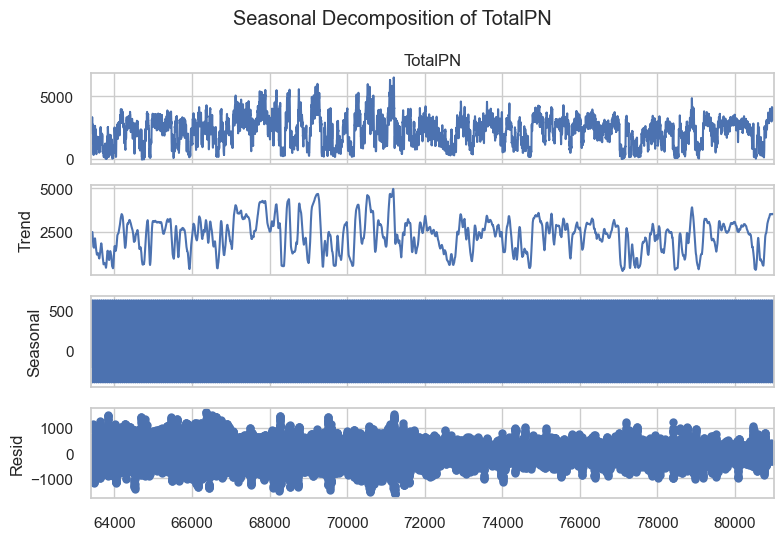

Correlation between NIV and PriceImbalance: 0.7120


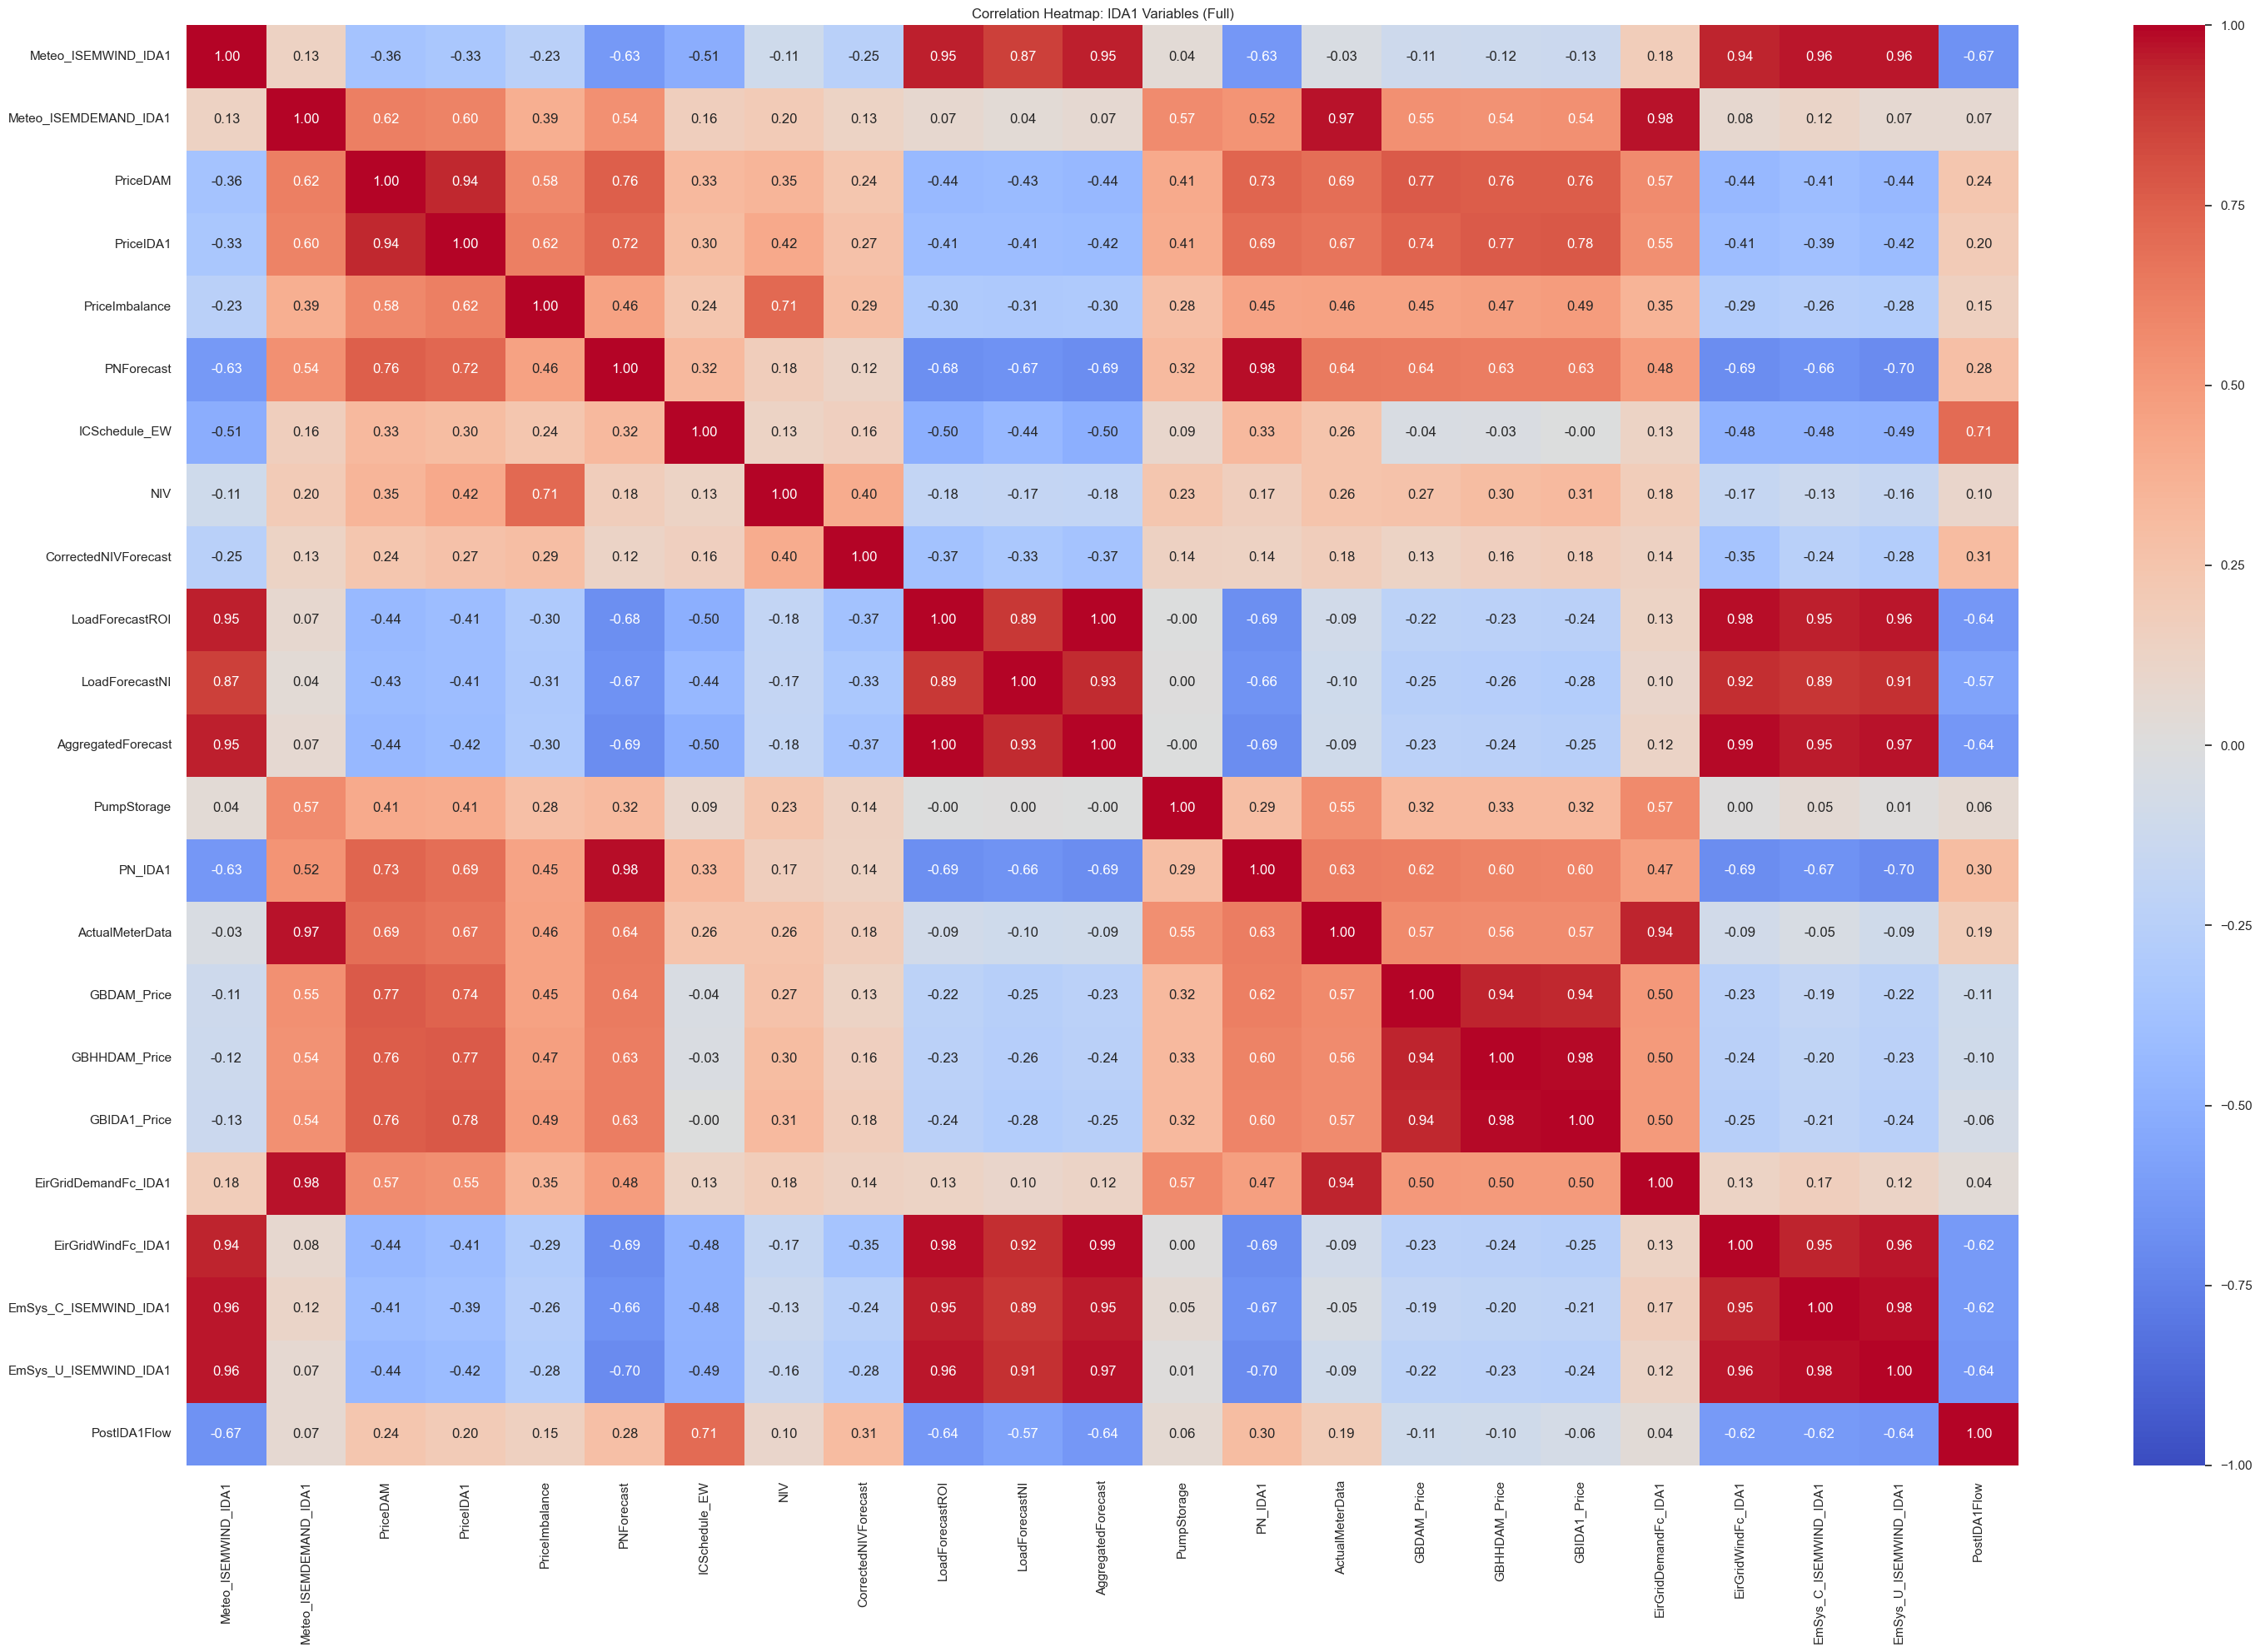

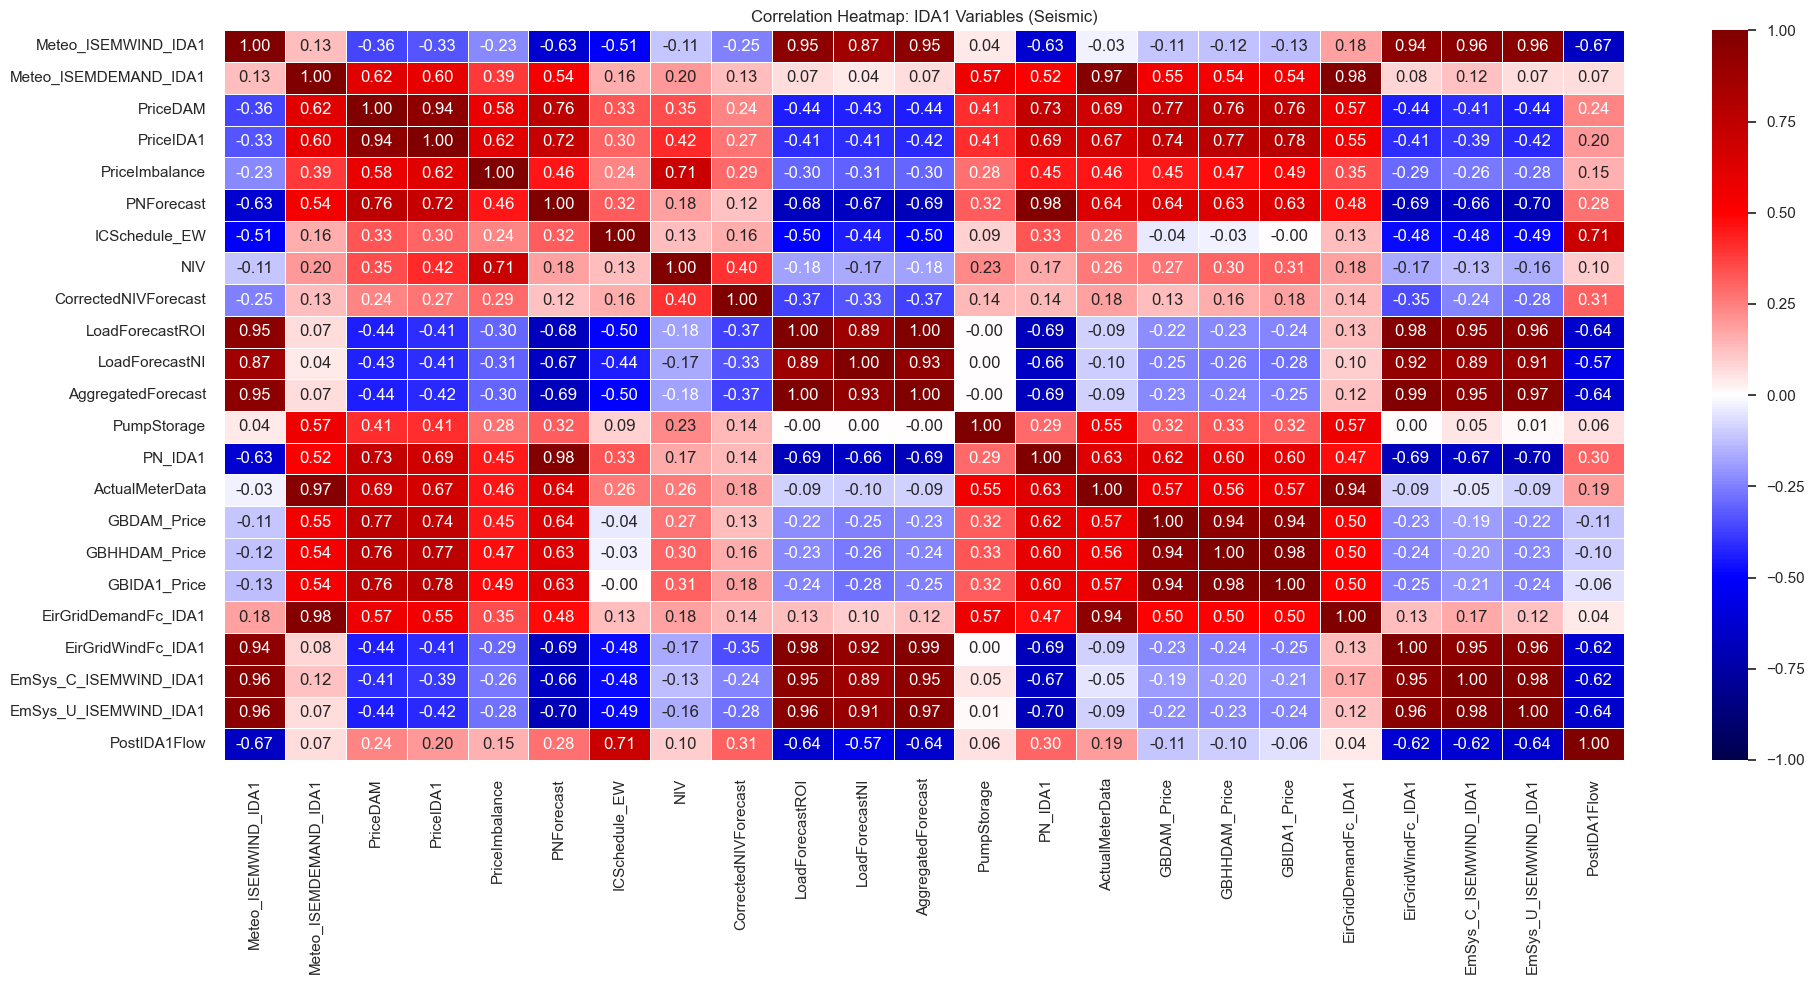

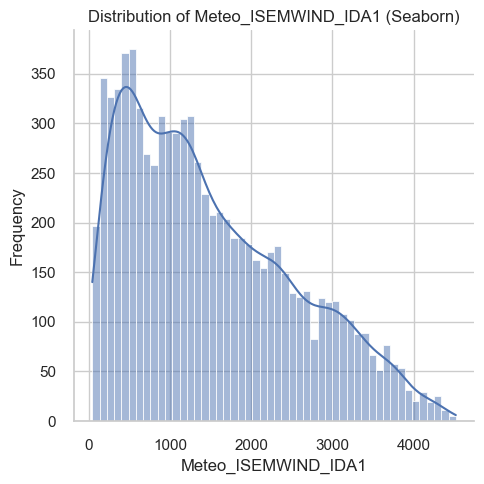

NameError: name 'px' is not defined

In [26]:
# ==================== PART 8: POST HOC ANALYSIS ====================
sns.set(style="whitegrid")
output_notebook()

# --- Ensure necessary columns exist in combined_prices_df ---
print(" Merging missing forecast features into combined_prices_df...")

# Full desired column list
missing_vars = [
    'NIV', 'CorrectedNIVForecast', 'PNForecast', 'ICSchedule_EW', 'ICSchedule_M',
    'LoadForecastROI', 'LoadForecastNI', 'AggregatedForecast', 'PumpStorage',
    'PN_IDA1', 'ActualMeterData', 'GBDAM_Price', 'GBHHDAM_Price', 'GBIDA1_Price',
    'EirGridDemandFc_IDA1', 'EirGridWindFc_IDA1',
    'EmSys_C_ISEMWIND_IDA1', 'EmSys_U_ISEMWIND_IDA1', 'PostIDA1Flow',
    'Meteo_ISEMWIND_IDA1', 'Meteo_ISEMDEMAND_IDA1', 'PriceIDA1'
]

# Ensure datetime alignment
df_MLForecastActualInputs['StartDateTime'] = pd.to_datetime(df_MLForecastActualInputs['StartDateTime'])
combined_prices_df['StartDateTime'] = pd.to_datetime(combined_prices_df['StartDateTime'])

# Filter only columns that aren't already in combined_prices_df
new_vars = [var for var in missing_vars if var not in combined_prices_df.columns]

# Only merge those
if new_vars:
    print(f"➡️ Merging in columns: {new_vars}")
    combined_prices_df = combined_prices_df.merge(
        df_MLForecastActualInputs[['StartDateTime'] + new_vars],
        on='StartDateTime',
        how='left'
    )
else:
    print("All required columns already present — no merge needed.")
    print("Merge check complete.\n")


# --- 1 Lag Analysis: Exploring lead-lag correlations with TotalPN ---
df['Demand_Lag1'] = df['EirgridActualDemand'].shift(1)
df['Wind_Lag1'] = df['EirgridActualWind'].shift(1)

lag_corr = df[['TotalPN', 'Demand_Lag1', 'Wind_Lag1']].corr()
print("Lagged Correlation Matrix:")
print(lag_corr)

# --- 2 Scatterplots with Regression Lines ---
sns.lmplot(data=df, x='EirgridActualDemand', y='TotalPN')
sns.lmplot(data=df, x='EirgridActualWind', y='TotalPN')
plt.suptitle("Scatterplots with Regression Lines: TotalPN vs Demand & Wind", y=1.02)
plt.show()

# --- 3 Boxplot Analysis ---
df['WindCategory'] = pd.qcut(df['EirgridActualWind'], q=4, labels=['Low', 'Med-Low', 'Med-High', 'High'])
plt.figure(figsize=(8,6))
sns.boxplot(x='WindCategory', y='TotalPN', data=df, palette='Set2')
plt.title("TotalPN by Wind Category (Quartiles)")
plt.xlabel("Wind Category")
plt.ylabel("TotalPN")
plt.tight_layout()
plt.show()

# --- 4 Seasonal Decomposition ---
result = seasonal_decompose(df['TotalPN'].dropna(), model='additive', period=48)
result.plot()
plt.suptitle("Seasonal Decomposition of TotalPN", y=0.98)
plt.tight_layout()
plt.show()

# --- 5 IDA1 Correlation Heatmaps ---
ida1_columns = [
    'Meteo_ISEMWIND_IDA1', 'Meteo_ISEMDEMAND_IDA1',
    'PriceDAM', 'PriceIDA1', 'PriceImbalance', 'PNForecast',
    'ICSchedule_EW', 'NIV', 'CorrectedNIVForecast', 'LoadForecastROI',
    'LoadForecastNI', 'AggregatedForecast', 'PumpStorage',
    'TotalPN', 'PN_IDA1', 'ActualMeterData', 'GBDAM_Price',
    'GBHHDAM_Price', 'GBIDA1_Price', 'EirGridDemandFc_IDA1',
    'EirGridWindFc_IDA1', 'EmSys_C_ISEMWIND_IDA1',
    'EmSys_U_ISEMWIND_IDA1', 'PostIDA1Flow'
]

available_cols = [col for col in ida1_columns if col in combined_prices_df.columns]
df_IDA1 = combined_prices_df[available_cols].dropna()

correlation = df_IDA1['NIV'].corr(df_IDA1['PriceImbalance'])
print(f"Correlation between NIV and PriceImbalance: {correlation:.4f}")

plt.figure(figsize=(30, 20))
sns.heatmap(df_IDA1.corr(), vmin=-1, vmax=1, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap: IDA1 Variables (Full)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
sns.heatmap(df_IDA1.corr().round(2), vmin=-1, vmax=1, annot=True, fmt=".2f", cmap="seismic", linewidths=0.5)
plt.title("Correlation Heatmap: IDA1 Variables (Seismic)")
plt.tight_layout()
plt.show()

# --- 6 Distributions Using Seaborn and Plotly ---
sns.displot(df_IDA1['Meteo_ISEMWIND_IDA1'].dropna(), kde=True, bins=50)
plt.title("Distribution of Meteo_ISEMWIND_IDA1 (Seaborn)")
plt.xlabel("Meteo_ISEMWIND_IDA1")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

fig = px.histogram(df_IDA1, x="Meteo_ISEMWIND_IDA1", nbins=50, title="Distribution of Meteo_ISEMWIND_IDA1 (Plotly)")
fig.show()

# --- 7 Bokeh Distribution ---
x = df_IDA1['Meteo_ISEMDEMAND_IDA1'].dropna().sort_values().values
hist, edges = np.histogram(x, bins=40)
p = figure(title="Distribution of Meteo_ISEMDEMAND_IDA1 (Bokeh)", width=700, height=400, x_axis_label='MW', y_axis_label='Count')
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color="skyblue", line_color="white")
show(p)

print("\nPost Hoc Analysis completed.")

# --- Scenario Flags for Advanced Analysis ---
high_demand_threshold = combined_prices_df['NetDemand'].quantile(0.75)
low_wind_threshold = combined_prices_df['Meteo_ISEMWIND_DAM'].quantile(0.25)
high_outage_threshold = combined_prices_df['TotalOutageMW'].quantile(0.9)

combined_prices_df['HighDemand'] = combined_prices_df['NetDemand'] > high_demand_threshold
combined_prices_df['LowWind'] = combined_prices_df['Meteo_ISEMWIND_DAM'] < low_wind_threshold
combined_prices_df['HighOutage'] = combined_prices_df['TotalOutageMW'] > high_outage_threshold

# --- Directional Accuracy Evaluation ---
print("\n Directional Accuracy on DAM Price")
preds_series = pd.Series(y_pred, index=y_test.index[:len(y_pred)])
actual_series = y_test.iloc[:len(y_pred)]

pred_diff = preds_series.diff().shift(-1)
actual_diff = actual_series.diff().shift(-1)

actual_direction = np.sign(actual_diff)
predicted_direction = np.sign(pred_diff)
aligned_index = actual_direction.index.intersection(predicted_direction.index)
directional_accuracy = (actual_direction.loc[aligned_index] == predicted_direction.loc[aligned_index]).mean()
print(f"Directional Accuracy: {directional_accuracy:.2%}")

# --- Trading Signal Evaluation ---
print("\n Trading Signal Evaluation")
threshold = 10
signals = pd.Series(0, index=pred_diff.index)
signals[pred_diff > threshold] = 1
signals[pred_diff < -threshold] = -1
returns = signals * actual_diff
hit_rate = (np.sign(signals[signals != 0]) == np.sign(actual_diff[signals != 0])).mean()
average_profit = returns[signals != 0].mean()
total_profit = returns[signals != 0].sum()
num_trades = (signals != 0).sum()

print(f"Number of trades: {num_trades}")
print(f"Hit Rate: {hit_rate:.2%}")
print(f"Average Profit per Trade: {average_profit:.2f} EUR")
print(f"Total Profit (Hypothetical): {total_profit:.2f} EUR")

# --- SHAP Waterfall Analysis ---
print("\n SHAP Waterfall Plots on Key Examples (DAM)")
highest_pred_idx = np.argmax(y_pred)
lowest_pred_idx = np.argmin(y_pred)
errors = np.abs(y_test.iloc[:len(y_pred)].values - y_pred)
highest_error_idx = np.argmax(errors)
indices_to_plot = [highest_pred_idx, lowest_pred_idx, highest_error_idx]

for idx in indices_to_plot:
    print(f"\nWaterfall plot for index: {idx}")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values.values[idx],
            base_values=shap_values.base_values[idx],
            data=X_test.iloc[idx],
            feature_names=X_test.columns
        )
    )

# --- Scenario-Based Price Impact Analysis ---
print("\n Scenario-Based Price Impact Analysis (DAM)")
condition_df = combined_prices_df[combined_prices_df['HighDemand'] & combined_prices_df['LowWind']]
price_comparison = condition_df.groupby('HighOutage')['PriceDAM'].describe()
print("\nPriceDAM under High Demand & Low Wind:")
print(price_comparison)

# --- Outage Impact on Price Spread ---
print("\n Outage Impact on GB-ISEM Spread")
combined_prices_df['Spread_GB_Irish'] = combined_prices_df['GB DAM Epex'] - combined_prices_df['PriceDAM']
spread_stats = combined_prices_df.groupby('HighOutage')['Spread_GB_Irish'].describe()
print(spread_stats)

plt.figure(figsize=(10,5))
combined_prices_df['Spread_GB_Irish'].hist(bins=50, color='skyblue', edgecolor='k')
plt.title("GB-ISEM Spread Distribution")
plt.xlabel("Spread (€)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("\n Section 8 complete: All post hoc and scenario evaluations executed.")



SECTION 9: Comparing Multiple Spreads Over Multiple Thresholds

 Evaluating DAM to BM

 Evaluating IDA1 to BM

 Evaluating DAM to IDA1

 Best Threshold per Spread:
   Spread Type  Threshold  Trades  Hit Rate (%)  Avg PnL (€)  Total PnL (€)
0    DAM to BM         30   12714         89.19        62.85      799085.10
1  DAM to IDA1         30    1934         89.92        39.03       75487.42
2   IDA1 to BM         30   12140         89.45        62.44      758049.13


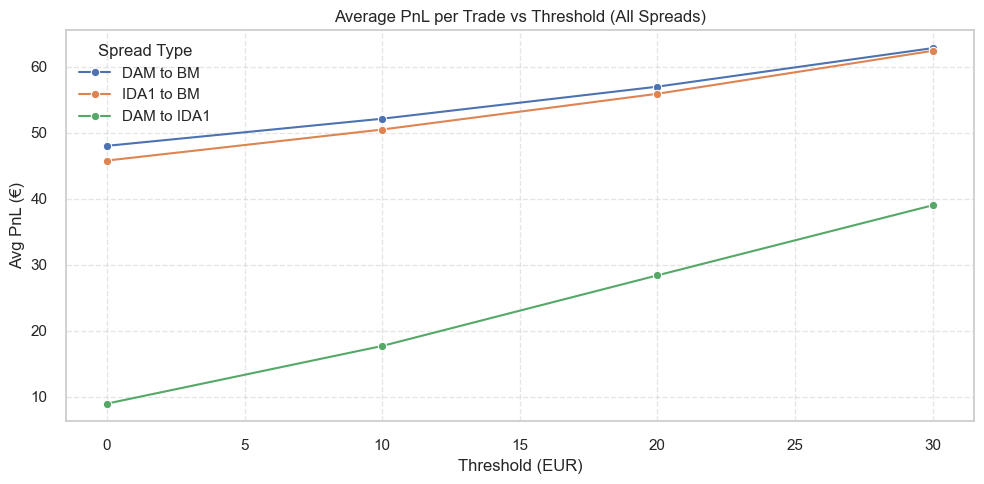

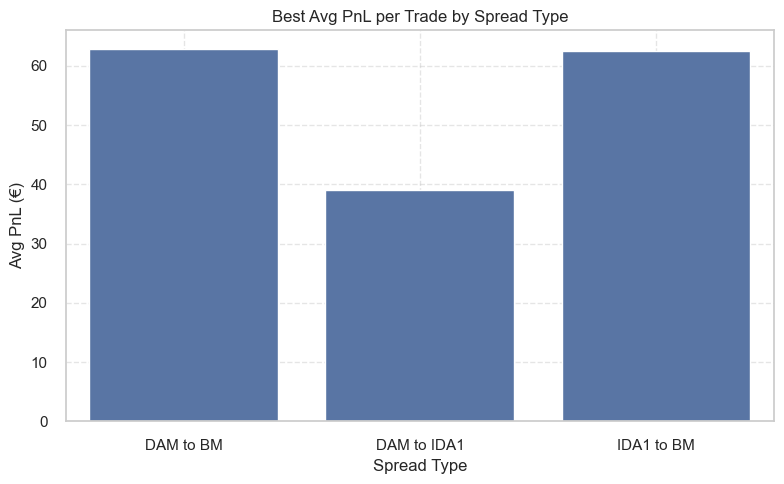

In [27]:
# ==================== SECTION 9.1: Multi-Spread Threshold Comparison ====================

print("SECTION 9: Comparing Multiple Spreads Over Multiple Thresholds")

# Define spread-signal pairs
spread_configs = {
    'DAM to BM': ('Spread_DAMtoBM', 'Signal_DAMtoBM'),
    'IDA1 to BM': ('Spread_IDA1toBM', 'Signal_IDA1toBM'),
    'DAM to IDA1': ('Spread_DAMtoIDA1', 'Signal_DAMtoIDA1'),
}

# Thresholds to test
thresholds = [0, 10, 20, 30]

# Collect best result per spread
best_results = []
full_results = []

# Loop through spreads
for label, (spread_col, signal_col) in spread_configs.items():
    print(f"\n Evaluating {label}")
    df_temp = combined_prices_df[[spread_col, signal_col]].copy()
    df_temp['Signal_Lag'] = df_temp[signal_col].shift(1)
    df_temp = df_temp.dropna()

    spread = df_temp[spread_col]
    signal = df_temp['Signal_Lag']

    for threshold in thresholds:
        filtered_signal = signal.copy()
        filtered_signal[spread.abs() < threshold] = 0

        pnl = spread * filtered_signal
        valid_trades = filtered_signal != 0

        if valid_trades.sum() == 0:
            continue

        hit_rate = (np.sign(spread[valid_trades]) == filtered_signal[valid_trades]).mean()
        avg_pnl = pnl[valid_trades].mean()
        total_pnl = pnl[valid_trades].sum()
        trade_count = valid_trades.sum()

        full_results.append({
            'Spread Type': label,
            'Threshold': threshold,
            'Trades': trade_count,
            'Hit Rate (%)': round(hit_rate * 100, 2),
            'Avg PnL (€)': round(avg_pnl, 2),
            'Total PnL (€)': round(total_pnl, 2)
        })


# Convert to DataFrame
full_df = pd.DataFrame(full_results)

# Find best threshold (highest Avg PnL) for each spread
best_df = full_df.sort_values('Avg PnL (€)', ascending=False).groupby('Spread Type').first().reset_index()

#  Output
print("\n Best Threshold per Spread:")
print(best_df)

# Line plot of Avg PnL vs Threshold
plt.figure(figsize=(10, 5))
sns.lineplot(data=full_df, x='Threshold', y='Avg PnL (€)', hue='Spread Type', marker='o')
plt.title("Average PnL per Trade vs Threshold (All Spreads)")
plt.xlabel("Threshold (EUR)")
plt.ylabel("Avg PnL (€)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Bar plot of best spread performance
plt.figure(figsize=(8, 5))
sns.barplot(data=best_df, x='Spread Type', y='Avg PnL (€)')
plt.title("Best Avg PnL per Trade by Spread Type")
plt.ylabel("Avg PnL (€)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



SECTION 10: Regime-Based Arbitrage Evaluation - Clean Build Started

--- Evaluating Regime: 10.1_AllThree ---
DAM→BM: Trades=843, Hit=88.73%, Avg PnL=75.0€, Total PnL=63228.53€
IDA1→BM: Trades=789, Hit=88.72%, Avg PnL=72.73€, Total PnL=57385.87€
DAM→IDA1: Trades=234, Hit=89.32%, Avg PnL=40.39€, Total PnL=9452.29€

--- Evaluating Regime: 10.2_HighDemand ---
DAM→BM: Trades=3943, Hit=86.79%, Avg PnL=68.57€, Total PnL=270356.58€
IDA1→BM: Trades=3801, Hit=87.48%, Avg PnL=67.86€, Total PnL=257941.36€
DAM→IDA1: Trades=1193, Hit=89.86%, Avg PnL=41.07€, Total PnL=48996.03€

--- Evaluating Regime: 10.3_LowWind ---
DAM→BM: Trades=3655, Hit=87.5%, Avg PnL=63.15€, Total PnL=230824.0€
IDA1→BM: Trades=3441, Hit=87.62%, Avg PnL=62.51€, Total PnL=215110.21€
DAM→IDA1: Trades=974, Hit=90.04%, Avg PnL=41.23€, Total PnL=40159.12€

--- Evaluating Regime: 10.4_HighOutage ---
DAM→BM: Trades=3775, Hit=89.56%, Avg PnL=63.62€, Total PnL=240159.24€
IDA1→BM: Trades=3536, Hit=89.59%, Avg PnL=62.83€, Total PnL=2221

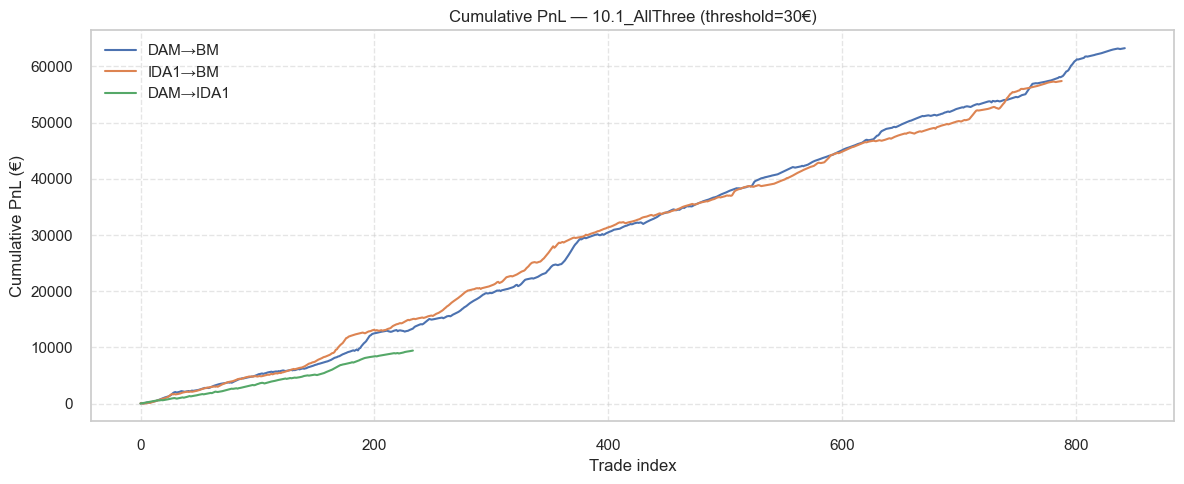

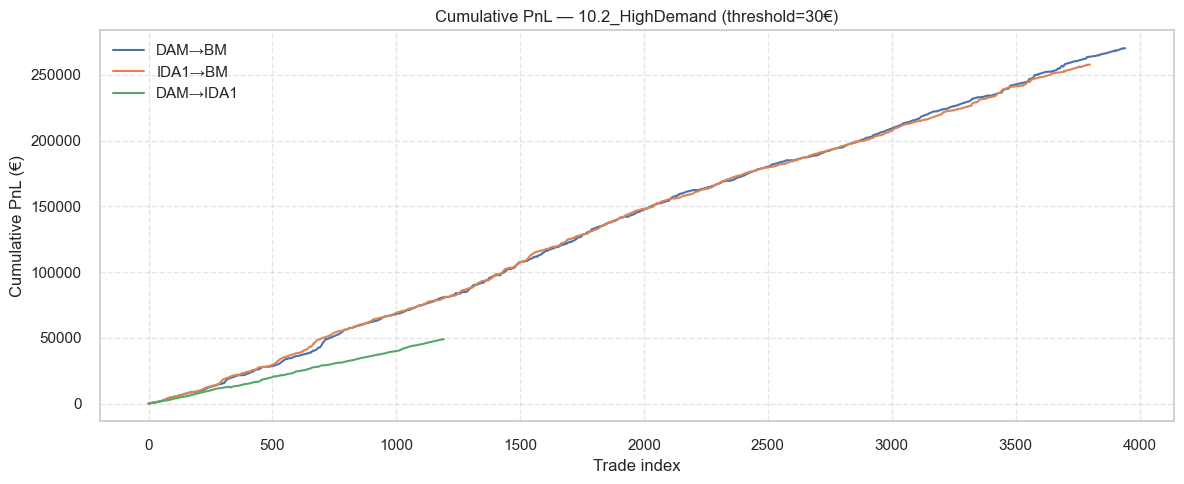

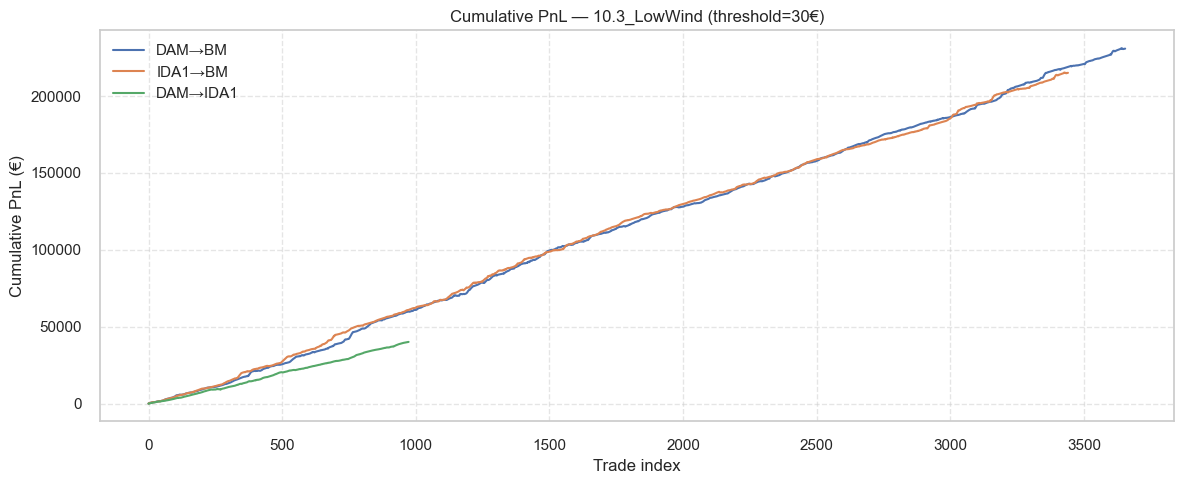

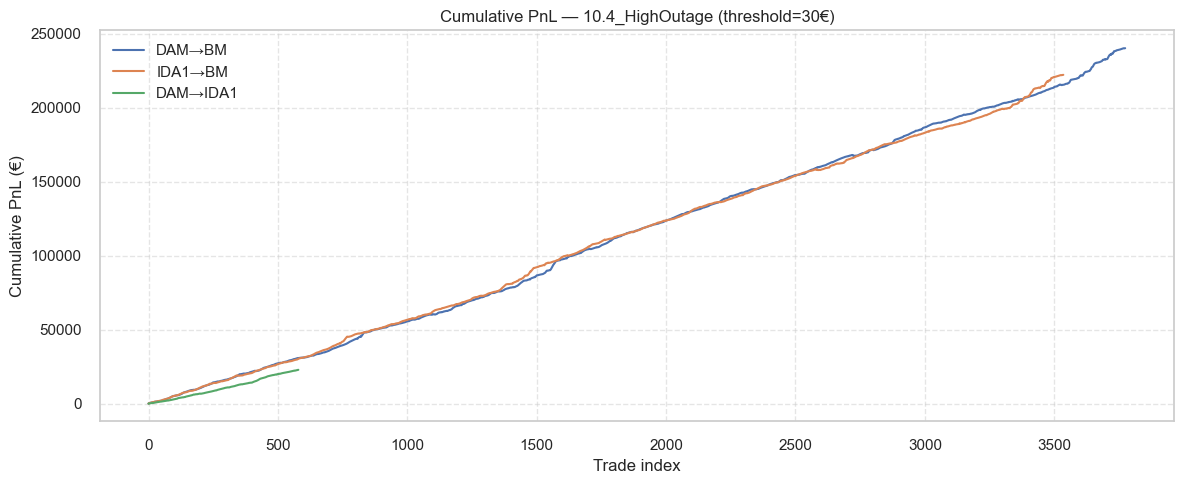

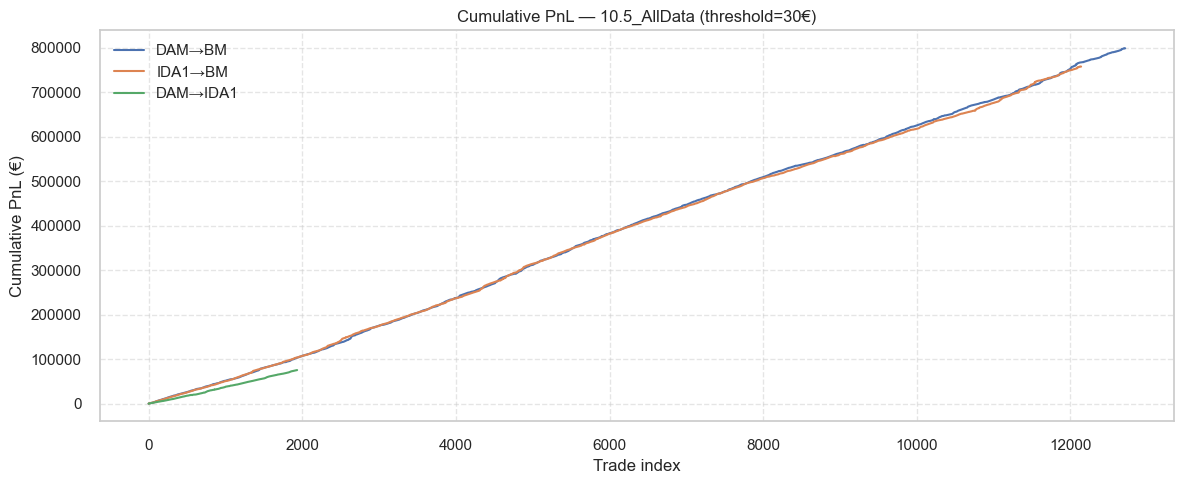

In [65]:
# ==================== SECTION 10: Regime-Based Arbitrage Evaluation ====================

print("\nSECTION 10: Regime-Based Arbitrage Evaluation - Clean Build Started")

# --- 0. Ensure regime flags are boolean ---
regime_cols = ['HighDemand', 'LowWind', 'HighOutage']
for col in regime_cols:
    if col in combined_prices_df.columns:
        combined_prices_df[col] = combined_prices_df[col].astype(bool)

# --- 1. Define evaluation function ---
def evaluate_spread(df, spread_col, signal_col, mask=None, threshold=30):
    """
    Evaluate spread/signal performance with optional regime mask and threshold filter.
    Returns dict of Trades, Hit Rate, Avg PnL, Total PnL.
    """
    d = df if mask is None else df.loc[mask].copy()
    d['Signal_Lag'] = d[signal_col].shift(1)
    d = d.dropna(subset=[spread_col, 'Signal_Lag'])

    spread, sig = d[spread_col], d['Signal_Lag']
    filtered_signal = sig.where(spread.abs() >= threshold, 0)

    pnl = spread * filtered_signal
    valid_trades = filtered_signal != 0

    if valid_trades.sum() == 0:
        return {'Trades': 0, 'Hit Rate (%)': 0.0, 'Avg PnL (€)': 0.0, 'Total PnL (€)': 0.0}

    hit_rate = (np.sign(spread[valid_trades]) == filtered_signal[valid_trades]).mean() * 100
    return {
        'Trades': int(valid_trades.sum()),
        'Hit Rate (%)': round(hit_rate, 2),
        'Avg PnL (€)': round(pnl[valid_trades].mean(), 2),
        'Total PnL (€)': round(pnl[valid_trades].sum(), 2)
    }

# --- 2. Spread configurations (your original three) ---
spread_configs = {
    'DAM→BM': ('Spread_DAMtoBM', 'Signal_DAMtoBM'),
    'IDA1→BM': ('Spread_IDA1toBM', 'Signal_IDA1toBM'),
    'DAM→IDA1': ('Spread_DAMtoIDA1', 'Signal_DAMtoIDA1')
}

# --- 3. Regime masks for 10.1–10.5 ---
masks = {
    '10.1_AllThree': (combined_prices_df['HighDemand'] & 
                      combined_prices_df['LowWind'] & 
                      combined_prices_df['HighOutage']),
    '10.2_HighDemand': combined_prices_df['HighDemand'],
    '10.3_LowWind': combined_prices_df['LowWind'],
    '10.4_HighOutage': combined_prices_df['HighOutage'],
    '10.5_AllData': None # baseline (no regime filter)
}

# --- 4. Run evaluations for each subsection ---
threshold = 30 # can adjust here
results = {}

for regime_name, mask in masks.items():
    print(f"\n--- Evaluating Regime: {regime_name} ---")
    results[regime_name] = {}
    for label, (spread_col, signal_col) in spread_configs.items():
        res = evaluate_spread(combined_prices_df, spread_col, signal_col, mask, threshold)
        results[regime_name][label] = res
        print(f"{label}: Trades={res['Trades']}, Hit={res['Hit Rate (%)']}%, "
              f"Avg PnL={res['Avg PnL (€)']}€, Total PnL={res['Total PnL (€)']}€")

print("\nSECTION 10 Complete: All regime-based evaluations finished successfully.")


# --- 5. Optional: plot cumulative PnL per regime & spread
def cum_pnl_series(df, spread_col, signal_col, mask=None, threshold=30):
    d = df if mask is None else df.loc[mask].copy()
    d['Signal_Lag'] = d[signal_col].shift(1)
    d = d.dropna(subset=[spread_col, 'Signal_Lag'])
    spread = d[spread_col]
    sig = d['Signal_Lag']
    filtered_signal = sig.where(spread.abs() >= threshold, 0)
    pnl = (spread * filtered_signal).where(filtered_signal != 0)
    return pnl.dropna().cumsum().reset_index(drop=True)

import matplotlib.pyplot as plt

for regime_name, mask in masks.items():
    plt.figure(figsize=(12,5))
    for label, (spread_col, signal_col) in spread_configs.items():
        cp = cum_pnl_series(combined_prices_df, spread_col, signal_col, mask, threshold)
        if not cp.empty:
            plt.plot(cp, label=label)
    plt.title(f"Cumulative PnL — {regime_name} (threshold={threshold}€)")
    plt.xlabel("Trade index")
    plt.ylabel("Cumulative PnL (€)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()




=================================================== SECTION 11 =====================================================

In [66]:
print("SECTION 11: Direction Labels, Models & Performance — STARTED")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import lightgbm as lgb

# ---------------------------------------------------------------------------------------
# 11.1 Labels & forward changes (1-step ahead)
# ---------------------------------------------------------------------------------------
# Forward prices
combined_prices_df['PriceDAM_Forward'] = combined_prices_df['PriceDAM'].shift(-1)
combined_prices_df['PriceIDA1_Forward'] = combined_prices_df['PriceIDA1'].shift(-1)
combined_prices_df['PriceIDA2_Forward'] = combined_prices_df['PriceIDA2'].shift(-1)
combined_prices_df['PriceIDA3_Forward'] = combined_prices_df['PriceIDA3'].shift(-1)
combined_prices_df['PriceBM_Forward'] = combined_prices_df['PriceImbalance'].shift(-1)

# Binary directions (1 = up, 0 = down/flat)
combined_prices_df['PriceDirection_DAM'] = (combined_prices_df['PriceDAM_Forward'] > combined_prices_df['PriceDAM']).astype(int)
combined_prices_df['PriceDirection_IDA1'] = (combined_prices_df['PriceIDA1_Forward'] > combined_prices_df['PriceIDA1']).astype(int)
combined_prices_df['PriceDirection_IDA2'] = (combined_prices_df['PriceIDA2_Forward'] > combined_prices_df['PriceIDA2']).astype(int)
combined_prices_df['PriceDirection_IDA3'] = (combined_prices_df['PriceIDA3_Forward'] > combined_prices_df['PriceIDA3']).astype(int)
combined_prices_df['PriceDirection_BM'] = (combined_prices_df['PriceBM_Forward'] > combined_prices_df['PriceImbalance']).astype(int)

# True changes (for PnL)
combined_prices_df['TrueChange_DAM'] = combined_prices_df['PriceDAM_Forward'] - combined_prices_df['PriceDAM']
combined_prices_df['TrueChange_IDA1'] = combined_prices_df['PriceIDA1_Forward'] - combined_prices_df['PriceIDA1']
combined_prices_df['TrueChange_IDA2'] = combined_prices_df['PriceIDA2_Forward'] - combined_prices_df['PriceIDA2']
combined_prices_df['TrueChange_IDA3'] = combined_prices_df['PriceIDA3_Forward'] - combined_prices_df['PriceIDA3']
combined_prices_df['TrueChange_BM'] = combined_prices_df['PriceBM_Forward'] - combined_prices_df['PriceImbalance']

# Placeholders for predictions & PnL
for m in ['DAM', 'IDA1', 'IDA2', 'IDA3', 'BM']:
    combined_prices_df[f'PredictedDirection_{m}'] = np.nan
    combined_prices_df[f'PredictedDirection_{m}_Lag1'] = np.nan
    combined_prices_df[f'SignalPnL_{m}'] = np.nan

print(" 11.1 complete — Labels & forward changes created.")


# ---------------------------------------------------------------------------------------
# 11.2 Reusable training function (leak-safe) + optional probability thresholds
# ---------------------------------------------------------------------------------------
def train_strategy(
    df,
    target_col,
    forward_col,
    base_price_col,
    features,
    model_tag,
    signal_col,
    proba_long=0.55, # go long only if p(up) >= 0.55
    proba_short=0.45 # go short only if p(up) <= 0.45; otherwise abstain
):
    """
    - Fits LGBMClassifier on a chronological split (shuffle=False).
    - Writes back predictions *without leakage* (separate train/test writes).
    - Uses probability thresholds to optionally abstain (PredictedDirection = NaN), improving PnL selectivity.
    - Maps direction: 1->long (+1), 0->short (-1) when not abstaining.
    """
    cols_needed = list(features) + [target_col, forward_col, base_price_col]
    df_model = df[cols_needed].dropna().copy()

    X = df_model[features]
    y = df_model[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, shuffle=False
    )

    clf = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

# Predict train/test separately (avoid leakage)
# If thresholds provided, abstain between them
    def predict_with_abstain(model, X_, p_long=0.55, p_short=0.45):
# returns {1, 0, np.nan}
        proba = model.predict_proba(X_)[:, 1] # P(up)
        out = np.full(len(X_), np.nan)
        out[proba >= p_long] = 1
        out[proba <= p_short] = 0
        return out

    yhat_train = predict_with_abstain(clf, X_train, proba_long, proba_short)
    yhat_test = predict_with_abstain(clf, X_test, proba_long, proba_short)

# Write back predictions only where we predicted
    df.loc[X_train.index, f'PredictedDirection_{model_tag}'] = yhat_train
    df.loc[X_test.index, f'PredictedDirection_{model_tag}'] = yhat_test

# Lag for trade signal
    df[f'PredictedDirection_{model_tag}_Lag1'] = df[f'PredictedDirection_{model_tag}'].shift(1)

# Compute PnL: map 0->-1 (short), 1->+1 (long); NaN -> NaN (abstain)
    trade_side = df[f'PredictedDirection_{model_tag}_Lag1'].map({0: -1, 1: 1})
    df[f'TrueChange_{model_tag}'] = df[forward_col] - df[base_price_col]
    df[signal_col] = df[f'TrueChange_{model_tag}'] * trade_side

# Evaluation on true holdout rows (ignore abstentions in accuracy)
    yhat_test_hard = clf.predict(X_test) # for classification metrics only
    acc = accuracy_score(y_test, yhat_test_hard)
    print(f"\n {model_tag} Classifier Accuracy (holdout): {acc:.2%}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, yhat_test_hard))
    print("Classification Report:\n", classification_report(y_test, yhat_test_hard))

# Report abstention rate on test
    abstain_rate = np.mean(np.isnan(yhat_test))
    print(f"Abstention rate (test): {abstain_rate:.2%}")
    
    return df


# ---------------------------------------------------------------------------------------
# 11.3 Train models for each market (using your common feature set)
# ---------------------------------------------------------------------------------------
features_common = [
    'NetDemand', 'Meteo_ISEMWIND_DAM', 'TotalOutageMW',
    'NetDemand_rolling7', 'Meteo_ISEMWIND_DAM_rolling7',
    'PriceDAM_lag48'
]

combined_prices_df = train_strategy(
    combined_prices_df, 'PriceDirection_DAM', 'PriceDAM_Forward', 'PriceDAM',
    features_common, 'DAM', 'SignalPnL_DAM',
    proba_long=0.55, proba_short=0.45
)

combined_prices_df = train_strategy(
    combined_prices_df, 'PriceDirection_IDA1', 'PriceIDA1_Forward', 'PriceIDA1',
    features_common, 'IDA1', 'SignalPnL_IDA1',
    proba_long=0.55, proba_short=0.45
)

combined_prices_df = train_strategy(
    combined_prices_df, 'PriceDirection_IDA2', 'PriceIDA2_Forward', 'PriceIDA2',
    features_common, 'IDA2', 'SignalPnL_IDA2',
    proba_long=0.55, proba_short=0.45
)

combined_prices_df = train_strategy(
    combined_prices_df, 'PriceDirection_IDA3', 'PriceIDA3_Forward', 'PriceIDA3',
    features_common, 'IDA3', 'SignalPnL_IDA3',
    proba_long=0.55, proba_short=0.45
)

combined_prices_df = train_strategy(
    combined_prices_df, 'PriceDirection_BM', 'PriceBM_Forward', 'PriceImbalance',
    features_common, 'BM', 'SignalPnL_BM',
    proba_long=0.55, proba_short=0.45
)


# ---------------------------------------------------------------------------------------
# 11.4 Strategy performance across outage MW bands (quantile-driven so bands differ)
# ---------------------------------------------------------------------------------------
print("\n--- 11.4: Strategy performance across outage MW bands ---")

markets_cfg = {
    'DAM': {'pred_col': 'PredictedDirection_DAM_Lag1', 'pnl_col': 'SignalPnL_DAM'},
    'IDA1': {'pred_col': 'PredictedDirection_IDA1_Lag1', 'pnl_col': 'SignalPnL_IDA1'},
    'IDA2': {'pred_col': 'PredictedDirection_IDA2_Lag1', 'pnl_col': 'SignalPnL_IDA2'},
    'IDA3': {'pred_col': 'PredictedDirection_IDA3_Lag1', 'pnl_col': 'SignalPnL_IDA3'},
    'BM': {'pred_col': 'PredictedDirection_BM_Lag1', 'pnl_col': 'SignalPnL_BM'}
}

# Data-driven cuts (change to fixed MW if preferred)
qcuts = [0.50, 0.75, 0.90, 0.95] # median, 75th, 90th, 95th
cuts = sorted(set([0] + [int(combined_prices_df['TotalOutageMW'].quantile(q)) for q in qcuts]))

band_results = []
for market, cfg in markets_cfg.items():
    pcol, pnlcol = cfg['pred_col'], cfg['pnl_col']
    if pcol not in combined_prices_df.columns or pnlcol not in combined_prices_df.columns:
        continue

    for thr in cuts:
        df_band = combined_prices_df.loc[
            (combined_prices_df['TotalOutageMW'] >= thr) &
            combined_prices_df[pcol].notna() &
            combined_prices_df[pnlcol].notna()
        ].copy()
        if df_band.empty:
            continue

        sig = df_band[pcol].map({0: -1, 1: 1})
        correct = np.sign(df_band[pnlcol]) == np.sign(sig)

        band_results.append({
            'Market': market,
            'Outage Threshold (MW)': thr,
            'Trades': len(df_band),
            'Hit Rate (%)': round(correct.mean() * 100, 2),
            'Avg PnL (€)': round(df_band[pnlcol].mean(), 2),
            'Total PnL (€)': round(df_band[pnlcol].sum(), 2)
        })

df_band_performance = pd.DataFrame(band_results).sort_values(
    ['Market', 'Outage Threshold (MW)']
)
print(" 11.4 (bands) complete. Preview:")
try:
    display(df_band_performance.head(10))
except:
    print(df_band_performance.head(10))


# ---------------------------------------------------------------------------------------
# 11.5 Plant-level outage impact (focus on influential plants, avoid noise)
# ---------------------------------------------------------------------------------------
print("\n--- 11.5: Plant-level outage impact ---")

plant_cols = [c for c in combined_prices_df.columns if c.startswith(("GU_", "DSU_", "Out_"))]
min_trades = 200 # require at least this many rows per (market, plant) to report

plant_results = []
for market, cfg in markets_cfg.items():
    pcol, pnlcol = cfg['pred_col'], cfg['pnl_col']
    if pcol not in combined_prices_df or pnlcol not in combined_prices_df:
        continue

    base = combined_prices_df[
        combined_prices_df[pcol].notna() & combined_prices_df[pnlcol].notna()
    ].copy()
    if base.empty:
        continue

    base['Signal'] = base[pcol].map({0: -1, 1: 1})

    for plant in plant_cols:
        df_out = base[base[plant] > 0]
        if df_out.shape[0] < min_trades:
            continue
        correct = np.sign(df_out[pnlcol]) == np.sign(df_out['Signal'])
        plant_results.append({
            'Market': market,
            'Plant': plant,
            'Trades': len(df_out),
            'Hit Rate (%)': round(correct.mean() * 100, 2),
            'Avg PnL (€)': round(df_out[pnlcol].mean(), 2),
            'Total PnL (€)': round(df_out[pnlcol].sum(), 2)
        })

df_plant_impact = pd.DataFrame(plant_results)
df_plant_impact = df_plant_impact.sort_values(
    by=['Market', 'Total PnL (€)'], ascending=[True, False]
)

print(" 11.5 complete. Top plants per market (min_trades >= {}):".format(min_trades))
try:
    display(df_plant_impact.groupby("Market").head(5))
except:
    print(df_plant_impact.groupby("Market").head(5))


# ---------------------------------------------------------------------------------------
# 11.6 Scenario-based strategy performance (core + extended)
# ---------------------------------------------------------------------------------------
print("\n--- 11.6: Scenario-based strategy performance ---")

# Ensure the three regime flags are boolean if present
for col in ['HighDemand', 'LowWind', 'HighOutage']:
    if col in combined_prices_df:
        combined_prices_df[col] = combined_prices_df[col].astype(bool)

scenario_flags = {
    'HighDemand': (combined_prices_df['HighDemand'] == True) if 'HighDemand' in combined_prices_df else pd.Series(False, index=combined_prices_df.index),
    'LowWind': (combined_prices_df['LowWind'] == True) if 'LowWind' in combined_prices_df else pd.Series(False, index=combined_prices_df.index),
    'HighOutage': (combined_prices_df['HighOutage'] == True) if 'HighOutage' in combined_prices_df else pd.Series(False, index=combined_prices_df.index),
    'HighDemand & LowWind': (combined_prices_df.get('HighDemand', False) & combined_prices_df.get('LowWind', False)),
    'HighDemand & HighOutage':(combined_prices_df.get('HighDemand', False) & combined_prices_df.get('HighOutage', False)),
    'LowWind & HighOutage': (combined_prices_df.get('LowWind', False) & combined_prices_df.get('HighOutage', False)),
    'AllThree': (combined_prices_df.get('HighDemand', False) & combined_prices_df.get('LowWind', False) & combined_prices_df.get('HighOutage', False)),
}

scenario_rows = []
for scen_name, scen_mask in scenario_flags.items():
    for market, cfg in markets_cfg.items():
        pcol, pnlcol = cfg['pred_col'], cfg['pnl_col']
        df_s = combined_prices_df.loc[
            scen_mask &
            combined_prices_df[pcol].notna() &
            combined_prices_df[pnlcol].notna()
        ].copy()
        if df_s.empty:
            continue
        sig = df_s[pcol].map({0: -1, 1: 1})
        correct = np.sign(df_s[pnlcol]) == np.sign(sig)
        scenario_rows.append({
            'Scenario': scen_name,
            'Market': market,
            'Trades': len(df_s),
            'Hit Rate (%)': round(correct.mean() * 100, 2),
            'Avg PnL (€)': round(df_s[pnlcol].mean(), 2),
            'Total PnL (€)': round(df_s[pnlcol].sum(), 2)
        })

df_scenario_results = pd.DataFrame(scenario_rows).sort_values(['Scenario', 'Market'])
print(" 11.6 complete. Scenario results preview:")
try:
    display(df_scenario_results.head(12))
except:
    print(df_scenario_results.head(12))

print("\nSECTION 11 — COMPLETE.")


SECTION 11: Direction Labels, Models & Performance — STARTED
 11.1 complete — Labels & forward changes created.

 DAM Classifier Accuracy (holdout): 57.09%
Confusion Matrix:
 [[1487 1277]
 [ 227  514]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.54      0.66      2764
           1       0.29      0.69      0.41       741

    accuracy                           0.57      3505
   macro avg       0.58      0.62      0.54      3505
weighted avg       0.74      0.57      0.61      3505

Abstention rate (test): 19.57%

 IDA1 Classifier Accuracy (holdout): 58.68%
Confusion Matrix:
 [[1152  822]
 [ 626  904]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.58      0.61      1974
           1       0.52      0.59      0.56      1530

    accuracy                           0.59      3504
   macro avg       0.59      0.59      0.58      3504
weighted avg       0.59      

Market  Outage Threshold (MW)  Trades  Hit Rate (%)  Avg PnL (€)  Total PnL (€)
20     BM                      0    9839         46.80         5.00       49199.93
21     BM                   1963    4963         46.42         4.35       21607.11
22     BM                   2278    2587         46.85         5.66       14636.32
23     BM                   2546    1123         47.11         6.72        7543.69
24     BM                   2695     607         50.41         6.42        3895.48
0     DAM                      0   14458         20.69         3.93       56870.60
1     DAM                   1963    7166         20.42         3.95       28304.06
2     DAM                   2278    3672         20.75         4.23       15532.89
3     DAM                   2546    1445         22.15         4.09        5912.01
4     DAM                   2695     726         21.21         4.09        2966.13


--- 11.5: Plant-level outage impact ---
 11.5 complete. Top plants per market (min_trades >= 200):


Market      Plant  Trades  Hit Rate (%)  Avg PnL (€)  Total PnL (€)
214     BM  GU_400750    9839         46.80         5.00       49199.93
215     BM  GU_400751    9839         46.80         5.00       49199.93
216     BM  GU_400752    9839         46.80         5.00       49199.93
217     BM  GU_400753    9839         46.80         5.00       49199.93
227     BM  GU_401440    9839         46.80         5.00       49199.93
20     DAM  GU_400750   14458         20.69         3.93       56870.60
21     DAM  GU_400751   14458         20.69         3.93       56870.60
22     DAM  GU_400752   14458         20.69         3.93       56870.60
23     DAM  GU_400753   14458         20.69         3.93       56870.60
33     DAM  GU_401440   14458         20.69         3.93       56870.60
79    IDA1  GU_400750   13112         44.84         4.23       55514.45
80    IDA1  GU_400751   13112         44.84         4.23       55514.45
81    IDA1  GU_400752   13112         44.84         4.23       55514.45
82    IDA1  GU_400753   13112         44.84         4.23       55514.45
92    IDA1  GU_401440   13112         44.84         4.23       55514.45
135   IDA2  GU_400750    6472         45.75         6.49       42022.21
136   IDA2  GU_400751    6472         45.75         6.49       42022.21
137   IDA2  GU_400752    6472         45.75         6.49       42022.21
138   IDA2  GU_400753    6472         45.75         6.49       42022.21
148   IDA2  GU_401440    6472         45.75         6.49       42022.21
177   IDA3  GU_400750    3152         33.09         4.80       15143.28
178   IDA3  GU_400751    3152         33.09         4.80       15143.28
179   IDA3  GU_400752    3152         33.09         4.80       15143.28
180   IDA3  GU_400753    3152         33.09         4.80       15143.28
186   IDA3  GU_401440    3152         33.09         4.80       15143.28


--- 11.6: Scenario-based strategy performance ---
 11.6 complete. Scenario results preview:


Scenario Market  Trades  Hit Rate (%)  Avg PnL (€)  Total PnL (€)
34                 AllThree     BM     770         49.61         8.89        6846.47
30                 AllThree    DAM     956         18.83         6.49        6200.91
31                 AllThree   IDA1     905         39.01         6.86        6209.90
32                 AllThree   IDA2     570         42.11         7.55        4301.50
33                 AllThree   IDA3     244         31.15         6.81        1661.85
4                HighDemand     BM    3423         48.70         8.93       30567.45
0                HighDemand    DAM    4488         20.37         6.54       29367.73
1                HighDemand   IDA1    4276         42.10         7.24       30972.31
2                HighDemand   IDA2    2809         43.33         9.10       25555.51
3                HighDemand   IDA3    1442         30.65         7.52       10848.18
24  HighDemand & HighOutage     BM    1004         50.20         9.03        9070.09
20  HighDemand & HighOutage    DAM    1335         19.93         6.50        8681.58


SECTION 11 — COMPLETE.
